## Utils

In [ ]:
from cProfile import label
import os
import subprocess
import random
import shutil
from PIL import Image
from skimage.measure import label, regionprops
import scipy

from os.path import join, split
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap   
from matplotlib.pyplot import cm, Normalize 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import time
import re
import h5py
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from torchsummary import summary


### AF SLO CLASSIFICATION ###
# CLA_DATA_OLD_PATH = r'C:\Users\Fu Tianyu\Documents\UCL\CSML\Final Project\CSML_Summer2022\Data\SLO_AF_classifier\Oxford'
# allocate to the new directory
CLA_DATA_NEW_PATH = r''
CLA_MODEL_PATH = r''
CLA_H5_FILE_PATH = r''


### AF SEGMENTATION ###
SEG_DATA_PATH = r""
RPGR_PATH = join(SEG_DATA_PATH, 'RPGR')
USH_PATH = join(SEG_DATA_PATH, 'USH')

SEG_H5_FILE_PATH = r""
SEG_MODEL_PATH = r""
SEG_VISUAL_PATH = r""


### AF SLO MTL ###
MTL_MODEL_PATH = r""
MTL_VISUAL_PATH = r""

subprocess.call(["rm", "-r", CLA_MODEL_PATH, CLA_H5_FILE_PATH, SEG_H5_FILE_PATH, SEG_MODEL_PATH, SEG_VISUAL_PATH, MTL_MODEL_PATH, MTL_VISUAL_PATH])
subprocess.call(["mkdir", "-p", CLA_MODEL_PATH, CLA_H5_FILE_PATH, SEG_H5_FILE_PATH, SEG_MODEL_PATH, SEG_VISUAL_PATH, MTL_MODEL_PATH, MTL_VISUAL_PATH])



0

In [ ]:

NORM_SIZE_CLA = 256

def data_extract(indices, x_all, y_all):
    xs = []
    ys = []
    for index in indices:
        xs.append(x_all[index])
        ys.append(y_all[index])
    
    return xs, ys

# def data_split(indice, image_all, mask_all):
#     imgs = []
#     masks = []
#     for id in indice:
#         imgs.append(image_all[id])
#         masks.append(mask_all[id])
#     return imgs, masks


def stat_compute_log(stat_list, str_type, folds=5):
    stat_avg = np.mean(stat_list)
    stat_std = np.std(stat_list)

    stat_list = [round(num,4) for num in stat_list]
    print(f'{folds}-fold {str_type}: ', stat_list)
    print('%d-fold %s mean and std: %.4f \u00B1 %.4f' % (folds, str_type, stat_avg, stat_std))

    return stat_avg, stat_std




'''
AF Segmentation helper functions
'''

# inputs(1,3,768,768) outputs(1,3,768,768)
def patch_infer_output(model, inputs, norm_size, device):
    stride = 128
    psize = 256
    gsize = (norm_size-psize)//stride+1
    
    outputs = torch.zeros((1,2,norm_size,norm_size)).to(device)
    count = torch.zeros((norm_size, norm_size)).to(device)
    for i in range(gsize):
        for j in range(gsize):
            x_begin = i*stride
            x_end = x_begin + psize
            y_begin = j*stride
            y_end = y_begin + psize

            patch = TF.crop(inputs, x_begin, y_begin, psize, psize)
            poutput = model(patch)
            outputs[...,x_begin:x_end,y_begin:y_end] += poutput 
            count[x_begin:x_end,y_begin:y_end] += 1

    outputs = torch.div(outputs, count)
    return outputs


def clahe_apply(image):
    clipLimit = 1.0
    gridsize = 8
    clahe = cv2.createCLAHE(clipLimit=clipLimit,tileGridSize=(gridsize,gridsize))
    g,b,r = cv2.split(image)
    g = clahe.apply(g)
    b = clahe.apply(b)
    r = clahe.apply(r)
    img_clahe = cv2.merge((g,b,r))

    return img_clahe



def post_process(pred_mask, norm_size):
    # test
    # plt.imshow(pred_mask, cmap='gray')
    # plt.show()
    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().detach().numpy()

    labeled_img = label(pred_mask, connectivity=2) 
    regions = regionprops(labeled_img) # not include background
    num_region = len(regions)
    if num_region == 0: 
        pass
    else:
        # the distance between region centroid and image center
        dst_list = []
        area_list = []
        for region in regions:
            re_cen = np.array(region.centroid)
            img_cen = np.array([norm_size/2,norm_size/2])
            dst = np.linalg.norm(re_cen-img_cen)
            dst_list.append(dst)
            area_list.append(region.area)
        
        if num_region < 3:
            idx_best = np.argmin(dst_list)
        else:
            # indices of 3 max areas
            idx_maxarea_candid = np.argpartition(area_list, -3)[-3:]
            idx_maxarea = []
            for i in idx_maxarea_candid:
                if area_list[i] > 100:
                    idx_maxarea.append(i)
            
            # region index with their corresponding distance
            if len(idx_maxarea) == 0:
                dst_candid = [dst_list[i] for i in idx_maxarea_candid]
                idx_best = idx_maxarea_candid[np.argmin(dst_candid)]
            else:    
                dst_candid = [dst_list[i] for i in idx_maxarea]
                idx_best = idx_maxarea[np.argmin(dst_candid)]

        pred_mask[labeled_img != idx_best+1] = 0
        pred_mask = scipy.ndimage.binary_fill_holes(pred_mask)
    
    return pred_mask

def load_imgs_seg(data_paths, data_type, norm_size, clahe_bool):
    """Crop and downsample images

    Args:
        data_paths: data paths 
        data_type: data type
        clahe_bool: CLAHE enhancement or not

    Returns:
        uniform size data
    """
    assert data_type == 'image' or 'mask', 'No such data type'
    images = []
    for img_path in data_paths:
        img = cv2.imread(img_path)

        if data_type == 'mask':
            # make mask values {0,255}
            _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
            img = img//255

        # crop and resize image to the same size
        x, y, _ = img.shape
        length = min(x, y)
        
        if x != y:
            img = img[:length, :length]
        
        if clahe_bool and data_type == 'image':
            img = clahe_apply(img)

        if img.shape[0] != norm_size:
            img = cv2.resize(img, (norm_size, norm_size))
    
        # img = img.astype(np.uint8)
        images.append(np.array(img))

    return np.array(images)



def load_imgs_cla(img_paths):
    """Crop/downsample and load image data into an array of images 

    Args:
        img_paths: image paths

    Returns:
        an array of images
    """
    images = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        # crop and resize image to the same size
        x, y, _ = img.shape
        if x != y:
            length = min(x, y)
            img = img[:length, :length]
        if img.shape[0] != NORM_SIZE_CLA:
            img = cv2.resize(img, (NORM_SIZE_CLA, NORM_SIZE_CLA))
        
        images.append(np.array(img))

    return np.array(images)


def image_restore_seg(img, size_origin):
    """Restore a single mask: upsample and add all black if original mask is not square

    Args:
        imgs: downsampled mask predictions
        size_origin: original mask size
    """
    if torch.is_tensor(img):
        img = img.cpu().detach().numpy()
    x, y = size_origin
    length = min(x, y)
    img = cv2.resize(np.array(img, dtype=np.uint8), (length, length))
    if x != y:
        assert x>y
        img = cv2.copyMakeBorder(img, 0, x-y, 0, 0, cv2.BORDER_CONSTANT, None, value = 0)

    return img



def create_h5_train_seg(imgs, masks, type, norm_size, clahe):
    """Create the hdf5 file for each subset containing images and masks

    Args:
        imgs: a list of train image paths
        masks: a list of train mask paths
    """
    imgs_arr = load_imgs_seg(imgs, 'image', norm_size, clahe)
    masks_arr = load_imgs_seg(masks, 'mask', norm_size, clahe)

    h5_file_name = join(SEG_H5_FILE_PATH, f'{type}.h5')
    if os.path.exists(h5_file_name): os.remove(h5_file_name)

    with h5py.File(h5_file_name, 'w') as f:
        f.create_dataset(name='imgs', data=imgs_arr)
        f.create_dataset(name='masks', data=masks_arr)


def create_h5_test_seg(imgs, masks, type, norm_size, clahe, fid=None):
    """Create the hdf5 file for each subset

    Args:
        imgs: a list of val/test image paths
        masks: a list of val/test mask paths
        type: 'val' or 'test'
    """
    # save the resized images and masks
    imgs_arr = load_imgs_seg(imgs, 'image', norm_size, clahe)
    masks_arr = load_imgs_seg(masks, 'mask', norm_size, clahe)

    if type == 'val':
        h5_file_name = join(SEG_H5_FILE_PATH, 'val.h5')
        if os.path.exists(h5_file_name): os.remove(h5_file_name)
    elif type == 'test':
        h5_file_name = join(SEG_H5_FILE_PATH, f'test{fid}.h5')

    with h5py.File(h5_file_name, 'w') as f:
        for i, (img, mask) in enumerate(zip(imgs, masks)):
            img_name = os.path.split(img)[-1].split('.')[0]
            mask_name = os.path.split(mask)[-1].split('.')[0]
            assert img_name == mask_name, "image and mask don't match"

            # test
            # if img_name == '1564100_OD_2016':
            #     print(img_name)
            #     xxx = cv2.imread(mask)
            #     _, xxx = cv2.threshold(xxx, 127, 255, cv2.THRESH_BINARY)
            #     xxx = xxx//255*255
                
            #     cv2.imshow('xxx', xxx)
            #     print()

            mask_origin = cv2.imread(mask)
            _, mask_origin = cv2.threshold(mask_origin, 127, 255, cv2.THRESH_BINARY)
            mask_origin = mask_origin//255
            img_trans = imgs_arr[i]
            mask_trans = masks_arr[i]
        
            f.create_dataset(name=img_name, data=np.array([img_trans, mask_trans]))
            f.create_dataset(name=img_name+'_origin', data=np.array(mask_origin, dtype='uint8'))




 
def seg_visual(pred_mask_restore, var_map, miou_restore, img_name, fig_name, model_type):
    """Display image, ground truth, restored predicted mask, uncertainty map 

    Args:
        pred_mask_restore: restored predicted mask
        var_map: uncertainty map
        miou_restore: mIoU score of the restored mask
        img_name: image filename
        fig_name: saved filename
    """
    assert model_type == 'mtl' or 'seg'
    if type(pred_mask_restore) != np.ndarray:
        pred_mask_restore = pred_mask_restore.cpu().detach().numpy()
    
    if var_map is None:
        fig, axs = plt.subplots(1, 3)
    else:
        fig, axs = plt.subplots(1, 4)

    if 'RPGR' in img_name:
        img_path = join(RPGR_PATH, img_name+'.tif')
        gt_path = join(RPGR_PATH, img_name+'.jpg')
    else:
        img_path = join(USH_PATH, img_name+'.tif')
        gt_path = join(USH_PATH, img_name+'.jpg')
    
    img = plt.imread(img_path)
    gt = plt.imread(gt_path)
    pred_mask_restore = np.repeat(pred_mask_restore[:, :, np.newaxis], 3, axis=2)*255
    
    axs[0].imshow(img)    
    axs[0].axis('off')
    
    axs[1].imshow(gt)
    axs[1].set_title('Ground truth mask')
    axs[1].axis('off')
    
    axs[2].imshow(pred_mask_restore)
    axs[2].set_title('Predicted mask \n (mIoU=%.3f)' % miou_restore)
    axs[2].axis('off')

    if var_map is not None:
        axs[3].imshow(var_map, cmap='Greys')
        axs[3].set_title('Uncertainty \n map')
        axs[3].axis('off')

    plt.tight_layout()
    if model_type == 'mtl':
        plt.savefig(join(MTL_VISUAL_PATH, fig_name))  
    else:
        plt.savefig(join(SEG_VISUAL_PATH, fig_name))
    plt.close()

    # # test
    # save_dir_path = r'C:\Users\Fu Tianyu\Documents\UCL\CSML\Final Project\CSML_Summer2022\AF_Seg\visual_demo'
  
    # shutil.copy(img_path, save_dir_path) 
    # if var_map is not None:
    #     cv2.normalize(var_map, var_map, 0, 255, cv2.NORM_MINMAX)
    #     var_map = np.repeat(var_map[:, :, np.newaxis], 3, axis=2)
    #     cv2.imwrite(join(save_dir_path, img_name+'_probmap.png'), var_map)



# All images are of size (256, 256, 3)
def seg_visual_overlap(norm_size, gt_mask, pred_mask, var_map, img_name, fig_name, model_type):
    """Display downsampled image, ground truth (boundary), 
               restored predicted mask (boundary), uncertainty map (heatmap) in a same image 

    Args:
        pred_mask_restore: restored predicted mask
        var_map: uncertainty map
        miou_restore: mIoU score of the restored mask
        img_name: image filename
        fig_name: saved filename
    """
    assert model_type == 'mtl' or 'seg'
    
    # read original image
    if 'RPGR' in img_name:
        img_path = join(RPGR_PATH, img_name+'.tif')
    else:
        img_path = join(USH_PATH, img_name+'.tif')
    image = cv2.imread(img_path)
    
    x, y, _ = image.shape
    if x != y:
        length = min(x, y)
        image = image[:length, :length]

    if image.shape[0] != norm_size:
        image = cv2.resize(image, (norm_size, norm_size))

    if type(gt_mask) != np.ndarray:
        gt_mask = gt_mask.cpu().detach().numpy() # (512,512)
    if type(pred_mask) != np.ndarray:
        pred_mask = pred_mask.cpu().detach().numpy() # (512,512)
    gt_mask = np.repeat(gt_mask[:, :, np.newaxis], 3, axis=2).astype('uint8')*255
    pred_mask = np.repeat(pred_mask[:, :, np.newaxis], 3, axis=2).astype('uint8')*255
    
    cmap = cm.YlOrBr
    c_cmap = cmap(np.arange(cmap.N))
    c_cmap[:, -1] = np.linspace(0, 1, cmap.N)
    c_cmap = ListedColormap(c_cmap)

    if var_map is not None:
        norm = Normalize(vmin=var_map.min(), vmax=var_map.max())
        var_heatmap = c_cmap(norm(var_map))

        # Blend image with heatmap
        var_heatmap = cv2.cvtColor(np.uint8(var_heatmap * 255), cv2.COLOR_RGBA2BGRA)
        alpha = var_heatmap[..., 3] / 255
        alpha = np.tile(np.expand_dims(alpha, axis=2), [1, 1, 3])
        image = (image * (1 - alpha) + var_heatmap[..., :3] * alpha).astype(np.uint8)


    gt_mask = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
    pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2GRAY)

    gt_contours, _ = cv2.findContours(gt_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    pred_contours, _ = cv2.findContours(pred_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    cv2.drawContours(image, gt_contours, -1, (0,255,0), thickness=1, lineType=cv2.LINE_AA)
    # # test
    # if img_name == '1564100_OD_2016':
    #     cv2.imshow('gtmask', image)

    cv2.drawContours(image, pred_contours, -1, (0,0,255), thickness=1, lineType=cv2.LINE_AA)
    if model_type == 'mtl':
        cv2.imwrite(join(MTL_VISUAL_PATH, 'overlap_' + fig_name), image)
    else:
        cv2.imwrite(join(SEG_VISUAL_PATH, 'overlap_' + fig_name), image)

    # # test
    # save_dir_path = r'C:\Users\Fu Tianyu\Documents\UCL\CSML\Final Project\CSML_Summer2022\AF_Seg\visual_demo'
    # cv2.imwrite(join(save_dir_path, img_name+'_pred.png'), image)


def mIoU_score(pred, target, num_classes=2):
    """Compute the mIoU scores of mask pair

    Args:
        pred: _description_
        target: _description_
        num_classes: _description_. Defaults to 2.

    Returns:
        mIoU value
    """
    if type(pred) != np.ndarray:
        pred = pred.cpu().detach().numpy()
    if type(target) != np.ndarray:
        target = target.cpu().detach().numpy()
    
    inter1 = np.sum(np.multiply(pred, target))
    inter0 = np.sum(np.multiply(1-pred, 1-target))
    iou1 = inter1 / (np.sum(pred) + np.sum(target) - inter1 + 1e-8)
    iou0 = inter0 / (np.sum(1-pred) + np.sum(1-target) - inter0 + 1e-8)
    miou = (iou1+iou0) / 2

    return miou


def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()


class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.softmax(inputs, dim=1)[:,1,:,:]
        
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.softmax(inputs, dim=1)[:,1,:,:]
        targets = targets.type(torch.float32)       
        
        #flatten label and prediction tensors
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

# Multi-task learning loss: 
# Sum of classification loss (ce) and segmentation loss (dice-bce)
class MTLLoss(nn.Module):
    def __init__(self):
        super(MTLLoss, self).__init__()

    def forward(self, seg_inputs, cla_inputs, seg_targets, cla_targets, smooth=1):
        # seg_inputs (N,2,256,256)  seg_targets (N, 256, 256) 
        # cla_inputs (N,2)          cla_targets (N)
        seg_inputs = F.softmax(seg_inputs, dim=1)[:,1,:,:]
        seg_targets = seg_targets.type(torch.float32)       
        
        cla_inputs = F.softmax(cla_inputs, dim=1)[:,1]
        cla_targets = cla_targets.type(torch.float32)       
        
        # Flatten label and prediction tensors
        seg_inputs = seg_inputs.contiguous().view(-1)
        seg_targets = seg_targets.contiguous().view(-1)
        
        # cla_inputs = cla_inputs.contiguous().view(-1)
        # cla_targets = cla_targets.contiguous().view(-1)
        
        intersection = (seg_inputs * seg_targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(seg_inputs.sum() + seg_targets.sum() + smooth)  
        seg_bce = F.binary_cross_entropy(seg_inputs, seg_targets, reduction='mean')
        cla_bce = F.binary_cross_entropy(cla_inputs, cla_targets, reduction='mean')
        
        return dice_loss+seg_bce+cla_bce 




'''
AF/SLO Classification helper functions
'''


# def load_img(img_path):

#     img = cv2.imread(img_path)
#     # crop and resize image to the same size
#     NORM_SIZE = 768
#     x, y, _ = img.shape
#     if x != y:
#         length = min(x, y)
#         img = img[:length, :length]
#     if img.shape[0] != NORM_SIZE:
#         img = cv2.resize(img, (NORM_SIZE, NORM_SIZE))
    
#     return np.array(img)

def display_imgs_cla(imgs):
    num = 10
    fig, axs = plt.subplots(1, num)
    for i in range(num):
        axs[i].imshow(imgs[i])
        axs[i].axis('off')
    plt.savefig('img_display.png')


def create_h5_cla(imgs, labels, type, fid=None):
    """Create the hdf5 file for each subset containing images and labels

    Args:
        imgs: a list of image paths
        labels: a list of image labels
        type: 'train' or 'val' or 'test'
    """
    assert type == 'train' or 'val' or 'test', 'Unrecognizable dataset type'
    imgs_arr = load_imgs_cla(imgs)
    labels_arr = np.array(labels)
    if type == 'test':
        h5_file_name = join(CLA_H5_FILE_PATH, f'{type}{fid}.h5')
    else:
        h5_file_name = join(CLA_H5_FILE_PATH, f'{type}.h5')
        if os.path.exists(h5_file_name): os.remove(h5_file_name)

    with h5py.File(h5_file_name, 'w') as f:
        f.create_dataset(name='imgs', data=imgs_arr)
        f.create_dataset(name='labels', data=labels_arr)


def change_state_keys(state_dict, type):
    assert type == 'seg' or 'cla'
    old_keys = list(state_dict.keys())
    for old_key in old_keys:
        if type == 'seg':
            rexpr = r'conv_block\1_1'
        else:
            rexpr = r'conv_block\1_2'
        new_key = re.sub(r'^conv_block(\d)', rexpr, old_key)
        state_dict[new_key] = state_dict.pop(old_key)

    return state_dict


def roc_plot(fpr, tpr, auc, fid):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve for SLO AF classification")
    plt.legend(loc="lower right")
    plt.savefig(join(CLA_MODEL_PATH, f'roc_curve_fold{fid+1}.png'))


def roc_plot_all(fprs, tprs, auc_mean, auc_std, type):
    # fpr_mean = np.mean(fprs, axis=0)
    # tpr_mean = np.mean(tprs, axis=0)

    plt.figure()
    
    # all curves
    fair_color_list = ["coral", "gold", "yellowgreen", "turquoise", "darkorchid"]
    for i in range(5):
        plt.plot(fprs[i], tprs[i], color=fair_color_list[i], lw=1, label=f"fold {i+1}")
    plt.plot([0, 1], [0, 1], color="lightgray", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves for all folds (AUC = %0.4f \u00B1 %0.4f)" % (auc_mean, auc_std))
    plt.legend(loc="lower right")
    plt.savefig(join(SEG_MODEL_PATH, f'{type}_ROC_curves_all.png'))


## Dataset

In [ ]:
'''
Dataset for segmentation
'''
class AFDataset(Dataset):
    def __init__(self, type, augmentation, aug_list=None, fid=None):
        # open the h5 file
        assert type == 'train' or 'val' or 'test', 'Unrecognizable dataset type'
        self.type = type
        if type =='test':
            h5_file_name = join(SEG_H5_FILE_PATH, f'{self.type}{fid}.h5')
        else:
            h5_file_name = join(SEG_H5_FILE_PATH, f'{self.type}.h5')
        self.hdf5 = h5py.File(h5_file_name, 'r')
        self.augmentation = augmentation
        self.aug_list = aug_list
        if self.type != 'train':
            self.file_keys = list(self.hdf5.keys())
            # filenames = [self.file_keys[i] for i in range(0, len(self.file_keys), 2)]
            # print(f'{self.type} dataset: {filenames}')

    def __len__(self):
        if self.type == 'train':
            self.length = self.hdf5['masks'].shape[0]
        else: 
            self.length = int(len(self.file_keys)/2)
        
        return self.length
    
    def __getitem__(self, index):
        filename = ''
        mask_origin = np.zeros(1)
        if self.type == 'train':        
            img = self.hdf5['imgs'][index]
            mask = self.hdf5['masks'][index]

            
            if self.augmentation:
                img, mask = self.augment(img, mask, self.aug_list) 

        else:
            filename = self.file_keys[2*index]
            
            img = self.hdf5[filename][0]
            mask = self.hdf5[filename][1]
            mask_origin = self.hdf5[filename+'_origin'][:,:,-1]
            # # test
            # if filename == '1564100_OD_2016':
            #     mask_show = mask*255
            #     mask_origin_show = mask_origin*255
            #     cv2.imshow('mask_show', mask_show)
            #     cv2.imshow('mask_origin_show', mask_origin_show)
            #     print()

        
        # Transform to tensor
        img = TF.to_tensor(img)
        mask = torch.tensor(np.array(mask)[:,:,-1], dtype=torch.long)
        # Normalisation
        normalise = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        img = normalise(img)

        return img, mask, mask_origin, filename

    def augment(self, img, mask, aug_list):
        # transform to pillow image
        img = TF.to_pil_image(img)
        mask = TF.to_pil_image(mask)

        if 'crop_rand' in aug_list:
            # random crop
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(256, 256))
            img = TF.crop(img, i, j, h, w)
            mask = TF.crop(mask, i, j, h, w)
        elif 'crop_stride' in aug_list:
            randid = np.random.randint(25)
            i = 128*(randid//5)
            j = 128*(randid%5)
            img = TF.crop(img, i, j, 256, 256)
            mask = TF.crop(mask, i, j, 256, 256)



        if 'flip' in aug_list:
            # random horizontal flipping
            if random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
            # random vertical flipping
            if random.random() > 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)

        if 'rotate' in aug_list:
            # random rotation
            deg = transforms.RandomRotation.get_params([-5,5])
            img = TF.rotate(img, deg)
            mask = TF.rotate(mask, deg)

        return img, mask

    def close(self):
        self.hdf5.close()




'''
Dataset for classification
'''
class ASDataset(Dataset):
    def __init__(self, type, transform, fid=None):
        # open the h5 file
        assert type == 'train' or 'val' or 'test', 'Unrecognizable dataset type'

        if type =='test':
            h5_file_name = join(CLA_H5_FILE_PATH, f'{type}{fid}.h5')
        else:
            h5_file_name = join(CLA_H5_FILE_PATH, f'{type}.h5')
        self.dset = h5py.File(h5_file_name, 'r')
        self.length = self.dset['labels'].shape[0]
        
        self.transform = transform
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
                
        img = self.dset['imgs'][index]
        # (c, 3, 256, 256)
        img = self.transform(img)
        label = self.dset['labels'][index]        
        label = torch.tensor(label, dtype=torch.long)

        return img, label

    def close(self):
        self.dset.close()


## MTL Model

### Cross Stitch Model

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class Cross_stitch(nn.Module):
    def __init__(self, channels, p_same, p_diff):
        super().__init__()

        # define trainable parameters
        self.channels = channels
        # p_diff = 1-p_same
        self.p_same, self.p_diff = p_same, p_diff

        weight_cs = np.array([[p_same, p_diff],[p_diff, p_same]])
        weights = np.repeat(weight_cs[np.newaxis, :, :], self.channels, axis=0)
        self.weights = nn.Parameter(torch.Tensor(weights))

    def forward(self, x_a, x_b, device):
        
        # input size (N, C, H, W)
        assert x_a.shape == x_b.shape, f"tensor shape a ({x_a.shape}) and b ({x_b.shape}) doesn't match"
        size = x_a.shape
        N,C,H,W = size
        x_a_cs = torch.empty(size=size, dtype=torch.float32).to(device)
        x_b_cs = torch.empty(size=size, dtype=torch.float32).to(device)
        
        # for every channel, the module use the same set of weights
        for c in range(C):
            x_a_chn = x_a[:,c,:,:]  # (N, H, W)
            x_b_chn = x_b[:,c,:,:] 
            weight = self.weights[c,:,:] # (2,2)

            x_a_chn_reshaped = torch.unsqueeze(torch.flatten(x_a_chn), dim=0)
            x_b_chn_reshaped = torch.unsqueeze(torch.flatten(x_b_chn), dim=0)
            x_combo_chn = torch.concat((x_a_chn_reshaped, x_b_chn_reshaped), dim=0)
            x_combo_chn_cs = torch.matmul(weight, x_combo_chn)

            # restore
            x_a_chn_cs = x_combo_chn_cs[0].reshape((N, H, W))
            x_b_chn_cs = x_combo_chn_cs[1].reshape((N, H, W))
            x_a_cs[:,c,:,:] = x_a_chn_cs
            x_b_cs[:,c,:,:] = x_b_chn_cs

        return x_a_cs, x_b_cs



class MTL(nn.Module):
    def block(self, conv_num, in_chn, out_chn):
        layers = []
        for i in range(conv_num):
            if i == 0:
                layers.append(nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1))
            else:
                layers.append(nn.Conv2d(out_chn, out_chn, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_chn))
            layers.append(nn.ReLU())   
        
        return nn.Sequential(*layers)
    
    def de_block(self, conv_num, in_chn, out_chn):
        layers = []
        for i in range(conv_num):
            if i == conv_num-1:
                layers.append(nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(out_chn))
            else:
                layers.append(nn.Conv2d(in_chn, in_chn, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(in_chn))
            layers.append(nn.ReLU())   
        
        return nn.Sequential(*layers)

    def __init__(self, p_same, p_diff, device, bayes=False, dropout=0.5, classes=2):
        super(MTL, self).__init__()
        self.classes = classes
        self.bayes = bayes
        self.dropout = dropout
        self.p_same, self.p_diff = p_same, p_diff
        self.device = device

        if self.bayes:
            self.dropout = nn.Dropout(p=self.dropout)
        # Segmentation encoder
        self.maxEn_1 = nn.MaxPool2d(2, stride=2, return_indices=True) 
        self.conv_block1_1 = self.block(conv_num=2, in_chn=3, out_chn=64)
        self.conv_block2_1 = self.block(conv_num=2, in_chn=64, out_chn=128)
        self.conv_block3_1 = self.block(conv_num=3, in_chn=128, out_chn=256)
        self.conv_block4_1 = self.block(conv_num=3, in_chn=256, out_chn=512)
        self.conv_block5_1 = self.block(conv_num=3, in_chn=512, out_chn=512)

        # Cross stitch units
        self.cross_stitch1 = Cross_stitch(channels=64, p_same=self.p_same, p_diff=self.p_diff)
        self.cross_stitch2 = Cross_stitch(channels=128, p_same=self.p_same, p_diff=self.p_diff)
        self.cross_stitch3 = Cross_stitch(channels=256, p_same=self.p_same, p_diff=self.p_diff)
        self.cross_stitch4 = Cross_stitch(channels=512, p_same=self.p_same, p_diff=self.p_diff)
        self.cross_stitch5 = Cross_stitch(channels=512, p_same=self.p_same, p_diff=self.p_diff)

        # Classification encoder
        self.maxEn_2 = nn.MaxPool2d(2, stride=2, return_indices=False) 
        self.conv_block1_2 = self.block(conv_num=2, in_chn=3, out_chn=64)
        self.conv_block2_2 = self.block(conv_num=2, in_chn=64, out_chn=128)
        self.conv_block3_2 = self.block(conv_num=3, in_chn=128, out_chn=256)
        self.conv_block4_2 = self.block(conv_num=3, in_chn=256, out_chn=512)
        self.conv_block5_2 = self.block(conv_num=3, in_chn=512, out_chn=512)



        # Segmentation decoder
        self.maxDe = nn.MaxUnpool2d(2, stride=2)
        self.deconv_block1 = self.de_block(conv_num=3, in_chn=512, out_chn=512)
        self.deconv_block2 = self.de_block(conv_num=3, in_chn=512, out_chn=256)
        self.deconv_block3 = self.de_block(conv_num=3, in_chn=256, out_chn=128)
        self.deconv_block4 = self.de_block(conv_num=2, in_chn=128, out_chn=64)
        # self.deconv_block5 = self.de_block(conv_num=2, in_chn=64, out_chn=self.classes)
        self.deconv_block5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, self.classes, kernel_size=3, stride=1, padding=1),
        )

        # Classification fully connection
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, 2)

    def forward(self, x_seg, x_cla):
        """forward propogation of multi-task learning model

        Args:
            x_seg: input for segmentation
            x_cla: input for classification

        Returns:
            _description_
        """

        # Encoder
        x_seg = self.conv_block1_1(x_seg)  # conv/bn/relu*2
        size1 = x_seg.size()
        x_seg, ind1 = self.maxEn_1(x_seg)

        x_cla = self.conv_block1_2(x_cla)
        x_cla = self.maxEn_2(x_cla)
        # cross stitch 1
        x_seg, x_cla = self.cross_stitch1(x_seg, x_cla, self.device)


        x_seg = self.conv_block2_1(x_seg)
        size2 = x_seg.size()
        x_seg, ind2 = self.maxEn_1(x_seg)

        x_cla = self.conv_block2_1(x_cla)
        x_cla = self.maxEn_2(x_cla)
        # cross stitch 2
        x_seg, x_cla = self.cross_stitch2(x_seg, x_cla, self.device)


        x_seg = self.conv_block3_1(x_seg)
        size3 = x_seg.size()
        x_seg, ind3 = self.maxEn_1(x_seg)

        x_cla = self.conv_block3_1(x_cla)
        x_cla = self.maxEn_2(x_cla)
        # cross stitch 3
        x_seg, x_cla = self.cross_stitch3(x_seg, x_cla, self.device)
        # dropout 3
        if self.bayes:
            x_seg = self.dropout(x_seg)
            x_cla = self.dropout(x_cla)


        x_seg = self.conv_block4_1(x_seg)
        size4 = x_seg.size()
        x_seg, ind4 = self.maxEn_1(x_seg)
        
        x_cla = self.conv_block4_1(x_cla)
        x_cla = self.maxEn_2(x_cla)
        # cross stitch 4
        x_seg, x_cla = self.cross_stitch4(x_seg, x_cla, self.device)

        # dropout 4
        if self.bayes:
            x_seg = self.dropout(x_seg)
            x_cla = self.dropout(x_cla)


        x_seg = self.conv_block5_1(x_seg)
        size5 = x_seg.size()
        x_seg, ind5 = self.maxEn_1(x_seg)

        x_cla = self.conv_block5_1(x_cla)
        x_cla = self.maxEn_2(x_cla)
        # cross stitch 5
        x_seg, x_cla = self.cross_stitch5(x_seg, x_cla, self.device)
        
        # dropout 5
        if self.bayes:
            x_seg = self.dropout(x_seg)
            x_cla = self.dropout(x_cla)




        #### Segmentation decoder ####
        x_seg = self.maxDe(x_seg, ind5, output_size=size5)
        x_seg = self.deconv_block1(x_seg)
        # dropout 6
        if self.bayes:
            x_seg = self.dropout(x_seg)

        x_seg = self.maxDe(x_seg, ind4, output_size=size4)
        x_seg = self.deconv_block2(x_seg)
        # dropout 7
        if self.bayes:
            x_seg = self.dropout(x_seg)

        x_seg = self.maxDe(x_seg, ind3, output_size=size3)
        x_seg = self.deconv_block3(x_seg)
        # dropout 8
        if self.bayes:
            x_seg = self.dropout(x_seg)

        x_seg = self.maxDe(x_seg, ind2, output_size=size2)
        x_seg = self.deconv_block4(x_seg)

        x_seg = self.maxDe(x_seg, ind1, output_size=size1)
        x_seg = self.deconv_block5(x_seg)

        
        #### Classification fully connection ####
        x_cla = self.avgpool(x_cla)
        x_cla = x_cla.reshape(x_cla.shape[0], -1)
        x_cla = self.fc(x_cla)
        
        return x_seg, x_cla



### Segmentation

#### SegNet

In [ ]:
'''
Adapted from https://github.com/vinceecws/SegNet_PyTorch
'''

class SegNet(nn.Module):
    def block(self, conv_num, in_chn, out_chn):
        layers = []
        for i in range(conv_num):
            if i == 0:
                layers.append(nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1))
            else:
                layers.append(nn.Conv2d(out_chn, out_chn, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_chn))
            layers.append(nn.ReLU())   
        
        return nn.Sequential(*layers)
    
    def de_block(self, conv_num, in_chn, out_chn):
        layers = []
        for i in range(conv_num):
            if i == conv_num-1:
                layers.append(nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(out_chn))
            else:
                layers.append(nn.Conv2d(in_chn, in_chn, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(in_chn))
            layers.append(nn.ReLU())   
        
        return nn.Sequential(*layers)

    def __init__(self, bayes, dropout, dropout_state, classes=2):
        super(SegNet, self).__init__()
        self.classes = classes
        self.bayes = bayes
        self.dropout = dropout
        self.dropout_state = dropout_state

        if self.bayes:
            self.dropout = nn.Dropout(p=self.dropout)
        # Encoder
        self.maxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 
        self.conv_block1 = self.block(conv_num=2, in_chn=3, out_chn=64)
        self.conv_block2 = self.block(conv_num=2, in_chn=64, out_chn=128)
        self.conv_block3 = self.block(conv_num=3, in_chn=128, out_chn=256)
        self.conv_block4 = self.block(conv_num=3, in_chn=256, out_chn=512)
        self.conv_block5 = self.block(conv_num=3, in_chn=512, out_chn=512)

        # Decoder
        self.maxDe = nn.MaxUnpool2d(2, stride=2)
        self.deconv_block1 = self.de_block(conv_num=3, in_chn=512, out_chn=512)
        self.deconv_block2 = self.de_block(conv_num=3, in_chn=512, out_chn=256)
        self.deconv_block3 = self.de_block(conv_num=3, in_chn=256, out_chn=128)
        self.deconv_block4 = self.de_block(conv_num=2, in_chn=128, out_chn=64)
        # self.deconv_block5 = self.de_block(conv_num=2, in_chn=64, out_chn=self.classes)
        self.deconv_block5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, self.classes, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):

        # Encoder
        x = self.conv_block1(x)
        size1 = x.size()
        x, ind1 = self.maxEn(x)
        
        x = self.conv_block2(x)
        size2 = x.size()
        x, ind2 = self.maxEn(x)
        
        x = self.conv_block3(x)
        size3 = x.size()
        x, ind3 = self.maxEn(x)
        # dropout 1_1
        if self.bayes and self.dropout_state[0]:
            x = self.dropout(x)
        
        x = self.conv_block4(x)
        size4 = x.size()
        x, ind4 = self.maxEn(x)
        # dropout 2_1
        if self.bayes and self.dropout_state[1]:
            x = self.dropout(x)

        x = self.conv_block5(x)
        size5 = x.size()
        x, ind5 = self.maxEn(x)
        # dropout 3_1
        if self.bayes and self.dropout_state[2]:
            x = self.dropout(x)

        # Decoder
        x = self.maxDe(x, ind5, output_size=size5)
        x = self.deconv_block1(x)
        # dropout 3_2
        if self.bayes and self.dropout_state[2]:
            x = self.dropout(x)

        x = self.maxDe(x, ind4, output_size=size4)
        x = self.deconv_block2(x)
        # dropout 2_2
        if self.bayes and self.dropout_state[1]:
            x = self.dropout(x)

        x = self.maxDe(x, ind3, output_size=size3)
        x = self.deconv_block3(x)
        # dropout 1_2
        if self.bayes and self.dropout_state[0]:
            x = self.dropout(x)

        x = self.maxDe(x, ind2, output_size=size2)
        x = self.deconv_block4(x)

        x = self.maxDe(x, ind1, output_size=size1)
        x = self.deconv_block5(x)

        return x
 


#### UNet

In [ ]:
'''
Adapted from https://github.com/milesial/Pytorch-UNet
'''

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)




class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


### Classification

#### VGG

In [ ]:
class ClaNet(nn.Module):
    def block(self, conv_num, in_chn, out_chn):
        layers = []
        for i in range(conv_num):
            if i == 0:
                layers.append(nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1))
            else:
                layers.append(nn.Conv2d(out_chn, out_chn, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_chn))
            layers.append(nn.ReLU())   
        
        return nn.Sequential(*layers)
    
    def de_block(self, conv_num, in_chn, out_chn):
        layers = []
        for i in range(conv_num):
            if i == conv_num-1:
                layers.append(nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(out_chn))
            else:
                layers.append(nn.Conv2d(in_chn, in_chn, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(in_chn))
            layers.append(nn.ReLU())   
        
        return nn.Sequential(*layers)

    def __init__(self, classes=2):
        super(ClaNet, self).__init__()
        self.classes = classes

        # Encoder
        self.maxEn = nn.MaxPool2d(2, stride=2, return_indices=False) 
        self.conv_block1 = self.block(conv_num=2, in_chn=3, out_chn=64)
        self.conv_block2 = self.block(conv_num=2, in_chn=64, out_chn=128)
        self.conv_block3 = self.block(conv_num=3, in_chn=128, out_chn=256)
        self.conv_block4 = self.block(conv_num=3, in_chn=256, out_chn=512)
        self.conv_block5 = self.block(conv_num=3, in_chn=512, out_chn=512)

        # Classification fully connection
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, 2)

    def forward(self, x):

        # Encoder
        x = self.conv_block1(x)
        x = self.maxEn(x)
        
        x = self.conv_block2(x)
        x = self.maxEn(x)
        
        x = self.conv_block3(x)
        x = self.maxEn(x)
        # # dropout 3
        # if self.bayes:
        #     x = self.dropout(x)
        
        x = self.conv_block4(x)
        x = self.maxEn(x)
        # # dropout 4
        # if self.bayes:
        #     x = self.dropout(x)

        x = self.conv_block5(x)
        x = self.maxEn(x)
        # dropout 5
        # if self.bayes:
        #     x = self.dropout(x)

        #### Classification fully connection ####
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x




#### ResNet18 

In [ ]:
# check pytorch gpu availability

# print(torch.cuda.is_available())
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(0))

# adapted from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1
   
    def __init__(self, in_planes, planes, stride):
        '''
        A basic block within the shortcut

        Args:
            in_planes: input channel size
            planes: output channel size
            stride: stride for the first conv within the block
        '''
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        # projection mapping (1x1 conv)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) # conv1
        out = self.bn2(self.conv2(out))
        # out = F.relu(out + self.shortcut(x))
        out += self.shortcut(x)
        out = F.relu(out)

        return out



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck_origin(nn.Module):
    expansion = 4

    # 2 ways comparision (64,64,1)
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck_origin, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, 
                               stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, 
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride !=1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = F.relu(out + self.shortcut(x))

        return out




class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 1 conv, feature size unchange, channel 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, 
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        # 4 layers, channels: 64 128, 256, 512
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        """One layer comprised of several identical blocks

        Args:
            block: block type
            planes: output channel size
            num_blocks: number of blocks in the layer
            stride (_type_): stride for the first conv within the block

        """
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.max_pool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck_origin, [3, 4, 6, 3])


## Experiments

### SLO AF Classification

#### Training

Loading data...

1 fold model
Train size: 976
Test size: 306
Val size: 245
Generating HDF5 file...
HDF5 file generation time: 0.53 (min)

Training...


Train Epoch 1: 100%|██████████| 49/49 [00:06<00:00,  8.03batch/s, accuracy=75.1, loss=0.83]


Valid Epoch: loss=0.3775 accuracy=0.837, AUC=0.922, F1 score=0.770 threshold=0.644


Train Epoch 2: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=79.1, loss=0.396]


Valid Epoch: loss=1.0902 accuracy=0.824, AUC=0.922, F1 score=0.751 threshold=0.848


Train Epoch 3: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=79.8, loss=0.427]


Valid Epoch: loss=0.5662 accuracy=0.808, AUC=0.922, F1 score=0.751 threshold=0.112


Train Epoch 4: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=76.6, loss=0.606]


Valid Epoch: loss=0.6337 accuracy=0.808, AUC=0.884, F1 score=0.722 threshold=0.721


Train Epoch 5: 100%|██████████| 49/49 [00:04<00:00, 11.01batch/s, accuracy=81.6, loss=0.395]


Valid Epoch: loss=0.3543 accuracy=0.861, AUC=0.935, F1 score=0.795 threshold=0.638


Train Epoch 6: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=82.3, loss=0.388]


Valid Epoch: loss=0.3157 accuracy=0.857, AUC=0.936, F1 score=0.793 threshold=0.515


Train Epoch 7: 100%|██████████| 49/49 [00:04<00:00, 10.76batch/s, accuracy=84.2, loss=0.336]


Valid Epoch: loss=0.3606 accuracy=0.837, AUC=0.920, F1 score=0.753 threshold=0.551


Train Epoch 8: 100%|██████████| 49/49 [00:04<00:00, 11.05batch/s, accuracy=87.7, loss=0.29]


Valid Epoch: loss=0.2471 accuracy=0.882, AUC=0.965, F1 score=0.830 threshold=0.385


Train Epoch 9: 100%|██████████| 49/49 [00:04<00:00, 11.03batch/s, accuracy=88.5, loss=0.265]


Valid Epoch: loss=0.2662 accuracy=0.914, AUC=0.968, F1 score=0.866 threshold=0.695


Train Epoch 10: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=88.4, loss=0.29]


Valid Epoch: loss=0.2458 accuracy=0.927, AUC=0.968, F1 score=0.878 threshold=0.710


Train Epoch 11: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=89.3, loss=0.257]


Valid Epoch: loss=0.3108 accuracy=0.898, AUC=0.970, F1 score=0.848 threshold=0.758


Train Epoch 12: 100%|██████████| 49/49 [00:04<00:00,  9.91batch/s, accuracy=90.3, loss=0.264]


Valid Epoch: loss=0.3303 accuracy=0.890, AUC=0.925, F1 score=0.816 threshold=0.657


Train Epoch 13: 100%|██████████| 49/49 [00:04<00:00, 11.01batch/s, accuracy=91.6, loss=0.212]


Valid Epoch: loss=0.1587 accuracy=0.939, AUC=0.981, F1 score=0.907 threshold=0.372


Train Epoch 14: 100%|██████████| 49/49 [00:04<00:00, 11.05batch/s, accuracy=92.1, loss=0.213]


Valid Epoch: loss=0.2183 accuracy=0.910, AUC=0.966, F1 score=0.861 threshold=0.295


Train Epoch 15: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=92.7, loss=0.297]


Valid Epoch: loss=0.3296 accuracy=0.922, AUC=0.972, F1 score=0.876 threshold=0.764


Train Epoch 16: 100%|██████████| 49/49 [00:04<00:00, 10.98batch/s, accuracy=92.7, loss=0.174]


Valid Epoch: loss=0.5944 accuracy=0.894, AUC=0.950, F1 score=0.835 threshold=0.817


Train Epoch 17: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=92.4, loss=0.218]


Valid Epoch: loss=0.3760 accuracy=0.898, AUC=0.962, F1 score=0.843 threshold=0.766


Train Epoch 18: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=93.6, loss=0.166]


Valid Epoch: loss=0.1104 accuracy=0.980, AUC=0.994, F1 score=0.966 threshold=0.551


Train Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=97.2, loss=0.084]


Valid Epoch: loss=0.2389 accuracy=0.951, AUC=0.982, F1 score=0.922 threshold=0.025


Train Epoch 20: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=96.2, loss=0.102]


Valid Epoch: loss=0.6666 accuracy=0.943, AUC=0.986, F1 score=0.912 threshold=0.000


Train Epoch 21: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=96.8, loss=0.0856]


Valid Epoch: loss=0.1400 accuracy=0.971, AUC=0.991, F1 score=0.952 threshold=0.346


Train Epoch 22: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=96.7, loss=0.0905]


Valid Epoch: loss=0.3647 accuracy=0.967, AUC=0.985, F1 score=0.946 threshold=0.017


Train Epoch 23: 100%|██████████| 49/49 [00:04<00:00, 10.96batch/s, accuracy=97.5, loss=0.0741]


Valid Epoch: loss=0.0936 accuracy=0.988, AUC=0.992, F1 score=0.980 threshold=0.572


Train Epoch 24: 100%|██████████| 49/49 [00:04<00:00, 11.02batch/s, accuracy=98.1, loss=0.066]


Valid Epoch: loss=0.0705 accuracy=0.988, AUC=0.997, F1 score=0.980 threshold=0.690


Train Epoch 25: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=98.5, loss=0.0513]


Valid Epoch: loss=0.1341 accuracy=0.984, AUC=0.996, F1 score=0.973 threshold=0.196


Train Epoch 26: 100%|██████████| 49/49 [00:04<00:00, 10.99batch/s, accuracy=98.9, loss=0.035]


Valid Epoch: loss=3.9675 accuracy=0.878, AUC=0.921, F1 score=0.808 threshold=0.000


Train Epoch 27: 100%|██████████| 49/49 [00:04<00:00, 11.09batch/s, accuracy=96.2, loss=0.0987]


Valid Epoch: loss=1.4517 accuracy=0.731, AUC=0.783, F1 score=0.649 threshold=0.001


Train Epoch 28: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=98.4, loss=0.0777]


Valid Epoch: loss=0.4653 accuracy=0.857, AUC=0.930, F1 score=0.807 threshold=0.017


Train Epoch 29: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=97.7, loss=0.0746]


Valid Epoch: loss=0.0582 accuracy=0.984, AUC=0.998, F1 score=0.973 threshold=0.448


Train Epoch 30: 100%|██████████| 49/49 [00:04<00:00, 11.02batch/s, accuracy=97.3, loss=0.0776]


Valid Epoch: loss=0.3131 accuracy=0.971, AUC=0.994, F1 score=0.953 threshold=0.013


Train Epoch 31: 100%|██████████| 49/49 [00:04<00:00, 10.97batch/s, accuracy=99.2, loss=0.0265]


Valid Epoch: loss=0.2113 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.930


Train Epoch 32: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99, loss=0.0231]


Valid Epoch: loss=0.0909 accuracy=0.988, AUC=0.998, F1 score=0.980 threshold=0.969


Train Epoch 33: 100%|██████████| 49/49 [00:04<00:00, 10.06batch/s, accuracy=98.7, loss=0.0409]


Valid Epoch: loss=0.0742 accuracy=0.988, AUC=0.997, F1 score=0.980 threshold=0.207


Train Epoch 34: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=98.8, loss=0.0367]


Valid Epoch: loss=0.0603 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.222


Train Epoch 35: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=98.3, loss=0.0494]


Valid Epoch: loss=5.8562 accuracy=0.939, AUC=0.967, F1 score=0.899 threshold=0.000


Train Epoch 36: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=98.8, loss=0.039]


Valid Epoch: loss=0.2766 accuracy=0.918, AUC=0.960, F1 score=0.878 threshold=0.539


Train Epoch 37: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=97.8, loss=0.0602]


Valid Epoch: loss=0.4865 accuracy=0.963, AUC=0.993, F1 score=0.943 threshold=0.980


Train Epoch 38: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=97.7, loss=0.112]


Valid Epoch: loss=0.5208 accuracy=0.967, AUC=0.995, F1 score=0.949 threshold=0.000


Train Epoch 39: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=99.1, loss=0.0396]


Valid Epoch: loss=0.0928 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.912


Train Epoch 40: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=99.2, loss=0.0316]


Valid Epoch: loss=0.0395 accuracy=0.988, AUC=0.999, F1 score=0.980 threshold=0.279


Train Epoch 41: 100%|██████████| 49/49 [00:04<00:00, 10.97batch/s, accuracy=98.7, loss=0.0476]


Valid Epoch: loss=0.0333 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.107


Train Epoch 42: 100%|██████████| 49/49 [00:04<00:00, 11.01batch/s, accuracy=99, loss=0.0332]


Valid Epoch: loss=0.0510 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.651


Train Epoch 43: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=99.2, loss=0.03]


Valid Epoch: loss=0.0353 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.057


Train Epoch 44: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=99.3, loss=0.0357]


Valid Epoch: loss=0.0262 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.337


Train Epoch 45: 100%|██████████| 49/49 [00:04<00:00, 11.02batch/s, accuracy=98.9, loss=0.0312]


Valid Epoch: loss=0.0268 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.531


Train Epoch 46: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=99.4, loss=0.0233]


Valid Epoch: loss=0.0274 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.429


Train Epoch 47: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=99.2, loss=0.0273]


Valid Epoch: loss=0.0261 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.508


Train Epoch 48: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=99.5, loss=0.0247]


Valid Epoch: loss=0.0633 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.415


Train Epoch 49: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=99.5, loss=0.0223]


Valid Epoch: loss=0.0257 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.432


Train Epoch 50: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=99.5, loss=0.0236]


Valid Epoch: loss=0.0267 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.508


Train Epoch 51: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=99.4, loss=0.0272]


Valid Epoch: loss=0.0268 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.484


Train Epoch 52: 100%|██████████| 49/49 [00:04<00:00, 10.96batch/s, accuracy=99.5, loss=0.0269]


Valid Epoch: loss=0.0287 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.510


Train Epoch 53: 100%|██████████| 49/49 [00:04<00:00, 10.21batch/s, accuracy=99.5, loss=0.0196]


Valid Epoch: loss=0.0255 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.381


Train Epoch 54: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.6, loss=0.0198]


Valid Epoch: loss=0.0278 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.536


Train Epoch 55: 100%|██████████| 49/49 [00:04<00:00, 10.99batch/s, accuracy=99.5, loss=0.0245]


Valid Epoch: loss=0.0258 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.299


Train Epoch 56: 100%|██████████| 49/49 [00:04<00:00, 11.07batch/s, accuracy=99.5, loss=0.0212]


Valid Epoch: loss=0.0279 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.495


Train Epoch 57: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.5, loss=0.0214]


Valid Epoch: loss=0.0254 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.357


Train Epoch 58: 100%|██████████| 49/49 [00:04<00:00, 11.03batch/s, accuracy=99.6, loss=0.021]


Valid Epoch: loss=0.0275 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.563


Train Epoch 59: 100%|██████████| 49/49 [00:04<00:00, 11.10batch/s, accuracy=99.6, loss=0.0198]


Valid Epoch: loss=0.0296 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.607


Train Epoch 60: 100%|██████████| 49/49 [00:04<00:00, 11.13batch/s, accuracy=99.4, loss=0.0271]


Valid Epoch: loss=0.0265 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.578


Train Epoch 61: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.5, loss=0.0212]


Valid Epoch: loss=0.0282 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.493


Train Epoch 62: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.3, loss=0.0225]


Valid Epoch: loss=0.0267 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.545


Train Epoch 63: 100%|██████████| 49/49 [00:04<00:00, 11.04batch/s, accuracy=99.4, loss=0.0233]


Valid Epoch: loss=0.0264 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.507


Train Epoch 64: 100%|██████████| 49/49 [00:04<00:00, 11.02batch/s, accuracy=99.4, loss=0.0229]


Valid Epoch: loss=0.0259 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.529


Train Epoch 65: 100%|██████████| 49/49 [00:04<00:00, 11.04batch/s, accuracy=99.5, loss=0.0198]


Valid Epoch: loss=0.0341 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.648


Train Epoch 66: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.6, loss=0.0213]


Valid Epoch: loss=0.0256 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.510


Train Epoch 67: 100%|██████████| 49/49 [00:04<00:00, 11.05batch/s, accuracy=99.4, loss=0.0194]


Valid Epoch: loss=0.0261 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.435


Train Epoch 68: 100%|██████████| 49/49 [00:04<00:00, 11.06batch/s, accuracy=99.6, loss=0.0214]


Valid Epoch: loss=0.0261 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.533


Train Epoch 69: 100%|██████████| 49/49 [00:04<00:00, 11.05batch/s, accuracy=99.5, loss=0.024]


Valid Epoch: loss=0.0299 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.637


Train Epoch 70: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=99.4, loss=0.0266]


Valid Epoch: loss=0.0269 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.599


Train Epoch 71: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=99.6, loss=0.0219]


Valid Epoch: loss=0.0262 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.455


Train Epoch 72: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=99.3, loss=0.0254]


Valid Epoch: loss=0.0261 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.552


Train Epoch 73: 100%|██████████| 49/49 [00:04<00:00, 10.98batch/s, accuracy=99.7, loss=0.0188]


Valid Epoch: loss=0.0271 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.534


Train Epoch 74: 100%|██████████| 49/49 [00:04<00:00, 10.98batch/s, accuracy=99.4, loss=0.0219]


Valid Epoch: loss=0.0311 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.644


Train Epoch 75: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=99.4, loss=0.0265]


Valid Epoch: loss=0.0272 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.542


Train Epoch 76: 100%|██████████| 49/49 [00:04<00:00, 11.04batch/s, accuracy=99.4, loss=0.0246]


Valid Epoch: loss=0.0256 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.368


Train Epoch 77: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=99.6, loss=0.0241]


Valid Epoch: loss=0.0259 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.511


Train Epoch 78: 100%|██████████| 49/49 [00:04<00:00, 10.96batch/s, accuracy=99.2, loss=0.0267]


Valid Epoch: loss=0.0257 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.542


Train Epoch 79: 100%|██████████| 49/49 [00:04<00:00, 11.01batch/s, accuracy=99.3, loss=0.0222]


Valid Epoch: loss=0.0267 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.526


Train Epoch 80: 100%|██████████| 49/49 [00:04<00:00, 10.96batch/s, accuracy=99.3, loss=0.0226]


Valid Epoch: loss=0.0250 accuracy=0.996, AUC=0.999, F1 score=0.993 threshold=0.400

2 fold model
Train size: 976
Test size: 306
Val size: 245
Generating HDF5 file...
HDF5 file generation time: 0.53 (min)

Training...


Train Epoch 1: 100%|██████████| 49/49 [00:04<00:00, 10.02batch/s, accuracy=71, loss=1.59]


Valid Epoch: loss=6.7005 accuracy=0.886, AUC=0.924, F1 score=0.821 threshold=0.263


Train Epoch 2: 100%|██████████| 49/49 [00:04<00:00, 10.52batch/s, accuracy=79.7, loss=0.479]


Valid Epoch: loss=0.3214 accuracy=0.833, AUC=0.921, F1 score=0.757 threshold=0.478


Train Epoch 3: 100%|██████████| 49/49 [00:04<00:00, 10.64batch/s, accuracy=83.3, loss=0.415]


Valid Epoch: loss=0.3438 accuracy=0.869, AUC=0.929, F1 score=0.792 threshold=0.604


Train Epoch 4: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=83.4, loss=0.417]


Valid Epoch: loss=0.3408 accuracy=0.882, AUC=0.942, F1 score=0.808 threshold=0.653


Train Epoch 5: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=83.8, loss=0.382]


Valid Epoch: loss=0.3401 accuracy=0.865, AUC=0.939, F1 score=0.798 threshold=0.603


Train Epoch 6: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=87.9, loss=0.301]


Valid Epoch: loss=0.2601 accuracy=0.922, AUC=0.967, F1 score=0.874 threshold=0.633


Train Epoch 7: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=85.2, loss=0.497]


Valid Epoch: loss=0.3559 accuracy=0.829, AUC=0.919, F1 score=0.759 threshold=0.526


Train Epoch 8: 100%|██████████| 49/49 [00:04<00:00, 10.71batch/s, accuracy=83.4, loss=0.353]


Valid Epoch: loss=0.3391 accuracy=0.853, AUC=0.936, F1 score=0.788 threshold=0.666


Train Epoch 9: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=85.8, loss=0.335]


Valid Epoch: loss=0.3299 accuracy=0.869, AUC=0.951, F1 score=0.807 threshold=0.620


Train Epoch 10: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=89.5, loss=0.283]


Valid Epoch: loss=0.4076 accuracy=0.906, AUC=0.959, F1 score=0.850 threshold=0.872


Train Epoch 11: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=90, loss=0.226]


Valid Epoch: loss=0.5690 accuracy=0.939, AUC=0.972, F1 score=0.901 threshold=0.927


Train Epoch 12: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=92, loss=0.221]


Valid Epoch: loss=0.9727 accuracy=0.910, AUC=0.954, F1 score=0.861 threshold=0.005


Train Epoch 13: 100%|██████████| 49/49 [00:04<00:00, 10.64batch/s, accuracy=95.1, loss=0.136]


Valid Epoch: loss=0.6333 accuracy=0.886, AUC=0.939, F1 score=0.811 threshold=0.952


Train Epoch 14: 100%|██████████| 49/49 [00:04<00:00, 10.97batch/s, accuracy=95.7, loss=0.147]


Valid Epoch: loss=3.7900 accuracy=0.653, AUC=0.669, F1 score=0.497 threshold=0.000


Train Epoch 15: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=95.4, loss=0.139]


Valid Epoch: loss=0.0905 accuracy=0.980, AUC=0.996, F1 score=0.967 threshold=0.208


Train Epoch 16: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=97.7, loss=0.0842]


Valid Epoch: loss=0.0894 accuracy=0.971, AUC=0.996, F1 score=0.954 threshold=0.449


Train Epoch 17: 100%|██████████| 49/49 [00:04<00:00, 10.63batch/s, accuracy=95.2, loss=0.188]


Valid Epoch: loss=3.0737 accuracy=0.669, AUC=0.662, F1 score=0.571 threshold=0.994


Train Epoch 18: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=93.6, loss=0.206]


Valid Epoch: loss=1.1163 accuracy=0.922, AUC=0.960, F1 score=0.876 threshold=0.005


Train Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=88.4, loss=0.316]


Valid Epoch: loss=0.3413 accuracy=0.914, AUC=0.965, F1 score=0.861 threshold=0.731


Train Epoch 20: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=92.3, loss=0.219]


Valid Epoch: loss=0.3012 accuracy=0.951, AUC=0.980, F1 score=0.922 threshold=0.031


Train Epoch 21: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=96.5, loss=0.0943]


Valid Epoch: loss=0.5633 accuracy=0.943, AUC=0.972, F1 score=0.908 threshold=0.001


Train Epoch 22: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=97.2, loss=0.0681]


Valid Epoch: loss=0.6830 accuracy=0.947, AUC=0.988, F1 score=0.914 threshold=0.982


Train Epoch 23: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=98.3, loss=0.0723]


Valid Epoch: loss=2.6377 accuracy=0.824, AUC=0.911, F1 score=0.757 threshold=0.000


Train Epoch 24: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=97.5, loss=0.0789]


Valid Epoch: loss=0.6123 accuracy=0.939, AUC=0.986, F1 score=0.902 threshold=0.983


Train Epoch 25: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=93.3, loss=0.183]


Valid Epoch: loss=1.7936 accuracy=0.914, AUC=0.937, F1 score=0.851 threshold=0.367


Train Epoch 26: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=84.7, loss=0.342]


Valid Epoch: loss=0.3593 accuracy=0.894, AUC=0.955, F1 score=0.831 threshold=0.780


Train Epoch 27: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=89, loss=0.288]


Valid Epoch: loss=0.2874 accuracy=0.898, AUC=0.967, F1 score=0.845 threshold=0.654


Train Epoch 28: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=89.9, loss=0.272]


Valid Epoch: loss=0.2993 accuracy=0.902, AUC=0.965, F1 score=0.848 threshold=0.728


Train Epoch 29: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=90.9, loss=0.241]


Valid Epoch: loss=0.1908 accuracy=0.939, AUC=0.978, F1 score=0.904 threshold=0.552


Train Epoch 30: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=91.7, loss=0.219]


Valid Epoch: loss=0.2155 accuracy=0.918, AUC=0.974, F1 score=0.877 threshold=0.342


Train Epoch 31: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=92.1, loss=0.215]


Valid Epoch: loss=0.1795 accuracy=0.939, AUC=0.980, F1 score=0.904 threshold=0.568


Train Epoch 32: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=92.7, loss=0.196]


Valid Epoch: loss=0.1913 accuracy=0.943, AUC=0.979, F1 score=0.910 threshold=0.608


Train Epoch 33: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=93.5, loss=0.196]


Valid Epoch: loss=0.1721 accuracy=0.939, AUC=0.981, F1 score=0.904 threshold=0.541


Train Epoch 34: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=94.6, loss=0.166]


Valid Epoch: loss=0.1667 accuracy=0.959, AUC=0.989, F1 score=0.934 threshold=0.692


Train Epoch 35: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=94.2, loss=0.16]


Valid Epoch: loss=0.1432 accuracy=0.955, AUC=0.989, F1 score=0.928 threshold=0.701


Train Epoch 36: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=94.9, loss=0.149]


Valid Epoch: loss=0.1347 accuracy=0.943, AUC=0.989, F1 score=0.912 threshold=0.409


Train Epoch 37: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=94.5, loss=0.159]


Valid Epoch: loss=0.1258 accuracy=0.963, AUC=0.991, F1 score=0.940 threshold=0.636


Train Epoch 38: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=94.9, loss=0.147]


Valid Epoch: loss=0.1425 accuracy=0.963, AUC=0.992, F1 score=0.941 threshold=0.748


Train Epoch 39: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=95.3, loss=0.169]


Valid Epoch: loss=0.1198 accuracy=0.951, AUC=0.992, F1 score=0.925 threshold=0.403


Train Epoch 40: 100%|██████████| 49/49 [00:04<00:00, 10.99batch/s, accuracy=95.3, loss=0.123]


Valid Epoch: loss=0.1132 accuracy=0.955, AUC=0.992, F1 score=0.931 threshold=0.496


Train Epoch 41: 100%|██████████| 49/49 [00:04<00:00, 10.98batch/s, accuracy=95.7, loss=0.124]


Valid Epoch: loss=0.1208 accuracy=0.959, AUC=0.993, F1 score=0.937 threshold=0.502


Train Epoch 42: 100%|██████████| 49/49 [00:04<00:00, 11.03batch/s, accuracy=96.3, loss=0.117]


Valid Epoch: loss=0.0993 accuracy=0.959, AUC=0.993, F1 score=0.937 threshold=0.447


Train Epoch 43: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=96.8, loss=0.113]


Valid Epoch: loss=0.0983 accuracy=0.963, AUC=0.993, F1 score=0.943 threshold=0.437


Train Epoch 44: 100%|██████████| 49/49 [00:04<00:00, 11.04batch/s, accuracy=95.6, loss=0.134]


Valid Epoch: loss=0.0951 accuracy=0.967, AUC=0.994, F1 score=0.949 threshold=0.417


Train Epoch 45: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=96.9, loss=0.124]


Valid Epoch: loss=0.1095 accuracy=0.971, AUC=0.994, F1 score=0.954 threshold=0.725


Train Epoch 46: 100%|██████████| 49/49 [00:04<00:00, 11.02batch/s, accuracy=95.5, loss=0.12]


Valid Epoch: loss=0.1025 accuracy=0.976, AUC=0.994, F1 score=0.961 threshold=0.544


Train Epoch 47: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=95.9, loss=0.129]


Valid Epoch: loss=0.1040 accuracy=0.967, AUC=0.994, F1 score=0.949 threshold=0.529


Train Epoch 48: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=96.9, loss=0.0962]


Valid Epoch: loss=0.1103 accuracy=0.971, AUC=0.993, F1 score=0.954 threshold=0.681


Train Epoch 49: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=96.5, loss=0.111]


Valid Epoch: loss=0.1077 accuracy=0.967, AUC=0.994, F1 score=0.949 threshold=0.514


Train Epoch 50: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=95.7, loss=0.135]


Valid Epoch: loss=0.1054 accuracy=0.963, AUC=0.994, F1 score=0.942 threshold=0.605


Train Epoch 51: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=96.3, loss=0.108]


Valid Epoch: loss=0.1154 accuracy=0.967, AUC=0.994, F1 score=0.948 threshold=0.653


Train Epoch 52: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=96.4, loss=0.128]


Valid Epoch: loss=0.1101 accuracy=0.963, AUC=0.993, F1 score=0.942 threshold=0.587


Train Epoch 53: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=96.2, loss=0.109]


Valid Epoch: loss=0.0992 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.471


Train Epoch 54: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=96.3, loss=0.115]


Valid Epoch: loss=0.1000 accuracy=0.971, AUC=0.994, F1 score=0.954 threshold=0.586


Train Epoch 55: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=96.4, loss=0.119]


Valid Epoch: loss=0.1152 accuracy=0.967, AUC=0.994, F1 score=0.948 threshold=0.667


Train Epoch 56: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=95.5, loss=0.18]


Valid Epoch: loss=0.1011 accuracy=0.967, AUC=0.994, F1 score=0.949 threshold=0.522


Train Epoch 57: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=96.9, loss=0.0996]


Valid Epoch: loss=0.1020 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.524


Train Epoch 58: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=95.5, loss=0.117]


Valid Epoch: loss=0.0939 accuracy=0.967, AUC=0.994, F1 score=0.949 threshold=0.420


Train Epoch 59: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=96.2, loss=0.11]


Valid Epoch: loss=0.1166 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.369


Train Epoch 60: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=96.1, loss=0.119]


Valid Epoch: loss=0.1170 accuracy=0.976, AUC=0.994, F1 score=0.960 threshold=0.700


Train Epoch 61: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=96.4, loss=0.119]


Valid Epoch: loss=0.1017 accuracy=0.971, AUC=0.994, F1 score=0.954 threshold=0.490


Train Epoch 62: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=96.5, loss=0.113]


Valid Epoch: loss=0.1239 accuracy=0.971, AUC=0.994, F1 score=0.955 threshold=0.473


Train Epoch 63: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=97, loss=0.109]


Valid Epoch: loss=0.0956 accuracy=0.967, AUC=0.994, F1 score=0.949 threshold=0.446


Train Epoch 64: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=96.4, loss=0.118]


Valid Epoch: loss=0.1072 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.576


Train Epoch 65: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=96.9, loss=0.112]


Valid Epoch: loss=0.0993 accuracy=0.976, AUC=0.994, F1 score=0.961 threshold=0.587


Train Epoch 66: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=96.3, loss=0.102]


Valid Epoch: loss=0.0997 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.465


Train Epoch 67: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=95.7, loss=0.122]


Valid Epoch: loss=0.1174 accuracy=0.976, AUC=0.994, F1 score=0.961 threshold=0.589


Train Epoch 68: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=96.4, loss=0.113]


Valid Epoch: loss=0.1103 accuracy=0.976, AUC=0.994, F1 score=0.960 threshold=0.660


Train Epoch 69: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=95.9, loss=0.116]


Valid Epoch: loss=0.1011 accuracy=0.976, AUC=0.993, F1 score=0.960 threshold=0.612


Train Epoch 70: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=96.3, loss=0.123]


Valid Epoch: loss=0.0963 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.452


Train Epoch 71: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=96.6, loss=0.103]


Valid Epoch: loss=0.1025 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.461


Train Epoch 72: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=95.7, loss=0.117]


Valid Epoch: loss=0.1017 accuracy=0.971, AUC=0.994, F1 score=0.954 threshold=0.575


Train Epoch 73: 100%|██████████| 49/49 [00:04<00:00, 10.71batch/s, accuracy=96.6, loss=0.112]


Valid Epoch: loss=0.1003 accuracy=0.976, AUC=0.994, F1 score=0.961 threshold=0.604


Train Epoch 74: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=95.5, loss=0.149]


Valid Epoch: loss=0.1017 accuracy=0.963, AUC=0.994, F1 score=0.943 threshold=0.511


Train Epoch 75: 100%|██████████| 49/49 [00:04<00:00, 11.00batch/s, accuracy=96.2, loss=0.108]


Valid Epoch: loss=0.0942 accuracy=0.967, AUC=0.994, F1 score=0.948 threshold=0.475


Train Epoch 76: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=96.6, loss=0.113]


Valid Epoch: loss=0.1195 accuracy=0.976, AUC=0.994, F1 score=0.960 threshold=0.697


Train Epoch 77: 100%|██████████| 49/49 [00:04<00:00, 10.97batch/s, accuracy=96, loss=0.121]


Valid Epoch: loss=0.1015 accuracy=0.976, AUC=0.994, F1 score=0.960 threshold=0.674


Train Epoch 78: 100%|██████████| 49/49 [00:04<00:00, 11.09batch/s, accuracy=96.2, loss=0.108]


Valid Epoch: loss=0.1009 accuracy=0.971, AUC=0.994, F1 score=0.954 threshold=0.567


Train Epoch 79: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=96.9, loss=0.1]


Valid Epoch: loss=0.1354 accuracy=0.967, AUC=0.994, F1 score=0.949 threshold=0.387


Train Epoch 80: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=95.8, loss=0.122]


Valid Epoch: loss=0.0988 accuracy=0.976, AUC=0.994, F1 score=0.961 threshold=0.611

3 fold model
Train size: 977
Test size: 305
Val size: 245
Generating HDF5 file...
HDF5 file generation time: 0.53 (min)

Training...


Train Epoch 1: 100%|██████████| 49/49 [00:05<00:00,  9.75batch/s, accuracy=72.3, loss=0.974]


Valid Epoch: loss=0.4990 accuracy=0.865, AUC=0.925, F1 score=0.781 threshold=0.167


Train Epoch 2: 100%|██████████| 49/49 [00:04<00:00, 10.51batch/s, accuracy=78.6, loss=0.46]


Valid Epoch: loss=0.3368 accuracy=0.841, AUC=0.925, F1 score=0.758 threshold=0.360


Train Epoch 3: 100%|██████████| 49/49 [00:04<00:00, 10.65batch/s, accuracy=86.6, loss=0.337]


Valid Epoch: loss=0.3509 accuracy=0.829, AUC=0.923, F1 score=0.747 threshold=0.194


Train Epoch 4: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=91.4, loss=0.22]


Valid Epoch: loss=0.3263 accuracy=0.833, AUC=0.929, F1 score=0.766 threshold=0.277


Train Epoch 5: 100%|██████████| 49/49 [00:04<00:00, 10.76batch/s, accuracy=92.2, loss=0.201]


Valid Epoch: loss=0.7445 accuracy=0.902, AUC=0.954, F1 score=0.844 threshold=0.977


Train Epoch 6: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=95.3, loss=0.139]


Valid Epoch: loss=0.0920 accuracy=0.984, AUC=0.996, F1 score=0.974 threshold=0.045


Train Epoch 7: 100%|██████████| 49/49 [00:04<00:00, 10.63batch/s, accuracy=95.3, loss=0.146]


Valid Epoch: loss=0.5503 accuracy=0.869, AUC=0.922, F1 score=0.795 threshold=0.065


Train Epoch 8: 100%|██████████| 49/49 [00:04<00:00, 10.64batch/s, accuracy=98.8, loss=0.0549]


Valid Epoch: loss=0.7741 accuracy=0.931, AUC=0.966, F1 score=0.883 threshold=0.997


Train Epoch 9: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=98.9, loss=0.0462]


Valid Epoch: loss=0.1444 accuracy=0.980, AUC=0.995, F1 score=0.966 threshold=0.941


Train Epoch 10: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=95.8, loss=0.129]


Valid Epoch: loss=0.1868 accuracy=0.955, AUC=0.978, F1 score=0.926 threshold=0.589


Train Epoch 11: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=95.8, loss=0.113]


Valid Epoch: loss=2.2972 accuracy=0.882, AUC=0.939, F1 score=0.808 threshold=1.000


Train Epoch 12: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=96.1, loss=0.112]


Valid Epoch: loss=1.2178 accuracy=0.906, AUC=0.944, F1 score=0.848 threshold=0.999


Train Epoch 13: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99.3, loss=0.0338]


Valid Epoch: loss=0.2482 accuracy=0.976, AUC=0.997, F1 score=0.961 threshold=0.001


Train Epoch 14: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=98.2, loss=0.055]


Valid Epoch: loss=4.2821 accuracy=0.743, AUC=0.781, F1 score=0.640 threshold=0.000


Train Epoch 15: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.1, loss=0.0587]


Valid Epoch: loss=0.8326 accuracy=0.927, AUC=0.965, F1 score=0.877 threshold=1.000


Train Epoch 16: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=98.8, loss=0.0375]


Valid Epoch: loss=1.0268 accuracy=0.927, AUC=0.973, F1 score=0.878 threshold=0.999


Train Epoch 17: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=98.8, loss=0.0434]


Valid Epoch: loss=0.2170 accuracy=0.971, AUC=0.996, F1 score=0.955 threshold=0.901


Train Epoch 18: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=98.9, loss=0.0397]


Valid Epoch: loss=0.8840 accuracy=0.910, AUC=0.967, F1 score=0.859 threshold=0.995


Train Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=98.9, loss=0.036]


Valid Epoch: loss=0.5671 accuracy=0.963, AUC=0.984, F1 score=0.940 threshold=0.001


Train Epoch 20: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=99.5, loss=0.0216]


Valid Epoch: loss=0.0457 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.621


Train Epoch 21: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=99.3, loss=0.0225]


Valid Epoch: loss=0.0390 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.814


Train Epoch 22: 100%|██████████| 49/49 [00:04<00:00, 10.61batch/s, accuracy=99.3, loss=0.0193]


Valid Epoch: loss=0.0383 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.775


Train Epoch 23: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=99.3, loss=0.021]


Valid Epoch: loss=0.0405 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.690


Train Epoch 24: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=99.7, loss=0.0223]


Valid Epoch: loss=0.0365 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.776


Train Epoch 25: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99.7, loss=0.0125]


Valid Epoch: loss=0.0371 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.782


Train Epoch 26: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=99.8, loss=0.0245]


Valid Epoch: loss=0.0354 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.696


Train Epoch 27: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=99.5, loss=0.0183]


Valid Epoch: loss=0.0361 accuracy=0.988, AUC=0.999, F1 score=0.980 threshold=0.089


Train Epoch 28: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=99.3, loss=0.0207]


Valid Epoch: loss=0.0388 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.897


Train Epoch 29: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=99.8, loss=0.0184]


Valid Epoch: loss=0.0371 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.768


Train Epoch 30: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=99.6, loss=0.0171]


Valid Epoch: loss=0.0347 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.794


Train Epoch 31: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=99.7, loss=0.017]


Valid Epoch: loss=0.0378 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.865


Train Epoch 32: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=99.7, loss=0.0146]


Valid Epoch: loss=0.0368 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.813


Train Epoch 33: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=99.4, loss=0.0172]


Valid Epoch: loss=0.0357 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.827


Train Epoch 34: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=99.8, loss=0.0134]


Valid Epoch: loss=0.0361 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.806


Train Epoch 35: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=99.8, loss=0.014]


Valid Epoch: loss=0.0386 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.874


Train Epoch 36: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=99.7, loss=0.0134]


Valid Epoch: loss=0.0351 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.816


Train Epoch 37: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=99.8, loss=0.011]


Valid Epoch: loss=0.0361 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.794


Train Epoch 38: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=99.7, loss=0.0137]


Valid Epoch: loss=0.0364 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.854


Train Epoch 39: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=99.4, loss=0.0186]


Valid Epoch: loss=0.0366 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.849


Train Epoch 40: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99.7, loss=0.0136]


Valid Epoch: loss=0.0931 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.793


Train Epoch 41: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=99.6, loss=0.0152]


Valid Epoch: loss=0.0365 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.844


Train Epoch 42: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=99.8, loss=0.0101]


Valid Epoch: loss=0.0358 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.840


Train Epoch 43: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=99.6, loss=0.0153]


Valid Epoch: loss=0.0374 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.826


Train Epoch 44: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=99.8, loss=0.0112]


Valid Epoch: loss=0.0369 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.848


Train Epoch 45: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=99.4, loss=0.0366]


Valid Epoch: loss=0.0358 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.805


Train Epoch 46: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=99.7, loss=0.0172]


Valid Epoch: loss=0.0363 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.844


Train Epoch 47: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99.7, loss=0.0119]


Valid Epoch: loss=0.0364 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.874


Train Epoch 48: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=99.9, loss=0.0132]


Valid Epoch: loss=0.0351 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.846


Train Epoch 49: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=99.7, loss=0.0137]


Valid Epoch: loss=0.0365 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.874


Train Epoch 50: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99.7, loss=0.012]


Valid Epoch: loss=0.0349 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.863


Train Epoch 51: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=99.7, loss=0.0161]


Valid Epoch: loss=0.0360 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.860


Train Epoch 52: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=99.8, loss=0.0132]


Valid Epoch: loss=0.0354 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.858


Train Epoch 53: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=99.7, loss=0.0161]


Valid Epoch: loss=0.0357 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.851


Train Epoch 54: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=99.7, loss=0.0142]


Valid Epoch: loss=0.0359 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.817


Train Epoch 55: 100%|██████████| 49/49 [00:04<00:00, 10.97batch/s, accuracy=99.4, loss=0.016]


Valid Epoch: loss=0.0355 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.845


Train Epoch 56: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.8, loss=0.013]


Valid Epoch: loss=0.0357 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.800


Train Epoch 57: 100%|██████████| 49/49 [00:04<00:00, 11.01batch/s, accuracy=99.8, loss=0.012]


Valid Epoch: loss=0.0357 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.823


Train Epoch 58: 100%|██████████| 49/49 [00:04<00:00, 11.09batch/s, accuracy=99.7, loss=0.0147]


Valid Epoch: loss=0.0380 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.892


Train Epoch 59: 100%|██████████| 49/49 [00:04<00:00, 11.12batch/s, accuracy=99.6, loss=0.0133]


Valid Epoch: loss=0.0367 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.836


Train Epoch 60: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.8, loss=0.0165]


Valid Epoch: loss=0.0351 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.849


Train Epoch 61: 100%|██████████| 49/49 [00:04<00:00, 11.08batch/s, accuracy=99.8, loss=0.0106]


Valid Epoch: loss=0.0355 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.849


Train Epoch 62: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=99.8, loss=0.0128]


Valid Epoch: loss=0.0923 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.818


Train Epoch 63: 100%|██████████| 49/49 [00:04<00:00, 10.98batch/s, accuracy=99.9, loss=0.00876]


Valid Epoch: loss=0.0348 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.848


Train Epoch 64: 100%|██████████| 49/49 [00:04<00:00, 10.96batch/s, accuracy=99.7, loss=0.0108]


Valid Epoch: loss=0.0371 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.871


Train Epoch 65: 100%|██████████| 49/49 [00:04<00:00, 11.07batch/s, accuracy=99.7, loss=0.0116]


Valid Epoch: loss=0.0357 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.861


Train Epoch 66: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=99.5, loss=0.0224]


Valid Epoch: loss=0.0360 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.848


Train Epoch 67: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=99.7, loss=0.0143]


Valid Epoch: loss=0.0358 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.866


Train Epoch 68: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=99.7, loss=0.0159]


Valid Epoch: loss=0.0355 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.824


Train Epoch 69: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=99.5, loss=0.0209]


Valid Epoch: loss=0.0361 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.807


Train Epoch 70: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=99.8, loss=0.0099]


Valid Epoch: loss=0.0349 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.812


Train Epoch 71: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=99.8, loss=0.012]


Valid Epoch: loss=0.0356 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.831


Train Epoch 72: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=99.6, loss=0.0177]


Valid Epoch: loss=0.0361 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.780


Train Epoch 73: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=99.9, loss=0.0106]


Valid Epoch: loss=0.0360 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.853


Train Epoch 74: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=99.8, loss=0.0114]


Valid Epoch: loss=0.0368 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.859


Train Epoch 75: 100%|██████████| 49/49 [00:04<00:00, 10.95batch/s, accuracy=99.8, loss=0.0114]


Valid Epoch: loss=0.0365 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.874


Train Epoch 76: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=99.6, loss=0.0152]


Valid Epoch: loss=0.0357 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.785


Train Epoch 77: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=99.7, loss=0.0149]


Valid Epoch: loss=0.0355 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.846


Train Epoch 78: 100%|██████████| 49/49 [00:04<00:00, 10.97batch/s, accuracy=99.8, loss=0.0106]


Valid Epoch: loss=0.0364 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.847


Train Epoch 79: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=99.9, loss=0.0124]


Valid Epoch: loss=0.0355 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.841


Train Epoch 80: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=99.7, loss=0.015]


Valid Epoch: loss=0.0362 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.835

4 fold model
Train size: 977
Test size: 305
Val size: 245
Generating HDF5 file...
HDF5 file generation time: 0.53 (min)

Training...


Train Epoch 1: 100%|██████████| 49/49 [00:05<00:00,  9.63batch/s, accuracy=72.7, loss=1.48]


Valid Epoch: loss=7907.2397 accuracy=0.694, AUC=0.500, F1 score=0.000 threshold=1.000


Train Epoch 2: 100%|██████████| 49/49 [00:04<00:00, 10.46batch/s, accuracy=79, loss=0.662]


Valid Epoch: loss=0.4345 accuracy=0.910, AUC=0.939, F1 score=0.845 threshold=0.801


Train Epoch 3: 100%|██████████| 49/49 [00:04<00:00, 10.64batch/s, accuracy=75.1, loss=0.607]


Valid Epoch: loss=0.4869 accuracy=0.800, AUC=0.906, F1 score=0.726 threshold=0.502


Train Epoch 4: 100%|██████████| 49/49 [00:04<00:00, 10.50batch/s, accuracy=79.1, loss=0.41]


Valid Epoch: loss=0.3542 accuracy=0.833, AUC=0.922, F1 score=0.754 threshold=0.377


Train Epoch 5: 100%|██████████| 49/49 [00:04<00:00, 10.64batch/s, accuracy=83.2, loss=0.375]


Valid Epoch: loss=0.3334 accuracy=0.829, AUC=0.927, F1 score=0.759 threshold=0.427


Train Epoch 6: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=85.6, loss=0.346]


Valid Epoch: loss=0.3414 accuracy=0.890, AUC=0.953, F1 score=0.828 threshold=0.697


Train Epoch 7: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=87.1, loss=0.32]


Valid Epoch: loss=0.2595 accuracy=0.890, AUC=0.961, F1 score=0.836 threshold=0.516


Train Epoch 8: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=88.6, loss=0.291]


Valid Epoch: loss=0.2975 accuracy=0.890, AUC=0.961, F1 score=0.834 threshold=0.521


Train Epoch 9: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=87.5, loss=0.29]


Valid Epoch: loss=0.2638 accuracy=0.894, AUC=0.961, F1 score=0.845 threshold=0.400


Train Epoch 10: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=88.5, loss=0.282]


Valid Epoch: loss=0.2332 accuracy=0.914, AUC=0.973, F1 score=0.868 threshold=0.582


Train Epoch 11: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=88.7, loss=0.276]


Valid Epoch: loss=0.2245 accuracy=0.927, AUC=0.974, F1 score=0.883 threshold=0.521


Train Epoch 12: 100%|██████████| 49/49 [00:04<00:00, 10.60batch/s, accuracy=89.5, loss=0.249]


Valid Epoch: loss=0.2293 accuracy=0.931, AUC=0.974, F1 score=0.890 threshold=0.672


Train Epoch 13: 100%|██████████| 49/49 [00:04<00:00, 10.68batch/s, accuracy=91.1, loss=0.241]


Valid Epoch: loss=0.2139 accuracy=0.902, AUC=0.974, F1 score=0.854 threshold=0.385


Train Epoch 14: 100%|██████████| 49/49 [00:04<00:00, 10.65batch/s, accuracy=90.9, loss=0.277]


Valid Epoch: loss=0.2554 accuracy=0.914, AUC=0.972, F1 score=0.871 threshold=0.545


Train Epoch 15: 100%|██████████| 49/49 [00:04<00:00, 10.96batch/s, accuracy=90.8, loss=0.24]


Valid Epoch: loss=0.2498 accuracy=0.943, AUC=0.982, F1 score=0.909 threshold=0.821


Train Epoch 16: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=91.1, loss=0.215]


Valid Epoch: loss=0.2199 accuracy=0.935, AUC=0.985, F1 score=0.902 threshold=0.566


Train Epoch 17: 100%|██████████| 49/49 [00:04<00:00, 10.67batch/s, accuracy=91.1, loss=0.206]


Valid Epoch: loss=0.1816 accuracy=0.931, AUC=0.983, F1 score=0.893 threshold=0.412


Train Epoch 18: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=91.8, loss=0.206]


Valid Epoch: loss=2.2293 accuracy=0.816, AUC=0.708, F1 score=0.685 threshold=0.480


Train Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=91.7, loss=0.207]


Valid Epoch: loss=0.2140 accuracy=0.890, AUC=0.975, F1 score=0.844 threshold=0.107


Train Epoch 20: 100%|██████████| 49/49 [00:04<00:00, 10.72batch/s, accuracy=90.9, loss=0.225]


Valid Epoch: loss=0.2748 accuracy=0.918, AUC=0.969, F1 score=0.881 threshold=0.299


Train Epoch 21: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=90.8, loss=0.224]


Valid Epoch: loss=0.2810 accuracy=0.939, AUC=0.980, F1 score=0.907 threshold=0.771


Train Epoch 22: 100%|██████████| 49/49 [00:04<00:00, 10.66batch/s, accuracy=90.8, loss=0.229]


Valid Epoch: loss=0.1978 accuracy=0.943, AUC=0.977, F1 score=0.908 threshold=0.713


Train Epoch 23: 100%|██████████| 49/49 [00:04<00:00, 10.70batch/s, accuracy=92.4, loss=0.196]


Valid Epoch: loss=0.2886 accuracy=0.943, AUC=0.976, F1 score=0.909 threshold=0.840


Train Epoch 24: 100%|██████████| 49/49 [00:04<00:00, 10.70batch/s, accuracy=91, loss=0.229]


Valid Epoch: loss=0.4275 accuracy=0.886, AUC=0.972, F1 score=0.841 threshold=0.790


Train Epoch 25: 100%|██████████| 49/49 [00:04<00:00, 10.69batch/s, accuracy=91.6, loss=0.216]


Valid Epoch: loss=0.1761 accuracy=0.959, AUC=0.981, F1 score=0.935 threshold=0.704


Train Epoch 26: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=92.5, loss=0.211]


Valid Epoch: loss=0.2507 accuracy=0.947, AUC=0.982, F1 score=0.917 threshold=0.771


Train Epoch 27: 100%|██████████| 49/49 [00:04<00:00, 10.63batch/s, accuracy=93, loss=0.201]


Valid Epoch: loss=0.2265 accuracy=0.955, AUC=0.982, F1 score=0.929 threshold=0.799


Train Epoch 28: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=93.8, loss=0.178]


Valid Epoch: loss=0.1793 accuracy=0.931, AUC=0.979, F1 score=0.894 threshold=0.365


Train Epoch 29: 100%|██████████| 49/49 [00:04<00:00, 10.72batch/s, accuracy=92.2, loss=0.216]


Valid Epoch: loss=0.1790 accuracy=0.935, AUC=0.980, F1 score=0.899 threshold=0.565


Train Epoch 30: 100%|██████████| 49/49 [00:04<00:00, 10.66batch/s, accuracy=94.9, loss=0.151]


Valid Epoch: loss=0.1941 accuracy=0.931, AUC=0.976, F1 score=0.890 threshold=0.464


Train Epoch 31: 100%|██████████| 49/49 [00:04<00:00, 10.65batch/s, accuracy=93.9, loss=0.167]


Valid Epoch: loss=0.1291 accuracy=0.963, AUC=0.987, F1 score=0.941 threshold=0.545


Train Epoch 32: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=93.2, loss=0.196]


Valid Epoch: loss=0.2842 accuracy=0.910, AUC=0.954, F1 score=0.855 threshold=0.776


Train Epoch 33: 100%|██████████| 49/49 [00:04<00:00, 10.36batch/s, accuracy=92.5, loss=0.199]


Valid Epoch: loss=0.1702 accuracy=0.947, AUC=0.987, F1 score=0.917 threshold=0.563


Train Epoch 34: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=95.9, loss=0.116]


Valid Epoch: loss=0.1678 accuracy=0.967, AUC=0.989, F1 score=0.947 threshold=0.714


Train Epoch 35: 100%|██████████| 49/49 [00:04<00:00, 10.65batch/s, accuracy=95.8, loss=0.112]


Valid Epoch: loss=1.1103 accuracy=0.849, AUC=0.919, F1 score=0.778 threshold=0.001


Train Epoch 36: 100%|██████████| 49/49 [00:04<00:00, 10.50batch/s, accuracy=95.1, loss=0.125]


Valid Epoch: loss=0.1732 accuracy=0.943, AUC=0.983, F1 score=0.912 threshold=0.579


Train Epoch 37: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=95.1, loss=0.111]


Valid Epoch: loss=0.1711 accuracy=0.971, AUC=0.992, F1 score=0.953 threshold=0.899


Train Epoch 38: 100%|██████████| 49/49 [00:04<00:00, 10.71batch/s, accuracy=96.4, loss=0.0975]


Valid Epoch: loss=0.1448 accuracy=0.967, AUC=0.987, F1 score=0.949 threshold=0.233


Train Epoch 39: 100%|██████████| 49/49 [00:04<00:00, 10.44batch/s, accuracy=97.7, loss=0.0667]


Valid Epoch: loss=0.2034 accuracy=0.967, AUC=0.991, F1 score=0.948 threshold=0.905


Train Epoch 40: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=96.9, loss=0.0685]


Valid Epoch: loss=0.4658 accuracy=0.939, AUC=0.977, F1 score=0.907 threshold=0.925


Train Epoch 41: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=96.2, loss=0.106]


Valid Epoch: loss=2.6783 accuracy=0.849, AUC=0.930, F1 score=0.791 threshold=0.000


Train Epoch 42: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=97.2, loss=0.0725]


Valid Epoch: loss=0.0649 accuracy=0.984, AUC=0.998, F1 score=0.974 threshold=0.204


Train Epoch 43: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=97.9, loss=0.0737]


Valid Epoch: loss=0.2804 accuracy=0.980, AUC=0.995, F1 score=0.967 threshold=0.031


Train Epoch 44: 100%|██████████| 49/49 [00:04<00:00, 10.51batch/s, accuracy=97.2, loss=0.0672]


Valid Epoch: loss=0.0962 accuracy=0.980, AUC=0.995, F1 score=0.967 threshold=0.083


Train Epoch 45: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=97.4, loss=0.0623]


Valid Epoch: loss=1.3148 accuracy=0.902, AUC=0.959, F1 score=0.860 threshold=0.000


Train Epoch 46: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=96.3, loss=0.0878]


Valid Epoch: loss=0.1504 accuracy=0.967, AUC=0.989, F1 score=0.948 threshold=0.782


Train Epoch 47: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=96.6, loss=0.0815]


Valid Epoch: loss=0.3199 accuracy=0.967, AUC=0.994, F1 score=0.947 threshold=0.969


Train Epoch 48: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.6, loss=0.0582]


Valid Epoch: loss=0.0688 accuracy=0.984, AUC=0.996, F1 score=0.973 threshold=0.583


Train Epoch 49: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.8, loss=0.0465]


Valid Epoch: loss=0.1390 accuracy=0.971, AUC=0.994, F1 score=0.954 threshold=0.133


Train Epoch 50: 100%|██████████| 49/49 [00:04<00:00, 10.97batch/s, accuracy=97.5, loss=0.0777]


Valid Epoch: loss=0.3172 accuracy=0.955, AUC=0.991, F1 score=0.929 threshold=0.008


Train Epoch 51: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=98.9, loss=0.0344]


Valid Epoch: loss=0.1345 accuracy=0.967, AUC=0.995, F1 score=0.949 threshold=0.007


Train Epoch 52: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=99, loss=0.0281]


Valid Epoch: loss=0.4544 accuracy=0.963, AUC=0.995, F1 score=0.941 threshold=0.993


Train Epoch 53: 100%|██████████| 49/49 [00:04<00:00, 10.94batch/s, accuracy=99.6, loss=0.021]


Valid Epoch: loss=0.6272 accuracy=0.959, AUC=0.988, F1 score=0.934 threshold=0.997


Train Epoch 54: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99, loss=0.0351]


Valid Epoch: loss=0.3303 accuracy=0.959, AUC=0.990, F1 score=0.938 threshold=0.000


Train Epoch 55: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=98.3, loss=0.0497]


Valid Epoch: loss=1.1552 accuracy=0.890, AUC=0.968, F1 score=0.838 threshold=0.993


Train Epoch 56: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=97.5, loss=0.0683]


Valid Epoch: loss=0.1176 accuracy=0.988, AUC=0.995, F1 score=0.980 threshold=0.982


Train Epoch 57: 100%|██████████| 49/49 [00:04<00:00, 10.76batch/s, accuracy=97.5, loss=0.0703]


Valid Epoch: loss=0.2062 accuracy=0.955, AUC=0.989, F1 score=0.931 threshold=0.050


Train Epoch 58: 100%|██████████| 49/49 [00:04<00:00, 10.54batch/s, accuracy=98.6, loss=0.0369]


Valid Epoch: loss=0.0478 accuracy=0.992, AUC=0.997, F1 score=0.987 threshold=0.697


Train Epoch 59: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=99.3, loss=0.0246]


Valid Epoch: loss=0.1016 accuracy=0.988, AUC=0.998, F1 score=0.980 threshold=0.875


Train Epoch 60: 100%|██████████| 49/49 [00:04<00:00, 10.50batch/s, accuracy=99.7, loss=0.00948]


Valid Epoch: loss=0.0519 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.283


Train Epoch 61: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=99.6, loss=0.0124]


Valid Epoch: loss=0.0506 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.359


Train Epoch 62: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=99.6, loss=0.0125]


Valid Epoch: loss=0.0499 accuracy=0.988, AUC=0.998, F1 score=0.980 threshold=0.508


Train Epoch 63: 100%|██████████| 49/49 [00:04<00:00, 10.69batch/s, accuracy=99.6, loss=0.0137]


Valid Epoch: loss=0.0469 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.744


Train Epoch 64: 100%|██████████| 49/49 [00:04<00:00, 10.68batch/s, accuracy=99.8, loss=0.00777]


Valid Epoch: loss=0.0647 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.933


Train Epoch 65: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=99.8, loss=0.00683]


Valid Epoch: loss=0.0458 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.725


Train Epoch 66: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=99.8, loss=0.007]


Valid Epoch: loss=0.0481 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.716


Train Epoch 67: 100%|██████████| 49/49 [00:04<00:00, 10.67batch/s, accuracy=99.9, loss=0.00708]


Valid Epoch: loss=0.0495 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.871


Train Epoch 68: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=99.7, loss=0.00733]


Valid Epoch: loss=0.0514 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.729


Train Epoch 69: 100%|██████████| 49/49 [00:04<00:00, 10.72batch/s, accuracy=99.6, loss=0.00935]


Valid Epoch: loss=0.0483 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.719


Train Epoch 70: 100%|██████████| 49/49 [00:04<00:00, 10.63batch/s, accuracy=99.8, loss=0.00908]


Valid Epoch: loss=0.0496 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.685


Train Epoch 71: 100%|██████████| 49/49 [00:04<00:00, 10.70batch/s, accuracy=99.8, loss=0.00797]


Valid Epoch: loss=0.0515 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.920


Train Epoch 72: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=99.9, loss=0.0061]


Valid Epoch: loss=0.0480 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.887


Train Epoch 73: 100%|██████████| 49/49 [00:04<00:00, 10.67batch/s, accuracy=100, loss=0.00397]


Valid Epoch: loss=0.0493 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.808


Train Epoch 74: 100%|██████████| 49/49 [00:04<00:00, 10.68batch/s, accuracy=99.5, loss=0.0109]


Valid Epoch: loss=0.0483 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.858


Train Epoch 75: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=99.9, loss=0.00553]


Valid Epoch: loss=0.0482 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.811


Train Epoch 76: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=99.9, loss=0.00605]


Valid Epoch: loss=0.0498 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.809


Train Epoch 77: 100%|██████████| 49/49 [00:04<00:00, 10.69batch/s, accuracy=99.9, loss=0.00563]


Valid Epoch: loss=0.0486 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.861


Train Epoch 78: 100%|██████████| 49/49 [00:04<00:00, 10.76batch/s, accuracy=99.6, loss=0.0133]


Valid Epoch: loss=0.0488 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.821


Train Epoch 79: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=99.8, loss=0.00601]


Valid Epoch: loss=0.1149 accuracy=0.992, AUC=0.999, F1 score=0.987 threshold=0.753


Train Epoch 80: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=99.8, loss=0.00557]


Valid Epoch: loss=0.0482 accuracy=0.992, AUC=0.998, F1 score=0.987 threshold=0.857

5 fold model
Train size: 977
Test size: 305
Val size: 245
Generating HDF5 file...
HDF5 file generation time: 0.53 (min)

Training...


Train Epoch 1: 100%|██████████| 49/49 [00:05<00:00,  9.43batch/s, accuracy=76.4, loss=0.595]


Valid Epoch: loss=0.2791 accuracy=0.865, AUC=0.944, F1 score=0.807 threshold=0.364


Train Epoch 2: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=85.1, loss=0.329]


Valid Epoch: loss=0.3059 accuracy=0.820, AUC=0.919, F1 score=0.763 threshold=0.246


Train Epoch 3: 100%|██████████| 49/49 [00:04<00:00, 10.66batch/s, accuracy=78.4, loss=1.14]


Valid Epoch: loss=0.3516 accuracy=0.833, AUC=0.922, F1 score=0.760 threshold=0.586


Train Epoch 4: 100%|██████████| 49/49 [00:04<00:00, 10.70batch/s, accuracy=84, loss=0.481]


Valid Epoch: loss=5679.5202 accuracy=0.694, AUC=0.500, F1 score=0.000 threshold=1.000


Train Epoch 5: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=80, loss=0.408]


Valid Epoch: loss=0.3230 accuracy=0.902, AUC=0.965, F1 score=0.854 threshold=0.718


Train Epoch 6: 100%|██████████| 49/49 [00:04<00:00, 10.70batch/s, accuracy=79.8, loss=0.82]


Valid Epoch: loss=0.3938 accuracy=0.857, AUC=0.924, F1 score=0.774 threshold=0.687


Train Epoch 7: 100%|██████████| 49/49 [00:04<00:00, 10.59batch/s, accuracy=79.4, loss=0.507]


Valid Epoch: loss=0.3766 accuracy=0.873, AUC=0.916, F1 score=0.786 threshold=0.357


Train Epoch 8: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=84.9, loss=0.393]


Valid Epoch: loss=0.1932 accuracy=0.943, AUC=0.988, F1 score=0.911 threshold=0.389


Train Epoch 9: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=93.6, loss=0.177]


Valid Epoch: loss=0.0891 accuracy=0.980, AUC=0.995, F1 score=0.966 threshold=0.592


Train Epoch 10: 100%|██████████| 49/49 [00:04<00:00, 10.56batch/s, accuracy=97, loss=0.1]


Valid Epoch: loss=0.0477 accuracy=0.992, AUC=1.000, F1 score=0.987 threshold=0.448


Train Epoch 11: 100%|██████████| 49/49 [00:04<00:00, 10.59batch/s, accuracy=97.1, loss=0.0851]


Valid Epoch: loss=0.1148 accuracy=0.984, AUC=0.999, F1 score=0.974 threshold=0.065


Train Epoch 12: 100%|██████████| 49/49 [00:04<00:00, 10.62batch/s, accuracy=97.1, loss=0.0829]


Valid Epoch: loss=0.4245 accuracy=0.955, AUC=0.985, F1 score=0.925 threshold=0.983


Train Epoch 13: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=96, loss=0.103]


Valid Epoch: loss=0.0368 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.531


Train Epoch 14: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=97.6, loss=0.0783]


Valid Epoch: loss=0.0763 accuracy=0.996, AUC=1.000, F1 score=0.993 threshold=0.825


Train Epoch 15: 100%|██████████| 49/49 [00:04<00:00, 10.55batch/s, accuracy=96.8, loss=0.0971]


Valid Epoch: loss=0.1015 accuracy=0.992, AUC=0.997, F1 score=0.986 threshold=0.847


Train Epoch 16: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=98.4, loss=0.0629]


Valid Epoch: loss=0.1424 accuracy=0.976, AUC=0.998, F1 score=0.962 threshold=0.005


Train Epoch 17: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=98, loss=0.0728]


Valid Epoch: loss=0.0911 accuracy=0.996, AUC=1.000, F1 score=0.993 threshold=0.934


Train Epoch 18: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=97.5, loss=0.0782]


Valid Epoch: loss=0.0605 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.743


Train Epoch 19: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=97.9, loss=0.0769]


Valid Epoch: loss=0.0462 accuracy=0.996, AUC=1.000, F1 score=0.993 threshold=0.187


Train Epoch 20: 100%|██████████| 49/49 [00:04<00:00, 10.91batch/s, accuracy=97.9, loss=0.0692]


Valid Epoch: loss=0.0737 accuracy=0.996, AUC=1.000, F1 score=0.993 threshold=0.720


Train Epoch 21: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=97.4, loss=0.078]


Valid Epoch: loss=0.5324 accuracy=0.959, AUC=0.991, F1 score=0.936 threshold=0.000


Train Epoch 22: 100%|██████████| 49/49 [00:04<00:00, 10.89batch/s, accuracy=98.3, loss=0.0508]


Valid Epoch: loss=0.0456 accuracy=0.988, AUC=1.000, F1 score=0.980 threshold=0.062


Train Epoch 23: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=98.3, loss=0.0686]


Valid Epoch: loss=0.2187 accuracy=0.980, AUC=0.995, F1 score=0.966 threshold=0.975


Train Epoch 24: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=98.5, loss=0.0672]


Valid Epoch: loss=0.0265 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.824


Train Epoch 25: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=98.4, loss=0.0632]


Valid Epoch: loss=0.0230 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.292


Train Epoch 26: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.1, loss=0.0654]


Valid Epoch: loss=0.0173 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.370


Train Epoch 27: 100%|██████████| 49/49 [00:04<00:00, 10.78batch/s, accuracy=98.1, loss=0.0668]


Valid Epoch: loss=0.0219 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.678


Train Epoch 28: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=98.3, loss=0.0589]


Valid Epoch: loss=0.0195 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.259


Train Epoch 29: 100%|██████████| 49/49 [00:04<00:00, 10.65batch/s, accuracy=98.4, loss=0.0557]


Valid Epoch: loss=0.0453 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.856


Train Epoch 30: 100%|██████████| 49/49 [00:04<00:00, 10.76batch/s, accuracy=98.9, loss=0.0527]


Valid Epoch: loss=0.0133 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.827


Train Epoch 31: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=98.8, loss=0.0446]


Valid Epoch: loss=0.0096 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.733


Train Epoch 32: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=98.8, loss=0.0521]


Valid Epoch: loss=0.0101 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.629


Train Epoch 33: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=98.5, loss=0.0556]


Valid Epoch: loss=0.0114 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.684


Train Epoch 34: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=99.1, loss=0.0384]


Valid Epoch: loss=0.0103 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.635


Train Epoch 35: 100%|██████████| 49/49 [00:04<00:00, 10.74batch/s, accuracy=98.9, loss=0.0422]


Valid Epoch: loss=0.0118 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.747


Train Epoch 36: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=98.6, loss=0.052]


Valid Epoch: loss=0.0121 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.686


Train Epoch 37: 100%|██████████| 49/49 [00:04<00:00, 10.80batch/s, accuracy=98.9, loss=0.0472]


Valid Epoch: loss=0.0128 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.686


Train Epoch 38: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=98.8, loss=0.0469]


Valid Epoch: loss=0.0176 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.776


Train Epoch 39: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=98.8, loss=0.0507]


Valid Epoch: loss=0.0107 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.779


Train Epoch 40: 100%|██████████| 49/49 [00:04<00:00, 10.63batch/s, accuracy=99.2, loss=0.0415]


Valid Epoch: loss=0.0184 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.796


Train Epoch 41: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=99.1, loss=0.0515]


Valid Epoch: loss=0.0109 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.536


Train Epoch 42: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=98.8, loss=0.0576]


Valid Epoch: loss=0.0147 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.783


Train Epoch 43: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=98.4, loss=0.0493]


Valid Epoch: loss=0.0110 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.715


Train Epoch 44: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=99.1, loss=0.0377]


Valid Epoch: loss=0.0115 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.699


Train Epoch 45: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=99, loss=0.038]


Valid Epoch: loss=0.0102 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.699


Train Epoch 46: 100%|██████████| 49/49 [00:04<00:00, 10.81batch/s, accuracy=99, loss=0.0441]


Valid Epoch: loss=0.0123 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.718


Train Epoch 47: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99.1, loss=0.039]


Valid Epoch: loss=0.0141 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.785


Train Epoch 48: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=98.9, loss=0.0404]


Valid Epoch: loss=0.0187 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.695


Train Epoch 49: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.7, loss=0.0438]


Valid Epoch: loss=0.0126 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.803


Train Epoch 50: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=99.2, loss=0.0364]


Valid Epoch: loss=0.0128 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.750


Train Epoch 51: 100%|██████████| 49/49 [00:04<00:00, 10.93batch/s, accuracy=98.7, loss=0.0495]


Valid Epoch: loss=0.0111 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.701


Train Epoch 52: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=99, loss=0.0429]


Valid Epoch: loss=0.0129 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.794


Train Epoch 53: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=98.5, loss=0.0452]


Valid Epoch: loss=0.0119 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.778


Train Epoch 54: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=98.4, loss=0.104]


Valid Epoch: loss=0.0110 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.615


Train Epoch 55: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=99, loss=0.042]


Valid Epoch: loss=0.0120 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.709


Train Epoch 56: 100%|██████████| 49/49 [00:04<00:00, 10.75batch/s, accuracy=99.2, loss=0.0459]


Valid Epoch: loss=0.0168 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.601


Train Epoch 57: 100%|██████████| 49/49 [00:04<00:00, 10.79batch/s, accuracy=99.1, loss=0.0372]


Valid Epoch: loss=0.0110 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.583


Train Epoch 58: 100%|██████████| 49/49 [00:04<00:00, 10.71batch/s, accuracy=99, loss=0.0411]


Valid Epoch: loss=0.0128 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.625


Train Epoch 59: 100%|██████████| 49/49 [00:04<00:00, 10.82batch/s, accuracy=99, loss=0.0438]


Valid Epoch: loss=0.0126 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.607


Train Epoch 60: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=98.4, loss=0.0503]


Valid Epoch: loss=0.0163 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.649


Train Epoch 61: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=98.7, loss=0.0508]


Valid Epoch: loss=0.0182 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.607


Train Epoch 62: 100%|██████████| 49/49 [00:04<00:00, 10.88batch/s, accuracy=98.9, loss=0.0471]


Valid Epoch: loss=0.0112 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.626


Train Epoch 63: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=98.8, loss=0.0501]


Valid Epoch: loss=0.0113 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.616


Train Epoch 64: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=99, loss=0.0462]


Valid Epoch: loss=0.0112 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.630


Train Epoch 65: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=99.1, loss=0.0429]


Valid Epoch: loss=0.0125 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.702


Train Epoch 66: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=98.8, loss=0.0526]


Valid Epoch: loss=0.0192 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.650


Train Epoch 67: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=98.9, loss=0.0452]


Valid Epoch: loss=0.0109 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.464


Train Epoch 68: 100%|██████████| 49/49 [00:04<00:00, 10.92batch/s, accuracy=99.1, loss=0.0433]


Valid Epoch: loss=0.0116 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.567


Train Epoch 69: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=99, loss=0.0454]


Valid Epoch: loss=0.0112 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.465


Train Epoch 70: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=99.1, loss=0.0436]


Valid Epoch: loss=0.0115 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.620


Train Epoch 71: 100%|██████████| 49/49 [00:04<00:00, 10.90batch/s, accuracy=99, loss=0.0547]


Valid Epoch: loss=0.0114 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.610


Train Epoch 72: 100%|██████████| 49/49 [00:04<00:00, 10.85batch/s, accuracy=99.3, loss=0.0433]


Valid Epoch: loss=0.0120 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.601


Train Epoch 73: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.7, loss=0.053]


Valid Epoch: loss=0.0117 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.604


Train Epoch 74: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.6, loss=0.0452]


Valid Epoch: loss=0.0119 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.608


Train Epoch 75: 100%|██████████| 49/49 [00:04<00:00, 10.73batch/s, accuracy=98.8, loss=0.0401]


Valid Epoch: loss=0.0114 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.585


Train Epoch 76: 100%|██████████| 49/49 [00:04<00:00, 10.87batch/s, accuracy=98.9, loss=0.0517]


Valid Epoch: loss=0.0128 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.581


Train Epoch 77: 100%|██████████| 49/49 [00:04<00:00, 10.84batch/s, accuracy=98.9, loss=0.0462]


Valid Epoch: loss=0.0110 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.554


Train Epoch 78: 100%|██████████| 49/49 [00:04<00:00, 10.77batch/s, accuracy=98.7, loss=0.0475]


Valid Epoch: loss=0.0111 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.605


Train Epoch 79: 100%|██████████| 49/49 [00:04<00:00, 10.83batch/s, accuracy=98.6, loss=0.0523]


Valid Epoch: loss=0.0124 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.540


Train Epoch 80: 100%|██████████| 49/49 [00:04<00:00, 10.86batch/s, accuracy=98.9, loss=0.041]


Valid Epoch: loss=0.0120 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.457

Train finished.
5-fold Validation accuracy:  [0.9959, 0.9755, 0.9918, 0.9918, 1.0]
5-fold Validation accuracy mean and std: 0.9910 ± 0.0083
5-fold Validation best accuracy:  [0.9959, 0.9796, 0.9918, 0.9918, 1.0]
5-fold Validation best accuracy mean and std: 0.9918 ± 0.0068
5-fold AUC value:  [0.9992, 0.9961, 0.9983, 0.9973, 1.0]
5-fold AUC value mean and std: 0.9982 ± 0.0014
5-fold optimal threshold:  [0.6511, 0.2082, 0.6214, 0.6969, 0.5308]
5-fold optimal threshold mean and std: 0.5417 ± 0.1753
5-fold f1 score:  [0.9934, 0.9669, 0.9867, 0.9867, 1.0]
5-fold f1 score mean and std: 0.9867 ± 0.0111
Best models:  ['fold1_epoch42_0.996_lite.pt', 'fold2_epoch15_0.980_lite.pt', 'fold3_epoch20_0.992_lite.pt', 'fold4_epoch58_0.992_lite.pt', 'fold5_epoch13_1.000_lite.pt']


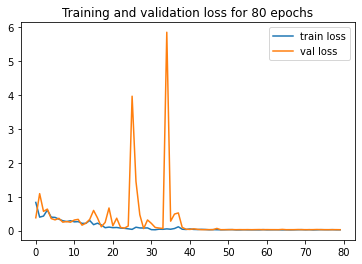

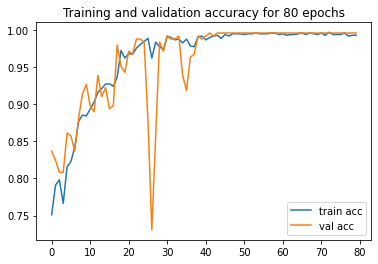

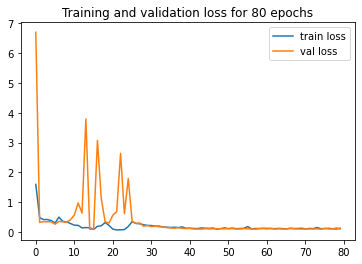

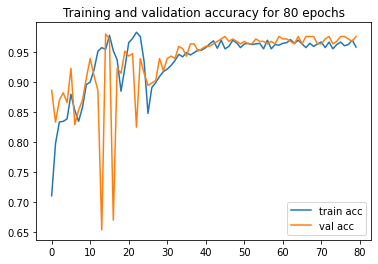

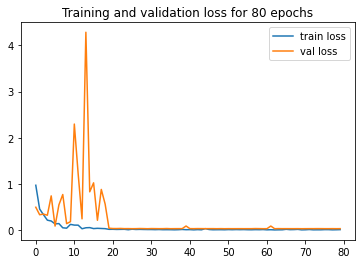

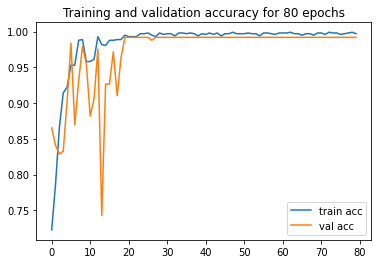

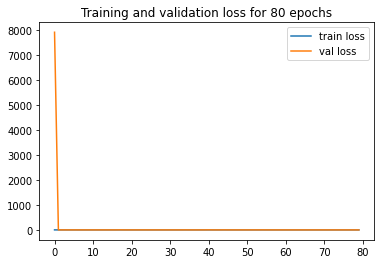

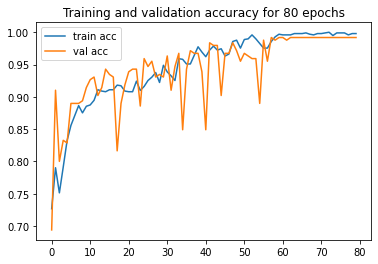

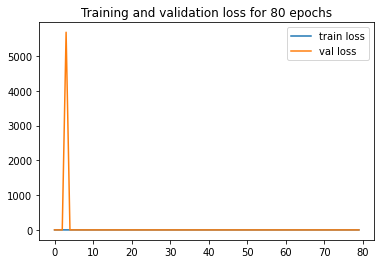

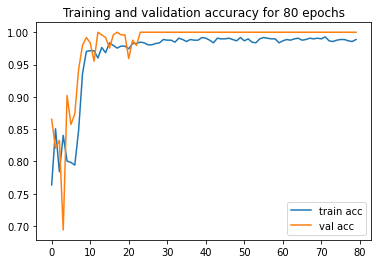

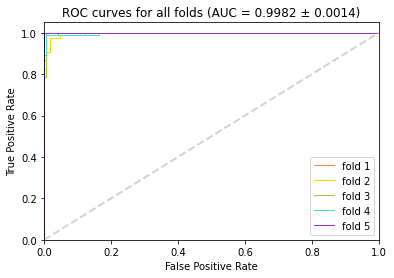

In [ ]:

def cla_inference_roc(model, criterion, dataloader, num_batch, device, infer_type):
    assert infer_type == 'test' or 'val', 'No inference type'
    loss_infer = 0
    total = 0

    # collect the probs for that epoch
    y_gt_all = []
    y_prob_all = []
    with torch.no_grad():
        # with tqdm(dataloader, unit="batch") as vepoch:
        # outputs (16,2) targets 16
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # vepoch.set_description(f"Valid Epoch {epoch+1}")

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss_infer += loss.item()
            total += targets.size(0)

            probs = F.softmax(outputs, dim=1)[:,1] # 16
            y_prob_all.append(probs.cpu().detach().numpy())
            y_gt_all.append(targets.cpu().detach().numpy())

            # vepoch.set_postfix(loss=loss_infer/(batch_idx+1))
    
    y_gt_all = np.concatenate(y_gt_all).reshape(-1)
    # y_val_preds = np.concatenate(y_val_preds).reshape(-1)
    y_prob_all = np.concatenate(y_prob_all).reshape(-1)

    fpr, tpr, threshs = roc_curve(y_gt_all, y_prob_all)
    auc_value = auc(fpr, tpr)
    gmeans = np.sqrt(tpr * (1-fpr))
    id = np.argmax(gmeans)
    thresh_opt = threshs[id]
    y_pred_all = np.where(y_prob_all<thresh_opt, 0, 1) # (N,512,512)
    
    accuracy = accuracy_score(y_gt_all, y_pred_all)
    f1 = f1_score(y_gt_all, y_pred_all)
    loss_avg = loss_infer/num_batch

    if infer_type == 'val':
        prefix = 'Valid Epoch'
    else:
        prefix = 'Test Model'
    print('%s: loss=%.4f accuracy=%.3f, AUC=%.3f, F1 score=%.3f threshold=%.3f' % (prefix, loss_avg, accuracy, auc_value, f1, thresh_opt))

    return loss_avg, accuracy, f1, fpr, tpr, auc_value, thresh_opt

def cla_data_path_load():
    img_path_all = []
    label_all = []
    for root, dirs, files in os.walk(CLA_DATA_NEW_PATH):
        if len(files) != 0:
            for file in files:
                img_path_all.append(os.path.join(root, file))
                if 'AF' in file:
                    label_all.append(1)
                elif 'SLO' in file:
                    label_all.append(0)

    img_path_all, label_all = shuffle(img_path_all, label_all, random_state=39)
    assert len(img_path_all) == len(label_all), 'image and label size does not match'

    return img_path_all, label_all

if __name__ == '__main__':

    BATCHSIZE = 20
    LR = 0.1
    EPOCH = 80

    aug_train = False
    val_ratio = 0.2
    N_FOLD = 5

    '''
    Fetch the data from disk only when necessary
    '''
    print('Loading data...')

    img_path_all, label_all = cla_data_path_load()
    
    transform_train_aug = transforms.Compose(
        [transforms.ToPILImage(),
        transforms.RandomRotation((-5,5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    transform_train = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    val_acc_ks = np.zeros(N_FOLD)
    val_acc_best_ks = np.zeros(N_FOLD)
    best_model_paths = []
    cm_logs = []
    tpr_per_fold = {} # key:kid, value tpr
    fpr_per_fold = {}
    auc_per_fold = np.zeros(N_FOLD)
    thresh_per_fold = np.zeros(N_FOLD)
    f1_per_fold = np.zeros(N_FOLD)

    kf = KFold(n_splits=N_FOLD)
    for k_i, (trv_index, test_index) in enumerate(kf.split(img_path_all)):
        print(f'\n{k_i+1} fold model')
        trv_img_paths, trv_labels = data_extract(trv_index, img_path_all, label_all)
        test_img_paths, test_labels = data_extract(test_index, img_path_all, label_all)

        ## Train/Val split
        train_img_paths, val_img_paths, train_labels, val_labels = train_test_split(trv_img_paths, trv_labels, test_size=val_ratio, shuffle=False)
        
        print(f'Train size: {len(train_img_paths)}')
        print(f'Test size: {len(test_img_paths)}')
        print(f'Val size: {len(val_img_paths)}')


        # Create HDF5 file for each split
        print('Generating HDF5 file...')
        t1 = time.time()
        create_h5_cla(train_img_paths, train_labels, 'train')
        create_h5_cla(test_img_paths, test_labels, 'test', fid=k_i+1)
        create_h5_cla(val_img_paths, val_labels, 'val')
        t2 = time.time()
        print('HDF5 file generation time: %.2f (min)' % ((t2-t1)/60))

        
        if aug_train: 
            trainset = ASDataset('train', transform_train_aug)
        else:
            trainset = ASDataset('train', transform_train)
        valset = ASDataset('val', transform_test)
        # testset = ASDataset('test', transform_test)

        trainloader = DataLoader(trainset, batch_size=BATCHSIZE, shuffle=True, num_workers=0)
        validloader = DataLoader(valset, batch_size=BATCHSIZE, shuffle=True, num_workers=0)
        # testloader = DataLoader(testset, batch_size=BATCHSIZE, shuffle=True, num_workers=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            # print("Device: ", torch.cuda.get_device_name(device))
            torch.cuda.empty_cache()
        
        resnet18 = ResNet18().to(device)
        # resnet34 = ResNet34().to(device)
        # resnet50 = ResNet50().to(device)

        # print(pms.summary(net, torch.zeros((BATCHSIZE, 3, 256, 256)).to(device), show_input=True, show_hierarchical=False))
        criterion = torch.nn.CrossEntropyLoss()
        
        # optimizer = optim.Adam(resnet18.parameters(), lr=LR)
        optimizer = optim.SGD(resnet18.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

        num_batch_train = len(trainloader)
        num_batch_val = len(validloader)
        # num_batch_test = len(testloader)

        print('\nTraining...')
        # best_acc = 0
        # save the train/valid loss/metric for every epoch 
        history = torch.zeros((EPOCH, 4))
        val_acc_best = 0.0
        model_best_path = None

        for epoch in range(EPOCH):
            ################### Training ###################
            resnet18.train()
            # accumulate loss and accuarcy over batches
            train_loss = 0
            correct = 0
            total = 0
            with tqdm(trainloader, unit="batch") as tepoch:
                tepoch.set_description(f"Train Epoch {epoch+1}")
                for batch_idx, (inputs, targets) in enumerate(tepoch):
                    
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad()

                    outputs = resnet18(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()

                    _, preds = outputs.max(1)
                    total += targets.size(0)
                    correct += preds.eq(targets).sum().item()
                
                    tepoch.set_postfix(loss=train_loss/(batch_idx+1), accuracy=100.*correct/total)
                    # sleep(0.1)
            # print(f'train epoch {epoch} total {total}')
            history[epoch][0] = train_loss / num_batch_train
            history[epoch][1] = correct / total
            scheduler.step(train_loss / num_batch_train)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            ################### Validation ################### 
            resnet18.eval()
            
            loss_val, acc_val, f1score, fpr, tpr, auc_value, thresh_opt = cla_inference_roc(resnet18, criterion, validloader, num_batch_val, device, 'val')

            history[epoch][2] = loss_val
            history[epoch][3] = acc_val
            
            # Save the model(epoch) with the best acc during training
            if history[epoch][3] > val_acc_best:
                if model_best_path is not None:
                    os.remove(model_best_path)
                modelpath = join(CLA_MODEL_PATH, 'fold%d_epoch%d_%.3f_lite.pt' % (k_i+1, epoch+1, history[epoch][-1]))
                torch.save(resnet18.state_dict(), modelpath)
                val_acc_best = history[epoch][3]
                model_best_path = modelpath

                tpr_per_fold[k_i] = tpr
                fpr_per_fold[k_i] = fpr
                auc_per_fold[k_i] = auc_value
                thresh_per_fold[k_i] = thresh_opt
                f1_per_fold[k_i] = f1score
        
        val_acc_ks[k_i] = history[-1,-1]
        val_acc_best_ks[k_i] = val_acc_best
        best_model_paths.append(split(model_best_path)[-1])



        ### plot training and validation history
        x = np.arange(EPOCH)
        plt.figure()
        plt.plot(x, history[:,0], label='train loss') # train loss
        plt.plot(x, history[:,2], label='val loss') # val loss
        plt.legend()
        plt.title('Training and validation loss for {} epochs'.format(EPOCH))
        plt.savefig(join(CLA_MODEL_PATH, f'train_val_loss{k_i+1}.png'))

        plt.figure()
        plt.plot(x, history[:,1], label='train acc') # train acc
        plt.plot(x, history[:,3], label='val acc') # val acc
        plt.legend()
        plt.title('Training and validation accuracy for {} epochs'.format(EPOCH))
        plt.savefig(join(CLA_MODEL_PATH, f'train_val_acc{k_i+1}.png'))

        trainset.close()
        valset.close()
        # testset.close()
        # del train_imgs, train_labels, val_imgs, val_labels


    print('\nTrain finished.')
    stat_compute_log(val_acc_ks, 'Validation accuracy')
    stat_compute_log(val_acc_best_ks, 'Validation best accuracy')

    auc_avg_fold, auc_std_fold = stat_compute_log(auc_per_fold, 'AUC value')
    stat_compute_log(thresh_per_fold, 'optimal threshold')
    stat_compute_log(f1_per_fold, 'f1 score')

    ### Plot roc curves for all folds including mean curve
    tpr_per_fold = np.array([tpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    fpr_per_fold = np.array([fpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    roc_plot_all(fpr_per_fold, tpr_per_fold, auc_avg_fold, auc_std_fold, 'val')

    print('Best models: ', best_model_paths)
    # for str in cm_logs:
    #     print(str)



#### Test


Testing...
Test Model: loss=0.0405 accuracy=0.997, AUC=1.000, F1 score=0.995 threshold=0.870
Test Model: loss=0.0986 accuracy=0.990, AUC=0.991, F1 score=0.985 threshold=0.122
Test Model: loss=0.1074 accuracy=0.984, AUC=0.991, F1 score=0.978 threshold=0.015
Test Model: loss=0.0090 accuracy=1.000, AUC=1.000, F1 score=1.000 threshold=0.703
Test Model: loss=0.0783 accuracy=0.984, AUC=0.996, F1 score=0.974 threshold=0.519

Test finished.
5-fold test loss:  [0.0405, 0.0986, 0.1074, 0.009, 0.0783]
5-fold test loss mean and std: 0.0668 ± 0.0369
5-fold test acc:  [0.9967, 0.9902, 0.9836, 1.0, 0.9836]
5-fold test acc mean and std: 0.9908 ± 0.0067
5-fold AUC value:  [0.9999, 0.9913, 0.9914, 1.0, 0.9956]
5-fold AUC value mean and std: 0.9956 ± 0.0038
5-fold optimal threshold:  [0.8696, 0.1216, 0.0145, 0.7026, 0.5188]
5-fold optimal threshold mean and std: 0.4454 ± 0.3292
5-fold f1 score:  [0.9953, 0.9851, 0.9784, 1.0, 0.9741]
5-fold f1 score mean and std: 0.9866 ± 0.0098


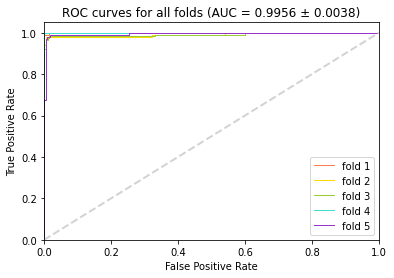

In [ ]:

if __name__ == '__main__':

    BATCHSIZE = 20
    N_FOLD = 5
    # dicebceloss

    print('\nTesting...')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    transform_test = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trained_model_paths = []
    for f in os.listdir(CLA_MODEL_PATH):
        if os.path.isfile(join(CLA_MODEL_PATH, f)) and 'lite' in f:
            trained_model_paths.append(join(CLA_MODEL_PATH, f))
    assert len(trained_model_paths) == N_FOLD, 'Trained model numbers and fold don\'t match' 
    trained_model_paths = sorted(trained_model_paths)

    ## Load N different models for testing
    loss_per_fold = []
    acc_per_fold = []
    tpr_per_fold = {} # key:kid, value tpr
    fpr_per_fold = {}
    auc_per_fold = np.zeros(N_FOLD)
    thresh_per_fold = np.zeros(N_FOLD)
    f1_per_fold = np.zeros(N_FOLD)
    # cm_logs = []
    for ki in range(N_FOLD):
        testset = ASDataset('test', transform_test, fid=ki+1)
        testloader = DataLoader(testset, batch_size=BATCHSIZE, shuffle=True, num_workers=0)
        num_batches = len(testloader)

        model_sd = torch.load(trained_model_paths[ki])
        resnet18 = ResNet18().to(device)
        resnet18.load_state_dict(model_sd)
        criterion = torch.nn.CrossEntropyLoss()

        resnet18.eval()

        loss_avg, accuracy, f1score, fpr, tpr, auc_value, thresh_opt = cla_inference_roc(resnet18, criterion, testloader, num_batches, device, 'test')

        loss_per_fold.append(loss_avg)
        acc_per_fold.append(accuracy)
        tpr_per_fold[ki] = tpr
        fpr_per_fold[ki] = fpr
        auc_per_fold[ki] = auc_value
        thresh_per_fold[ki] = thresh_opt
        f1_per_fold[ki] = f1score
        
        # tn, fp, fn, tp = confusion_matrix(y_test_trues, y_test_preds).ravel()
        # cm_log = f'Total test samples: {y_test_trues.shape[0]} TP: {tp} TN: {tn} FP: {fp} FN: {fn}'
        # cm_logs.append(cm_log)
        # fpr, tpr, _ = roc_curve(y_test_trues, y_test_scores)
        # roc_auc = auc(fpr, tpr)

        # roc_plot(fpr, tpr, roc_auc, ki)
        testset.close()
    
    print('\nTest finished.')    
    stat_compute_log(loss_per_fold, 'test loss')
    stat_compute_log(acc_per_fold, 'test acc')

    auc_avg_fold, auc_std_fold = stat_compute_log(auc_per_fold, 'AUC value')
    stat_compute_log(thresh_per_fold, 'optimal threshold')
    stat_compute_log(f1_per_fold, 'f1 score')

    ### Plot roc curves for all folds including mean curve
    tpr_per_fold = np.array([tpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    fpr_per_fold = np.array([fpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    roc_plot_all(fpr_per_fold, tpr_per_fold, auc_avg_fold, auc_std_fold, 'test')

    # for str in cm_logs:
    #     print(str)

### AF Segmentation

#### Training

Loading data...

1 fold model
Train size: 38
Test size: 12
Val size: 10
Generating HDF5 file...
HDF5 file generation time: 0.16 (min)

Training...


Valid Epoch 600: 100%|██████████| 10/10 [00:15<00:00,  1.51s/batch, loss=0.35, mIoU=88]



2 fold model
Train size: 38
Test size: 12
Val size: 10
Generating HDF5 file...
HDF5 file generation time: 0.07 (min)

Training...


Valid Epoch 600: 100%|██████████| 10/10 [00:15<00:00,  1.52s/batch, loss=0.343, mIoU=87.5]



3 fold model
Train size: 38
Test size: 12
Val size: 10
Generating HDF5 file...
HDF5 file generation time: 0.08 (min)

Training...


Valid Epoch 600: 100%|██████████| 10/10 [00:15<00:00,  1.54s/batch, loss=0.428, mIoU=86.1]



4 fold model
Train size: 38
Test size: 12
Val size: 10
Generating HDF5 file...
HDF5 file generation time: 0.08 (min)

Training...


Valid Epoch 600: 100%|██████████| 10/10 [00:15<00:00,  1.53s/batch, loss=0.39, mIoU=84.5]



5 fold model
Train size: 38
Test size: 12
Val size: 10
Generating HDF5 file...
HDF5 file generation time: 0.08 (min)

Training...


Valid Epoch 600: 100%|██████████| 10/10 [00:14<00:00,  1.46s/batch, loss=0.196, mIoU=85.4]



Train finished.
5-fold train mIoU:  [0.9102, 0.9317, 0.9247, 0.9262, 0.9255]
5-fold train mIoU mean and std: 0.9237 ± 0.0072
5-fold validation mIoU:  [0.8798, 0.8748, 0.8613, 0.8451, 0.8537]
5-fold validation mIoU mean and std: 0.8630 ± 0.0129
5-fold optimal validation mIoU:  [0.8939, 0.8862, 0.876, 0.8861, 0.8803]
5-fold optimal validation mIoU mean and std: 0.8845 ± 0.0061
5-fold AUC value:  [0.9669, 0.9727, 0.9564, 0.9882, 0.9918]
5-fold AUC value mean and std: 0.9752 ± 0.0132
5-fold uncertainty:  [386.5536, 496.5417, 572.0853, 551.4356, 295.6454]
5-fold uncertainty mean and std: 460.4523 ± 104.5607
5-fold optimal uncertainty:  [430.1029, 446.0443, 521.6328, 498.5484, 280.5637]
5-fold optimal uncertainty mean and std: 435.3784 ± 84.3083
Best models:  ['fold1_epoch406_0.894_lite.pt', 'fold2_epoch481_0.886_lite.pt', 'fold3_epoch431_0.876_lite.pt', 'fold4_epoch434_0.886_lite.pt', 'fold5_epoch509_0.880_lite.pt']


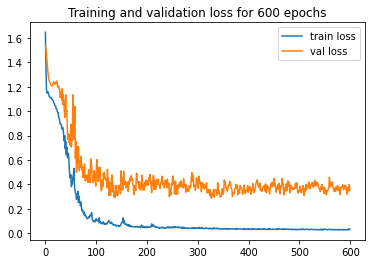

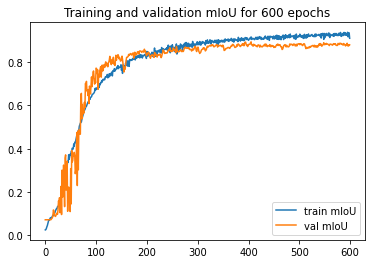

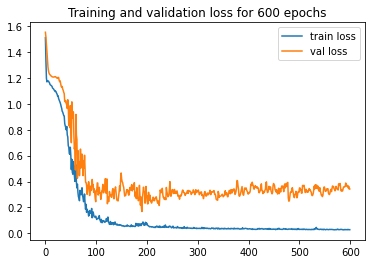

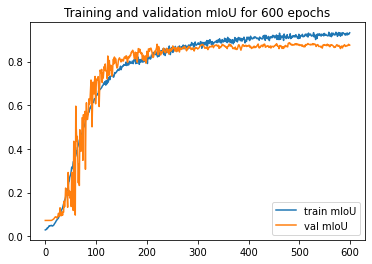

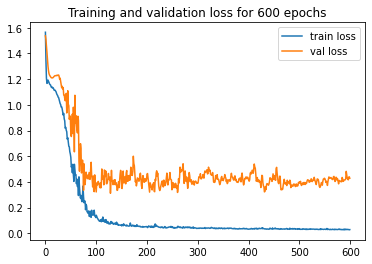

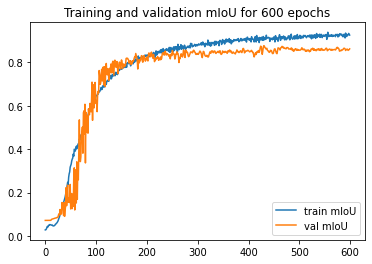

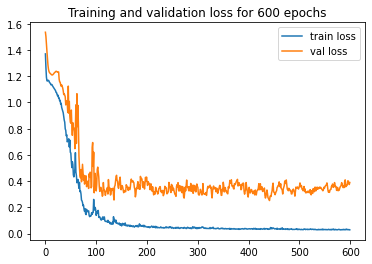

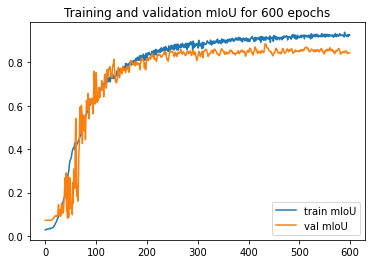

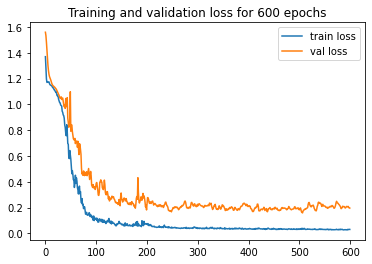

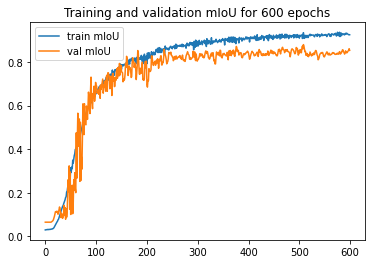

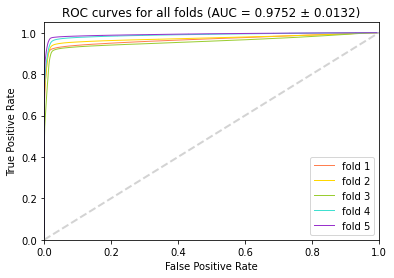

In [ ]:

def seg_inference(post_process_bool, thresh, model, criterion, dataloader, norm_size, num_batch, kid, bayes_bool, num_runs_bayes, device, infer_type, last_epoch=False):
    assert infer_type == 'test' or 'val', 'No inference type'
    loss_infer = 0
    # mIoU_sum_val_ds = 0
    mIoU_sum = 0
    total = 0
    uncertainty_sum = 0
    y_gt_all = [] 
    y_prob_all = [] 

    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as vepoch:
            for batch_idx, (inputs, targets, targets_origins, filenames) in enumerate(vepoch):
                if infer_type == 'test':
                    vepoch.set_description(f"Test Model {kid+1}")
                else:
                    vepoch.set_description(f"Valid Epoch {epoch+1}")
                
                inputs, targets = inputs.to(device), targets.to(device)
                var_maps = [None]
                
                if bayes_bool:
                    # model uncertainty analysis
                    loss_bayes_total = []
                    probs_total = []
                    for run in range(num_runs_bayes):
                        if norm_size != 512:
                            outputs = patch_infer_output(model, inputs, norm_size, device)
                        else:    
                            outputs = model(inputs)
                
                        loss = criterion(outputs, targets)
                        loss_bayes_total.append(loss.item())

                        probs = F.softmax(outputs, dim=1)
                        probs_total.append(probs.cpu().detach().numpy())

                    probs_mean = np.nanmean(probs_total, axis=0)
                    probs_var = np.var(probs_total, axis=0) # (1,2,512,512)

                    # preds = probs_mean.argmax(axis=1) # (1,512,512)
                    preds = np.where(probs_mean[:,1,:,:]>thresh, 1, 0)

                    # generate the uncertainty map (probs_var, preds)
                    var_maps = np.take_along_axis(probs_var, preds[:,None],axis=1)[:,0] # (1,512,512)
                    uncertainty_sum += np.sum(var_maps)
                    loss_infer += np.nanmean(loss_bayes_total)
                    y_prob_all.append(probs_mean[:,1,:,:])

                else:
                    if norm_size != 512:
                        outputs = patch_infer_output(model, inputs, norm_size, device)
                    else:    
                        outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    loss_infer += loss.item()
                    probs = F.softmax(outputs, dim=1)
                    preds = torch.where(probs[:,1,:,:]>thresh, 1, 0)
                    y_prob_all.append(probs[:,1,:,:].cpu().detach().numpy())

                y_gt_all.append(targets[0].cpu().detach().numpy())

                if torch.is_tensor(preds[0]):
                    preded = preds[0].cpu().detach().numpy()
                else: preded = preds[0]
                # post process
                if post_process_bool and infer_type == 'test' :
                    preded = post_process(preded, norm_size)

                # restore to original mask image size then compute miou 
                pred_restore = image_restore_seg(preded, targets_origins[0].shape)
                # mscore_ds = mIoU_score(preds, targets)
                mscore = mIoU_score(pred_restore, targets_origins[0])

                if infer_type == 'test' or last_epoch:
                    img_visual_name = 'fold%d_%s_pred%d_miou%.3f_%s.png'%(kid+1,infer_type,batch_idx+1,mscore,filenames[0])
                    seg_visual(pred_restore, var_maps[0], mscore, filenames[0], img_visual_name, 'seg')
                    seg_visual_overlap(norm_size, targets[0], preded, var_maps[0], filenames[0], img_visual_name, 'seg')
                
                # mIoU_sum_val_ds += mscore_ds
                mIoU_sum += mscore
                total += targets.size(0)

                vepoch.set_postfix(loss=loss_infer/(batch_idx+1), mIoU=100.*mIoU_sum/total)
    
    y_prob_all = np.array(y_prob_all)
    y_gt_all = np.array(y_gt_all)
    fpr, tpr, _ = roc_curve(y_gt_all.reshape(-1), y_prob_all.reshape(-1))
    auc_value = auc(fpr, tpr)

    loss_avg = loss_infer/num_batch
    mIoU_avg = mIoU_sum/total
    uncertainty_avg = uncertainty_sum/total

    return loss_avg, mIoU_avg, uncertainty_avg, fpr, tpr, auc_value
    


'''
One epoch of inference, store all the preds, compute roc curve, compute pred maps 
'''
def seg_inference_roc(post_process_bool, model, criterion, dataloader, norm_size, num_batch, kid, bayes_bool, num_runs_bayes, device, infer_type, last_epoch=False):
    assert infer_type == 'test' or 'val', 'No inference type'
    loss_infer = 0
    
    y_prob_all = [] # (N,512,512)
    y_prob_var_all = [] # (N,2,512,512)
    y_gt_all = [] # (N,512,512)
    targets_origin_all = []
    filename_all = []
    with torch.no_grad():
        # with tqdm(dataloader, unit="batch") as vepoch:
        # if patch based: inputs(1,3,768,768) targets(1,768,768) targets_origins(1,origin size)
        for batch_idx, (inputs, targets, targets_origins, filenames) in enumerate(dataloader):
            # if infer_type == 'test':
            #     vepoch.set_description(f"Test Model {kid+1}")
            # else:
            #     vepoch.set_description(f"Valid Epoch {epoch+1}")
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            if bayes_bool:
                # model uncertainty analysis
                loss_bayes_total = []
                probs_total = []
                for run in range(num_runs_bayes):
                    if norm_size != 512:
                        outputs = patch_infer_output(model, inputs, norm_size, device)
                    else:    
                        outputs = model(inputs)

                    loss = criterion(outputs, targets)
                    loss_bayes_total.append(loss.item())

                    probs = F.softmax(outputs, dim=1)
                    probs_total.append(probs.cpu().detach().numpy())
                
                loss_infer += np.nanmean(loss_bayes_total)
                y_probs = np.nanmean(probs_total, axis=0) # (1,2,512,512)
                y_probs_var = np.var(probs_total, axis=0)
                y_prob_all.append(y_probs[:,1,:,:])
                y_prob_var_all.append(y_probs_var[0])
                
            else:
                if norm_size != 512:
                    outputs = patch_infer_output(model, inputs, norm_size, device)
                else:    
                    outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss_infer += loss.item()
                y_probs = F.softmax(outputs, dim=1)
                y_prob_all.append(y_probs[:,1,:,:].cpu().detach().numpy())

            y_gt_all.append(targets[0].cpu().detach().numpy()) 
            targets_origin_all.append(targets_origins[0].detach().numpy())
            filename_all.append(filenames[0])

            # vepoch.set_postfix(loss=loss_infer/(batch_idx+1))

    y_prob_all = np.array(y_prob_all)
    y_gt_all = np.array(y_gt_all)
    fpr, tpr, threshs = roc_curve(y_gt_all.reshape(-1), y_prob_all.reshape(-1))
    auc_value = auc(fpr, tpr)
    gmeans = np.sqrt(tpr * (1-fpr))
    id = np.argmax(gmeans)
    thresh_opt = threshs[id]
    y_pred_all = np.where(y_prob_all<thresh_opt, 0, 1) # (N,512,512)

    # ### Threshold test
    # if last_epoch:
    #     data = {}
    #     data['thresh_opt'] = thresh_opt
    #     data['y_prob_all'] = y_prob_all
    #     data['y_gt_all'] = y_gt_all
    #     with open(f'fold{kid}_prob.pkl', 'wb') as f:
    #         pickle.dump(data, f)


    mIoU_sum = 0
    uncertainty_sum = 0
    for i in range(num_batch):
        # restore to original mask image size then compute miou
        y_pred = y_pred_all[i][0]
        target_origin = targets_origin_all[i]
        target = y_gt_all[i]
        filename = filename_all[i]

        var_map = None
        if bayes_bool:
            y_prob_var = y_prob_var_all[i]
            # generate the uncertainty map (probs_var, preds)
            var_map = np.take_along_axis(y_prob_var, y_pred[:,None],axis=0)[:,0]
            uncertainty_sum += np.sum(var_map)

        # post process
        if post_process_bool and infer_type == 'test':
            y_pred = post_process(y_pred, norm_size)

        pred_restore = image_restore_seg(y_pred, target_origin.shape)
        mscore = mIoU_score(pred_restore, target_origin)

        if infer_type == 'test' or last_epoch:
            img_visual_name = 'fold%d_%s_pred%d_miou%.3f_%s.png'%(kid+1,infer_type,i+1,mscore,filename)
            seg_visual(pred_restore, var_map, mscore, filename, img_visual_name, 'seg')
            seg_visual_overlap(norm_size, target, y_pred, var_map, filename, img_visual_name, 'seg')
    
        mIoU_sum += mscore

    
    loss_avg = loss_infer/num_batch
    mIoU_avg = mIoU_sum/num_batch
    uncertainty_avg = uncertainty_sum/num_batch

    if infer_type == 'val':
        prefix = 'Valid Epoch'
    else:
        prefix = 'Test Model'
    if bayes_bool:
        print('%s: loss=%.4f mIoU=%.3f AUC=%.3f threshold=%.3f uncertainty=%.3f' % (prefix, loss_avg, mIoU_avg, auc_value, thresh_opt, uncertainty_avg))
    else:
        print('%s: loss=%.4f mIoU=%.3f AUC=%.3f threshold=%.3f' % (prefix, loss_avg, mIoU_avg, auc_value, thresh_opt))

    return loss_avg, mIoU_avg, uncertainty_avg, fpr, tpr, auc_value, thresh_opt
    

def seg_data_path_load():
    img_paths = []
    mask_paths = []
    for root, dirs, files in os.walk(SEG_DATA_PATH):
        if len(files) != 0:
            for file in files:
                if '.tif' in file: 
                    img_paths.append(os.path.join(root, file))
                elif '.jpg' or '.gif' in file:
                    mask_paths.append(os.path.join(root, file))
    
    img_paths = sorted(img_paths)
    mask_paths = sorted(mask_paths)
    img_paths, mask_paths = shuffle(img_paths, mask_paths, random_state=39)
    assert len(img_paths) == len(mask_paths), 'image and mask number don\'t match'
    for i in range(len(img_paths)):
        img_name = os.path.split(img_paths[i])[-1].split('.')[0]
        mask_name = os.path.split(mask_paths[i])[-1].split('.')[0]
        assert img_name == mask_name, "image and mask don't match"
    
    return img_paths, mask_paths 

if __name__ == '__main__':

    val_ratio = 0.2
    N_FOLD = 5
    BATCHSIZE_TE = 1
    LR = 0.001
    # wce, bce, dice, dicebce
    loss_type = 'dicebce'
    # unet, segnet
    model_type ='segnet'

    BATCHSIZE_TR = 10
    EPOCH = 600

    thresh_auto = False
    thresh_value = 0.002
    
    NORM_SIZE = 512
    aug_train_bool = True
    # ['crop_stride', 'rotate', 'flip']
    aug_list = ['flip']
    clahe_bool = True
    post_process_bool = True

    bayes_bool = True # turn on dropout or not
    dropout = 0.2      # dropout rate
    dropout_state = (False, False, True)  # turn on which layers
    num_runs_bayes = 20
    

    print('Loading data...')
    img_paths, mask_paths = seg_data_path_load()

    # miou of the last epoch
    val_miou_per_fold = np.zeros(N_FOLD)
    train_miou_per_fold = np.zeros(N_FOLD)
    # miou of the best epoch
    val_miou_best_per_fold = np.zeros(N_FOLD)
    best_model_paths = []
    
    uncertainty_last_per_fold = np.zeros(N_FOLD)
    uncertainty_best_per_fold = np.zeros(N_FOLD)

    tpr_per_fold = {} # key:kid, value tpr
    fpr_per_fold = {}
    auc_per_fold = np.zeros(N_FOLD)
    thresh_per_fold = np.zeros(N_FOLD)

    ### Split dataset into training and test set according to cross validation
    kf = KFold(n_splits=N_FOLD)
    for k_i, (trv_index, test_index) in enumerate(kf.split(img_paths)):
        print(f'\n{k_i+1} fold model')
        trv_img_paths, trv_mask_paths = data_extract(trv_index, img_paths, mask_paths)
        test_img_paths, test_mask_paths = data_extract(test_index, img_paths, mask_paths)

        ## Train/Val split
        train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(trv_img_paths, trv_mask_paths, test_size=val_ratio, shuffle=False)
        
        print(f'Train size: {len(train_img_paths)}')
        print(f'Test size: {len(test_img_paths)}')
        print(f'Val size: {len(val_img_paths)}')
        
        ## Create hdf5 file for each split
        print('Generating HDF5 file...')
        t1 = time.time()
        create_h5_train_seg(train_img_paths, train_mask_paths, 'train', NORM_SIZE, clahe_bool)
        create_h5_test_seg(test_img_paths, test_mask_paths, 'test', NORM_SIZE, clahe_bool, fid=k_i+1)
        create_h5_test_seg(val_img_paths, val_mask_paths, 'val', NORM_SIZE, clahe_bool)
        t2 = time.time()
        print('HDF5 file generation time: %.2f (min)' % ((t2-t1)/60))

        trainset = AFDataset('train', augmentation=aug_train_bool, aug_list=aug_list)
        valset = AFDataset('val', augmentation=False)
        # testset = AFDataset('test', augmentation=False)

        trainloader = DataLoader(trainset, batch_size=BATCHSIZE_TR, shuffle=True, num_workers=0)
        validloader = DataLoader(valset, batch_size=BATCHSIZE_TE, shuffle=False, num_workers=0)
        # testloader = DataLoader(testset, batch_size=BATCHSIZE_TE, shuffle=False, num_workers=0)


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            # print("Device: ", torch.cuda.get_device_name(device))
            torch.cuda.empty_cache()
        
        if model_type == 'unet':
            segmodel = UNet().to(device)
        elif model_type == 'segnet':
            segmodel = SegNet(bayes_bool, dropout, dropout_state).to(device)
        

        # print(pms.summary(net, torch.zeros((BATCHSIZE, 3, 256, 256)).to(device), show_input=True, show_hierarchical=False))
        if loss_type == 'wce':
            weights = torch.tensor([1.0, 18.0]).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)
        elif loss_type == 'bce':
            criterion = nn.CrossEntropyLoss()
        elif loss_type == 'dice':
            criterion = DiceLoss()
        elif loss_type == 'dicebce':
            criterion = DiceBCELoss()

        optimizer = optim.SGD(segmodel.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
        # optimizer = optim.Adam(segmodel.parameters(), lr=LR, weight_decay=5e-4)

        num_batch_train = len(trainloader)
        num_batch_val = len(validloader)
        # num_batch_test = len(testloader)


        print('\nTraining...')
        # save the train/valid loss/metric downsampled valid metric for every epoch 
        history = torch.zeros((EPOCH, 4))
        val_miou_best = 0.0
        model_best_path = None

        for epoch in range(EPOCH):
            if epoch == EPOCH-1:
                last_epoch = True
            else:
                last_epoch = False
            ################### Training ###################
            segmodel.train()
            # accumulate loss and mIoU over batches
            train_loss = 0
            mIoU_sum = 0
            total = 0
            with tqdm(trainloader, unit="batch") as tepoch:
                tepoch.set_description(f"Train Epoch {epoch+1}")
                for batch_idx, (inputs, targets, _, _) in enumerate(tepoch):
                    batch_num = targets.size(0)
                    
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad()

                    outputs = segmodel(inputs)
                    loss = criterion(outputs, targets)
                
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()

                    probs = F.softmax(outputs, dim=1)
                    preds = torch.where(probs[:,1,:,:]>thresh_value, 1, 0)
                    mIoU_sum += sum([mIoU_score(preds[i], targets[i]) for i in range(batch_num)]) 
                    total += batch_num

                    tepoch.set_postfix(loss=train_loss/(batch_idx+1), mIoU=100.*mIoU_sum/total)
            
            history[epoch][0] = train_loss / num_batch_train
            history[epoch][1] = mIoU_sum / total
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            ################### Validation ################### 
            segmodel.eval()
            # test with dropout
            if bayes_bool:
                segmodel.apply(apply_dropout)

            ## Valid per epoch
            if thresh_auto:
                loss_val, mIoU_val, uncertainty_val, fpr, tpr, auc_value, thresh_opt = seg_inference_roc(post_process_bool, segmodel, criterion, validloader, NORM_SIZE, num_batch_val, k_i, bayes_bool, num_runs_bayes, device, 'val', last_epoch)
            else:
                loss_val, mIoU_val, uncertainty_val, fpr, tpr, auc_value = seg_inference(post_process_bool, thresh_value, segmodel, criterion, validloader, NORM_SIZE, num_batch_val, k_i, bayes_bool, num_runs_bayes, device, 'val', last_epoch)
            
            # uncertainty for every epoch
            if bayes_bool and last_epoch:
                    uncertainty_last_per_fold[k_i] = uncertainty_val

            history[epoch][2] = loss_val
            history[epoch][3] = mIoU_val

            ## Save the model(epoch) with highest val miou during training 
            ## Save fpr, tpr, auc_value, threshold of this epoch as the optimal result
            if mIoU_val > val_miou_best:
                if model_best_path is not None:
                    os.remove(model_best_path)
                modelpath = join(SEG_MODEL_PATH, 'fold%d_epoch%d_%.3f_lite.pt' % (k_i+1, epoch+1, mIoU_val))
                torch.save({'model_type': model_type,
                            'loss_type': loss_type,
                            'model_sd': segmodel.state_dict(),
                            'post_process_bool': post_process_bool,
                            'bayes_bool': bayes_bool,
                            'dropout_rate': dropout,
                            'dropout_state': dropout_state,
                            'num_runs_bayes': num_runs_bayes,
                            'norm_size': NORM_SIZE,
                            'thresh_auto': thresh_auto,
                            'thresh_value': thresh_value
                            }, modelpath)

                val_miou_best = mIoU_val
                model_best_path = modelpath
                
                tpr_per_fold[k_i] = tpr
                fpr_per_fold[k_i] = fpr
                auc_per_fold[k_i] = auc_value
                if thresh_auto:
                    thresh_per_fold[k_i] = thresh_opt

                if bayes_bool:
                    uncertainty_best_per_fold[k_i] = uncertainty_val

        train_miou_per_fold[k_i] = history[-1,1]
        # val_miou_ds_per_fold[k_i] = history[-1,-1]
        val_miou_per_fold[k_i] = history[-1,3]
        val_miou_best_per_fold[k_i] = val_miou_best
        best_model_paths.append(split(model_best_path)[-1])
        # if not save_best_model:
        #     # torch.save(history, join(SEG_MODEL_PATH, f'history{k_i+1}.pt'))
        #     torch.save(segmodel.state_dict(), join(SEG_MODEL_PATH, 'fold%d_%.3f_lite.pt' % (k_i+1, history[-1,-2])))


        ### plot training and validation history
        x = np.arange(EPOCH)
        plt.figure()
        plt.plot(x, history[:,0], label='train loss') # train loss
        plt.plot(x, history[:,2], label='val loss') # val loss
        plt.legend()
        plt.title('Training and validation loss for {} epochs'.format(EPOCH))
        plt.savefig(join(SEG_MODEL_PATH, f'train_val_loss{k_i+1}.png'))

        plt.figure()
        plt.plot(x, history[:,1], label='train mIoU') 
        plt.plot(x, history[:,3], label='val mIoU') 
        # plt.plot(x, history[:,4], label='downsampled val mIoU') 
        plt.legend()
        plt.title('Training and validation mIoU for {} epochs'.format(EPOCH))
        plt.savefig(join(SEG_MODEL_PATH, f'train_val_miou{k_i+1}.png'))

        trainset.close()
        valset.close()
        # testset.close()
        # del train_img_paths, train_mask_paths, val_img_paths, val_mask_paths


    print('\nTrain finished.')
    stat_compute_log(train_miou_per_fold, 'train mIoU')
    stat_compute_log(val_miou_per_fold, 'validation mIoU')

    stat_compute_log(val_miou_best_per_fold, 'optimal validation mIoU')

    auc_avg_fold, auc_std_fold = stat_compute_log(auc_per_fold, 'AUC value')
    if thresh_auto:
        stat_compute_log(thresh_per_fold, 'optimal threshold')

    ### Plot roc curves for all folds including mean curve
    tpr_per_fold = np.array([tpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    fpr_per_fold = np.array([fpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    roc_plot_all(fpr_per_fold, tpr_per_fold, auc_avg_fold, auc_std_fold, 'val')

    if bayes_bool:
        stat_compute_log(uncertainty_last_per_fold, 'uncertainty')
        stat_compute_log(uncertainty_best_per_fold, 'optimal uncertainty')
    print('Best models: ', best_model_paths)


#### Test


Testing...
Post processing:  False


Test Model 1: 100%|██████████| 12/12 [00:19<00:00,  1.61s/batch, loss=0.461, mIoU=80.6]


Post processing:  False


Test Model 2: 100%|██████████| 12/12 [00:16<00:00,  1.34s/batch, loss=0.163, mIoU=85.5]


Post processing:  False


Test Model 3: 100%|██████████| 12/12 [00:17<00:00,  1.42s/batch, loss=0.17, mIoU=88.4]


Post processing:  False


Test Model 4: 100%|██████████| 12/12 [00:17<00:00,  1.44s/batch, loss=0.285, mIoU=83.2]


Post processing:  False


Test Model 5: 100%|██████████| 12/12 [00:18<00:00,  1.52s/batch, loss=0.396, mIoU=85]



Test finished.
5-fold test loss:  [0.4613, 0.1632, 0.1699, 0.2853, 0.3959]
5-fold test loss mean and std: 0.2951 ± 0.1191
5-fold test mIoU:  [0.8058, 0.855, 0.8843, 0.8325, 0.8502]
5-fold test mIoU mean and std: 0.8455 ± 0.0259
5-fold test AUC value:  [0.9138, 0.981, 0.9797, 0.9877, 0.9851]
5-fold test AUC value mean and std: 0.9695 ± 0.0280
5-fold test uncertainty:  [332.2298, 239.7518, 198.0904, 306.3482, 472.2514]
5-fold test uncertainty mean and std: 309.7343 ± 94.1183


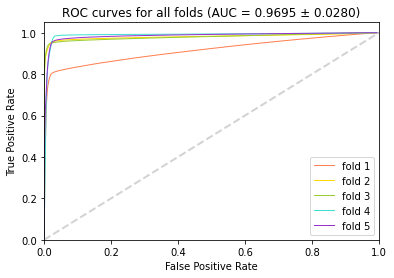

In [ ]:

if __name__ == '__main__':

    BATCHSIZE_TE = 1
    N_FOLD = 5

    print('\nTesting...')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    trained_model_paths = []
    for f in os.listdir(SEG_MODEL_PATH):
        if os.path.isfile(join(SEG_MODEL_PATH, f)) and 'lite' in f:
            trained_model_paths.append(join(SEG_MODEL_PATH, f))
    assert len(trained_model_paths) == N_FOLD, 'Trained model numbers and fold don\'t match' 
    trained_model_paths = sorted(trained_model_paths)

    ## Load N different models for testing
    loss_per_fold = []
    miou_per_fold = []
    uncertainty_per_fold = []
    tpr_per_fold = {} # key:kid, value tpr
    fpr_per_fold = {}
    auc_per_fold = []
    thresh_per_fold = []

    for ki in range(N_FOLD):
        testset = AFDataset('test', augmentation=False, fid=ki+1)
        testloader = DataLoader(testset, batch_size=BATCHSIZE_TE, shuffle=False, num_workers=0)
        num_batches = len(testloader)

        config = torch.load(trained_model_paths[ki])
        model_type = config['model_type']
        loss_type = config['loss_type']
        model_sd = config['model_sd']
        # post_process_bool = config['post_process_bool']
        
        # test 
        post_process_bool = False
        print('Post processing: ', post_process_bool)

        bayes_bool = config['bayes_bool']
        dropout = config['dropout_rate']
        dropout_state = config['dropout_state']
        num_runs_bayes = config['num_runs_bayes']
        norm_size = config['norm_size']
        thresh_auto = config['thresh_auto']
        thresh_value = config['thresh_value']

        if model_type == 'unet':
            segmodel = UNet().to(device)
        elif model_type == 'segnet':
            segmodel = SegNet(bayes_bool, dropout, dropout_state).to(device)

        segmodel.load_state_dict(model_sd)

        if loss_type == 'wce':
            weights = torch.tensor([1.0, 18.0]).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)
        elif loss_type == 'bce':
            criterion = nn.CrossEntropyLoss()
        elif loss_type == 'dice':
            criterion = DiceLoss()
        elif loss_type == 'dicebce':
            criterion = DiceBCELoss()

        segmodel.eval()
        # test with dropout
        if bayes_bool:
            segmodel.apply(apply_dropout)
        if thresh_auto:
            loss, miou, uncertainty, fpr, tpr, auc_value, thresh_opt = seg_inference_roc(post_process_bool, segmodel, criterion, testloader, norm_size, num_batches, ki, bayes_bool, num_runs_bayes, device, 'test')
        else:
            loss, miou, uncertainty, fpr, tpr, auc_value = seg_inference(post_process_bool, thresh_value, segmodel, criterion, testloader, norm_size, num_batches, ki, bayes_bool, num_runs_bayes, device, 'test')
        loss_per_fold.append(loss)
        miou_per_fold.append(miou)
        uncertainty_per_fold.append(uncertainty)
        fpr_per_fold[ki] = fpr
        tpr_per_fold[ki] = tpr
        auc_per_fold.append(auc_value)
        if thresh_auto:
            thresh_per_fold.append(thresh_opt)
        
        testset.close()

    print('\nTest finished.')    
    stat_compute_log(loss_per_fold, 'test loss')
    stat_compute_log(miou_per_fold, 'test mIoU')
    
    auc_avg_fold, auc_std_fold = stat_compute_log(auc_per_fold, 'test AUC value')
    if thresh_auto:
        stat_compute_log(thresh_per_fold, 'test optimal threshold')

    ### Plot roc curves for all folds including mean curve
    tpr_per_fold = np.array([tpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    fpr_per_fold = np.array([fpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    roc_plot_all(fpr_per_fold, tpr_per_fold, auc_avg_fold, auc_std_fold, 'test')
    
    if bayes_bool:
        stat_compute_log(uncertainty_per_fold, 'test uncertainty')


### MTL Training

#### Training

Loading data...
Seg test size 12
Cla test size 305

1 fold multi-task model
Seg train size: 38 val size: 10
Cla train size: 977 val size: 245

Generating HDF5 file...
HDF5 file generation time: 12.16 (min)

Training...
Epoch 1 train loss: 1.8056 acc: 0.8750 mIoU: 0.3450
Epoch 1 valid loss: 2.1672 mIoU: 0.4785
Epoch 2 train loss: 1.5073 acc: 0.8687 mIoU: 0.4669
Epoch 2 valid loss: 2.5768 mIoU: 0.4785
Epoch 3 train loss: 1.4261 acc: 0.9187 mIoU: 0.4699
Epoch 3 valid loss: 2.5027 mIoU: 0.4785
Epoch 4 train loss: 1.3178 acc: 0.9625 mIoU: 0.4690
Epoch 4 valid loss: 1.6293 mIoU: 0.4785
Epoch 5 train loss: 1.2947 acc: 0.9375 mIoU: 0.4690
Epoch 5 valid loss: 1.2793 mIoU: 0.4785
Epoch 6 train loss: 1.2289 acc: 0.9750 mIoU: 0.4694
Epoch 6 valid loss: 1.2064 mIoU: 0.4785
Epoch 7 train loss: 1.2205 acc: 0.9625 mIoU: 0.4701
Epoch 7 valid loss: 1.1383 mIoU: 0.4785
Epoch 8 train loss: 1.3007 acc: 0.9312 mIoU: 0.4687
Epoch 8 valid loss: 1.2993 mIoU: 0.4785
Epoch 9 train loss: 1.2491 acc: 0.9438 mIoU: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:562: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:569: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:576: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin


Train finished.
5-fold train mIoU:  [0.866144   0.91320658 0.85242033 0.90091336 0.88108903]
5-fold train mIoU mean and std: 0.8828 ± 0.0222

5-fold validation mIoU:  [0.79833919 0.73229682 0.77560723 0.77533865 0.70782274]
5-fold validation mIoU mean and std: 0.7579 ± 0.0329

5-fold optimal validation mIoU:  [0.81697518 0.7382701  0.79486889 0.80395412 0.76458073]
5-fold optimal validation mIoU mean and std: 0.7837 ± 0.0285
Best models:  ['fold1_epoch49_0.817_lite.pt', 'fold2_epoch57_0.738_lite.pt', 'fold3_epoch56_0.795_lite.pt', 'fold4_epoch56_0.804_lite.pt', 'fold5_epoch47_0.765_lite.pt']


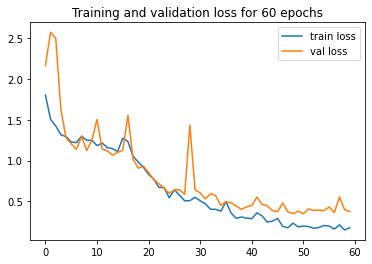

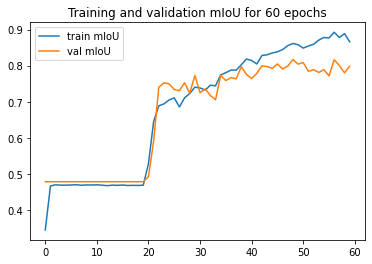

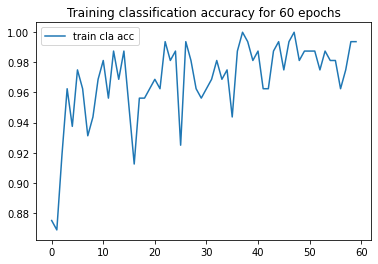

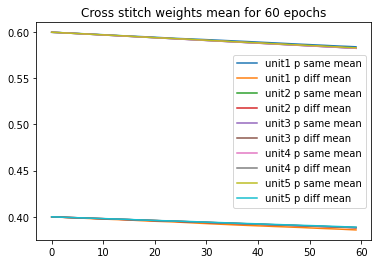

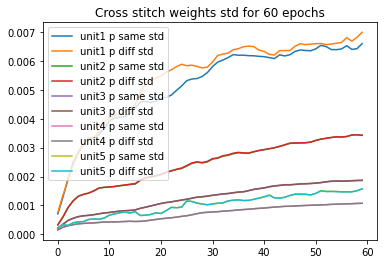

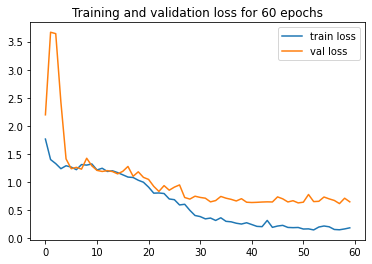

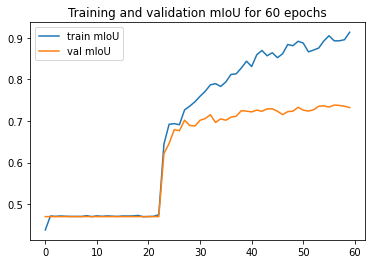

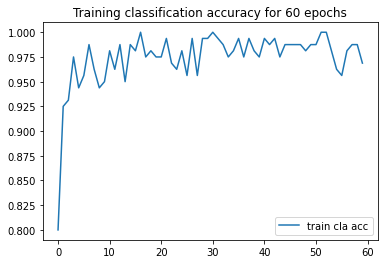

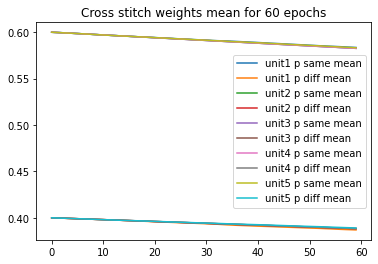

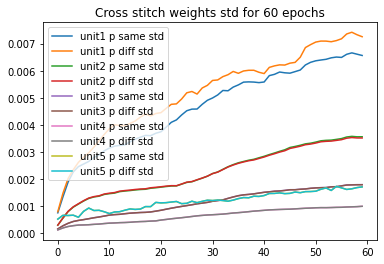

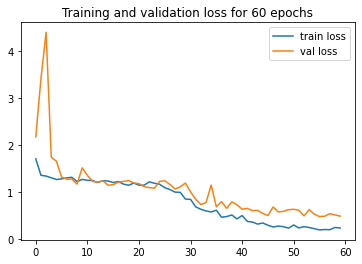

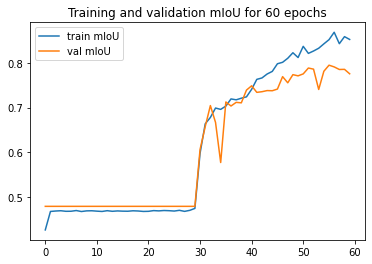

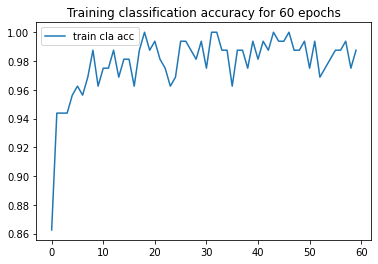

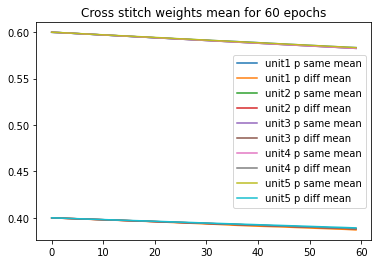

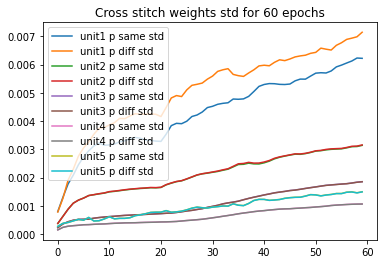

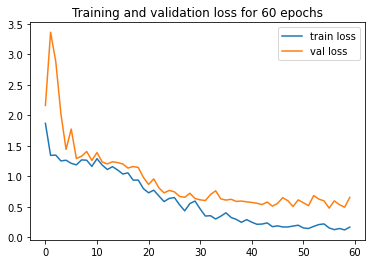

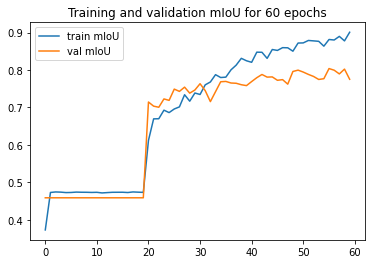

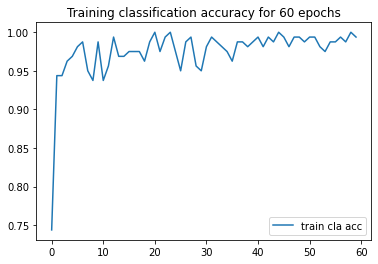

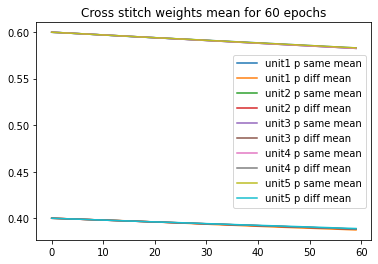

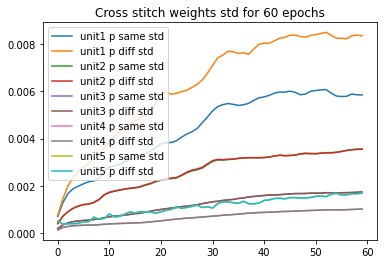

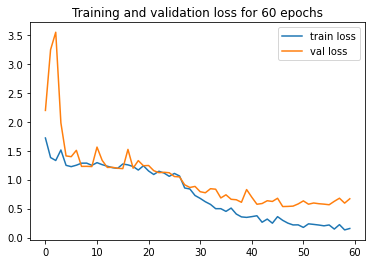

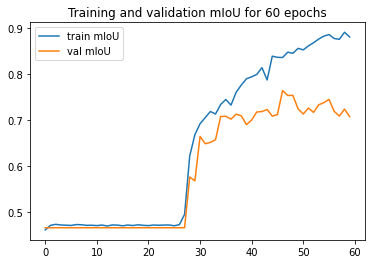

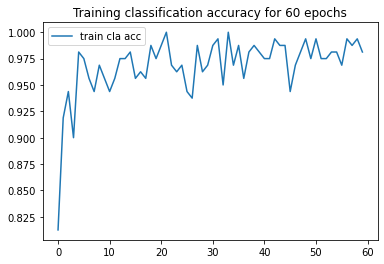

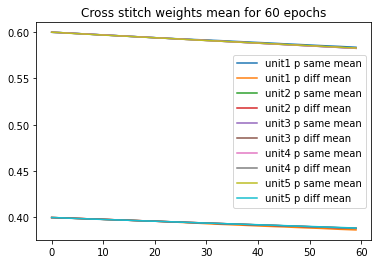

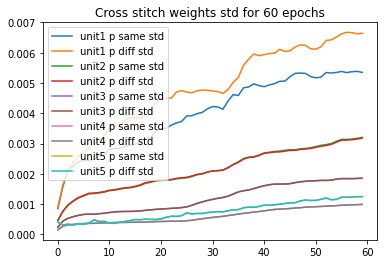

In [ ]:


def cs_weight_statics(model_param):
    """Compute the cross stitch weights mean and variance over channels for each cross-stitch unit

    Args:
        model_param: named model parameters
    """
    statics = []
    for name, param in model_param:
        if param.requires_grad and 'cross_stitch' in name:
            cs_weights = param.cpu().detach().numpy()
            chns = cs_weights.shape[0]
            p_chns = [[cs_weights[chn,0,0]+cs_weights[chn,1,1], cs_weights[chn,0,1]+cs_weights[chn,1,0]] for chn in range(chns)] # (chns, 2)
            p_chns = np.array(p_chns)/2
            p_same_mean = np.nanmean(p_chns[:,0])
            p_same_std = np.nanstd(p_chns[:,0])
            p_diff_mean = np.nanmean(p_chns[:,1])
            p_diff_std = np.nanstd(p_chns[:,1])

            statics.append(p_same_mean)
            statics.append(p_same_std)
            statics.append(p_diff_mean)
            statics.append(p_diff_std)
    
    assert len(statics) == 20
    return np.array(statics)


def cla_pretrain(trainset, valset, batchsize, lr, epochs, device):
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    mtl_clanet = ClaNet().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(mtl_clanet.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=0)
    validloader = DataLoader(valset, batch_size=batchsize, shuffle=True, num_workers=0)
    # num_batch_train = len(trainloader)
    # num_batch_val = len(validloader)


    print('\nClassfication parameters pre-training...')
    # save the train/valid loss/metric for every epoch 
    # history = torch.zeros((EPOCH, 4))
    for epoch in range(epochs):
        ################### Training ###################
        mtl_clanet.train()
        # accumulate loss and accuarcy over batches
        train_loss = 0
        correct = 0
        total = 0
        with tqdm(trainloader, unit="batch") as tepoch:
            tepoch.set_description(f"Train Epoch {epoch+1}")
            for batch_idx, (inputs, targets) in enumerate(tepoch):
                
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()

                outputs = mtl_clanet(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()
            
                tepoch.set_postfix(loss=train_loss/(batch_idx+1), accuracy=100.*correct/total)
                # sleep(0.1)
        # print(f'train epoch {epoch} total {total}')
        # history[epoch][0] = train_loss / num_batch_train
        # history[epoch][1] = correct / total

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        ################### Validation ################### 
        mtl_clanet.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            with tqdm(validloader, unit="batch") as vepoch:
                for batch_idx, (inputs, targets) in enumerate(vepoch):
                    vepoch.set_description(f"Valid Epoch {epoch+1}")

                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = mtl_clanet(inputs)
                    loss = criterion(outputs, targets)

                    val_loss += loss.item()
                    _, preds = outputs.max(1)
                    total_val += targets.size(0)
                    correct_val += preds.eq(targets).sum().item()
            
                    vepoch.set_postfix(loss=val_loss/(batch_idx+1), accuracy=100.*correct_val/total_val)

        acc = 100.*correct_val/total_val
        # print(f'valid epoch {epoch} total {total_val}')
        
        # history[epoch][2] = val_loss / num_batch_val
        # history[epoch][3] = correct_val / total_val
        
        # print('Training: loss: %.5f, accuracy: %.5f' % (history[epoch][0], history[epoch][1]))
        # print('Validation: loss: %.5f, accuracy: %.5f' % (history[epoch][2], history[epoch][3]))
    return mtl_clanet.state_dict()


def seg_pretrain(trainset, valset, batchsize, lr, epochs, device):
    if torch.cuda.is_available():
        # print("Device: ", torch.cuda.get_device_name(device))
        torch.cuda.empty_cache()
    
    trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True, num_workers=0)
    validloader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=0)

    mtl_segnet = SegNet(bayes=False, dropout=False).to(device)
    criterion = DiceBCELoss()

    optimizer = optim.SGD(mtl_segnet.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    # num_batch_train = len(trainloader)
    # num_batch_val = len(validloader)

    print('\nSegmentation parameters pre-training...')
    # save the train/valid loss/metric downsampled valid metric for every epoch 
    # history = torch.zeros((EPOCH, 5))
    for epoch in range(epochs):
        ################### Training ###################
        mtl_segnet.train()
        # accumulate loss and mIoU over batches
        train_loss = 0
        mIoU_sum = 0
        total = 0
        with tqdm(trainloader, unit="batch") as tepoch:
            tepoch.set_description(f"Train Epoch {epoch+1}")
            for batch_idx, (inputs, targets, _, _) in enumerate(tepoch):
                
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()

                outputs = mtl_segnet(inputs)
                loss = criterion(outputs, targets)
            
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                preds = outputs.argmax(dim=1)
                mIoU_sum += mIoU_score(preds, targets)
                total += targets.size(0)

                tepoch.set_postfix(loss=train_loss/(batch_idx+1), mIoU=100.*mIoU_sum/total)
        
        # history[epoch][0] = train_loss / num_batch_train
        # history[epoch][1] = mIoU_sum / total
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        ################### Validation ################### 
        mtl_segnet.eval()

        val_loss = 0
        mIoU_sum_val = 0
        total_val = 0
        with torch.no_grad():
            with tqdm(validloader, unit="batch") as vepoch:
                for batch_idx, (inputs, targets, targets_origins, filenames) in enumerate(vepoch):
                    vepoch.set_description(f"Valid Epoch {epoch+1}")
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    outputs = mtl_segnet(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    preds = outputs.argmax(dim=1)

                    # restore to original mask image size then compute miou 
                    preds_restore = image_restore_seg(preds, targets_origins.shape)
                    mscore = mIoU_score(preds_restore, targets_origins)
                    mIoU_sum_val += mscore
                    total_val += targets.size(0)

                    vepoch.set_postfix(loss=val_loss/(batch_idx+1), mIoU=100.*mIoU_sum_val/total_val)
        
        # history[epoch][2] = val_loss / num_batch_val
        # history[epoch][3] = mIoU_sum_val / total_val
        # history[epoch][4] = mIoU_sum_val_ds / total_val

    return mtl_segnet.state_dict()



def mtl_inference(post_process_bool, thresh, model, criterion, seg_dataloader, cla_dataloader, norm_size, batchsize_te_cla, num_batch, kid, device, infer_type, last_epoch=False):
    assert infer_type == 'test' or 'val', 'No inference type'
    loss_infer = 0
    mIoU_sum = 0
    total = 0

    seg_prob_all = [] # (N,512,512)
    seg_gt_all = [] # (N,512,512)

    with torch.no_grad():
        cla_val_iter = iter(cla_dataloader)
        for batch_idx, (seg_inputs, seg_targets, seg_targets_origins, seg_filenames) in enumerate(seg_dataloader):
            
            cla_inputs, cla_targets = next(cla_val_iter) 
            seg_inputs, cla_inputs = seg_inputs.to(device), cla_inputs.to(device)
            seg_targets, cla_targets = seg_targets.to(device), cla_targets.to(device) 
            var_maps = [None]
            
            # 1 seg to 20 clas making up of 20 (seg, cla) pairs
            # var_maps = [None]
            if batchsize_te_cla == 1:
                seg_outputs, cla_outputs = model(seg_inputs, cla_inputs)
                loss = criterion(seg_outputs, cla_outputs, seg_targets, cla_targets)
                loss_infer += loss.item()
                seg_probs = F.softmax(seg_outputs, dim=1)
                seg_preds = seg_outputs.argmax(dim=1)
                seg_prob_all.append(seg_probs[0,1,:,:].cpu().detach().numpy())
                
            else:
                loss_match_total = []
                probs_total = []
                for run in range(batchsize_te_cla):
                    cla_inputs_one = cla_inputs[run][None,:,:,:]
                    cla_targets_one = cla_targets[run][None]
                    seg_outputs, cla_outputs = mtl(seg_inputs, cla_inputs_one)
            
                    loss = criterion(seg_outputs, cla_outputs, seg_targets, cla_targets_one)
                    loss_match_total.append(loss.item())

                    probs = F.softmax(seg_outputs, dim=1)
                    probs_total.append(probs.cpu().detach().numpy())

                
                seg_probs = np.nanmean(probs_total, axis=0)
                seg_probs_var = np.var(probs_total, axis=0)

                seg_preds = np.where(seg_probs[:,1,:,:]>thresh, 1, 0)
                
                var_maps = np.take_along_axis(seg_probs_var, seg_preds[:,None],axis=1)[:,0] # (1,512,512)
                loss_infer += np.nanmean(loss_match_total)
                seg_prob_all.append(seg_probs[0,1,:,:])


            seg_gt_all.append(seg_targets[0].cpu().detach().numpy()) 

            seg_pred = seg_preds[0].cpu().detach().numpy()
            # post process
            if post_process_bool and infer_type == 'test' :
                seg_pred = post_process(seg_pred, norm_size)

            seg_pred_restore = image_restore_seg(seg_pred, seg_targets_origins[0].shape)
            mscore = mIoU_score(seg_pred_restore, seg_targets_origins[0])

            if infer_type == 'test' or last_epoch:
                img_visual_name = 'fold%d_%s_pred%d_miou%.3f_%s.png'%(kid+1,infer_type,batch_idx+1,mscore,seg_filenames[0])
                seg_visual(seg_pred_restore, var_maps[0], mscore, seg_filenames[0], img_visual_name, 'seg')
                seg_visual_overlap(norm_size, seg_targets[0], seg_pred, var_maps[0], seg_filenames[0], img_visual_name, 'seg')
        
            mIoU_sum += mscore
            total += seg_targets.size(0)
      
    seg_prob_all = np.array(seg_prob_all)
    seg_gt_all = np.array(seg_gt_all)
    fpr, tpr, _ = roc_curve(seg_gt_all.reshape(-1), seg_prob_all.reshape(-1))
    auc_value = auc(fpr, tpr)

    loss_avg = loss_infer/num_batch
    mIoU_avg = mIoU_sum/num_batch

    if infer_type == 'val':
        prefix = 'Valid Epoch'
    else:
        prefix = 'Test Model'
    print('%s: loss=%.4f mIoU=%.3f AUC=%.3f' % (prefix, loss_avg, mIoU_avg, auc_value))

    return loss_avg, mIoU_avg, fpr, tpr, auc_value




def mtl_inference_roc(post_process_bool, model, criterion, seg_dataloader, cla_dataloader, norm_size, batchsize_te_cla, num_batch, kid, device, infer_type, last_epoch=False):
    loss_infer = 0

    seg_prob_all = [] # (N,512,512)
    seg_prob_var_all = [] # (N,2,512,512)
    seg_gt_all = [] # (N,512,512)
    seg_targets_origin_all = []
    seg_filename_all = []

    with torch.no_grad():
        cla_val_iter = iter(cla_dataloader)
        for batch_idx, (seg_inputs, seg_targets, seg_targets_origins, seg_filenames) in enumerate(seg_dataloader):
            
            cla_inputs, cla_targets = next(cla_val_iter) 
            seg_inputs, cla_inputs = seg_inputs.to(device), cla_inputs.to(device)
            seg_targets, cla_targets = seg_targets.to(device), cla_targets.to(device) 
            # 1 seg to 20 clas making up of 20 (seg, cla) pairs

            # var_maps = [None]
            if batchsize_te_cla == 1:
                seg_outputs, cla_outputs = model(seg_inputs, cla_inputs)
                loss = criterion(seg_outputs, cla_outputs, seg_targets, cla_targets)
                loss_infer += loss.item()
                seg_probs = F.softmax(seg_outputs, dim=1)
                seg_prob_all.append(seg_probs[0,1,:,:].cpu().detach().numpy())
                # seg_preds = seg_outputs.argmax(dim=1)
            else:
                loss_match_total = []
                probs_total = []
                for run in range(batchsize_te_cla):
                    cla_inputs_one = cla_inputs[run][None,:,:,:]
                    cla_targets_one = cla_targets[run][None]
                    seg_outputs, cla_outputs = mtl(seg_inputs, cla_inputs_one)
            
                    loss = criterion(seg_outputs, cla_outputs, seg_targets, cla_targets_one)
                    loss_match_total.append(loss.item())

                    probs = F.softmax(seg_outputs, dim=1)
                    probs_total.append(probs.cpu().detach().numpy())

                loss_infer += np.nanmean(loss_match_total)
                seg_probs = np.nanmean(probs_total, axis=0)
                seg_probs_var = np.var(probs_total, axis=0)
                seg_prob_all.append(seg_probs[0,1,:,:])
                seg_prob_var_all.append(seg_probs_var[0])

            seg_gt_all.append(seg_targets[0].cpu().detach().numpy()) 
            seg_targets_origin_all.append(seg_targets_origins[0].detach().numpy())
            seg_filename_all.append(seg_filenames[0])

    
    seg_prob_all = np.array(seg_prob_all)
    seg_gt_all = np.array(seg_gt_all)
    fpr, tpr, threshs = roc_curve(seg_gt_all.reshape(-1), seg_prob_all.reshape(-1))
    auc_value = auc(fpr, tpr)
    gmeans = np.sqrt(tpr * (1-fpr))
    id = np.argmax(gmeans)
    thresh_opt = threshs[id]
    seg_pred_all = np.where(seg_prob_all<thresh_opt, 0, 1) # (N,512,512)


    mIoU_sum = 0
    for i in range(num_batch):
        # restore to original mask image size then compute miou
        seg_pred = seg_pred_all[i][0]
        seg_target_origin = seg_targets_origin_all[i]
        seg_target = seg_gt_all[i]
        seg_filename = seg_filename_all[i]

        var_map = None
        if batchsize_te_cla != 1:
            seg_prob_var = seg_prob_var_all[i]
            # generate the uncertainty map (probs_var, preds)
            var_map = np.take_along_axis(seg_prob_var, seg_pred[:,None],axis=0)[:,0]

        # post process
        if post_process_bool and infer_type == 'test':
            seg_pred = post_process(seg_pred, norm_size)

        seg_pred_restore = image_restore_seg(seg_pred, seg_target_origin.shape)
        mscore = mIoU_score(seg_pred_restore, seg_target_origin)

        if infer_type == 'test' or last_epoch:
            img_visual_name = 'fold%d_%s_pred%d_miou%.3f_%s.png'%(kid+1,infer_type,i+1,mscore,seg_filename)
            seg_visual(seg_pred_restore, var_map, mscore, seg_filename, img_visual_name, 'seg')
            seg_visual_overlap(norm_size, seg_target, seg_pred, var_map, seg_filename, img_visual_name, 'seg')
    
        mIoU_sum += mscore

    
    loss_avg = loss_infer/num_batch
    mIoU_avg = mIoU_sum/num_batch

    if infer_type == 'val':
        prefix = 'Valid Epoch'
    else:
        prefix = 'Test Model'
    print('%s: loss=%.4f mIoU=%.3f AUC=%.3f threshold=%.3f' % (prefix, loss_avg, mIoU_avg, auc_value, thresh_opt))

    return loss_avg, mIoU_avg, fpr, tpr, auc_value, thresh_opt
    


if __name__ == '__main__':

    val_ratio=0.2
    N_FOLD = 5

    BATCHSIZE_TR = 1
    BATCHSIZE_TE_SEG = 1
    # pairs, if more than 1, compute mean and variance 
    BATCHSIZE_TE_CLA = 1 
    # report the result every BATCH_PER_EPOCH batches
    EPOCH = 2 #60
    BATCH_PER_EPOCH = 1 #10
    # training iterations = EPOCH * BATCH_PER_EPOCH * BATCHSIZE_TR

    NORM_SIZE = 256
    aug_train_bool = False
    aug_list = ['rotate', 'flip']
    clahe_bool = False
    
    p_same = 0.8
    p_diff = 0.2
    
    compute_wcs = False
    
    LR = 0.001
    cs_diff_lr = False
    CS_LR_RATIO = 100

    pretrain_load = False
    PRE_SEG_EPOCH = 100
    PRE_CLA_EPOCH = 15

    thresh_auto = True
    thresh_value = 0.5
    post_process_bool = True

    print('Loading data...')
    cla_img_paths, cla_labels = cla_data_path_load()
    seg_img_paths, seg_mask_paths = seg_data_path_load()

    cla_transform_train = transforms.Compose(
        [transforms.ToPILImage(),
        # transforms.RandomCrop(512),
        # transforms.RandomRotation((0,180)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    cla_transform_test = transforms.Compose(
        [transforms.ToTensor(),
        # transforms.Resize(256),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    ### N-fold split
    kf = KFold(n_splits=N_FOLD)
    seg_kf_gen = kf.split(seg_img_paths)
    cla_kf_gen = kf.split(cla_img_paths)

    # miou of the last epoch
    val_miou_per_fold = np.zeros(N_FOLD)
    train_miou_per_fold = np.zeros(N_FOLD)
    # miou of the best epoch
    val_miou_best_per_fold = np.zeros(N_FOLD)
    best_model_paths = []

    tpr_per_fold = {} # key:kid, value tpr
    fpr_per_fold = {}
    auc_per_fold = np.zeros(N_FOLD)
    thresh_per_fold = np.zeros(N_FOLD)

    for k_i in range(N_FOLD):
        seg_trv_index, seg_test_index = next(seg_kf_gen)
        cla_trv_index, cla_test_index = next(cla_kf_gen)
        
        print(f'\n{k_i+1} fold multi-task model')
        
        ### Split dataset into training and test set according to cross validation
        seg_trv_imgs, seg_trv_masks = data_extract(seg_trv_index, seg_img_paths, seg_mask_paths)
        seg_test_imgs, seg_test_masks = data_extract(seg_test_index, seg_img_paths, seg_mask_paths)

        cla_trv_imgs, cla_trv_labels = data_extract(cla_trv_index, cla_img_paths, cla_labels)
        cla_test_imgs, cla_test_labels = data_extract(cla_test_index, cla_img_paths, cla_labels)
        
        ## Train/Val split
        seg_train_imgs, seg_val_imgs, seg_train_masks, seg_val_masks = train_test_split(seg_trv_imgs, seg_trv_masks, test_size=val_ratio, shuffle=False)
        cla_train_imgs, cla_val_imgs, cla_train_labels, cla_val_labels = train_test_split(cla_trv_imgs, cla_trv_labels, test_size=val_ratio, shuffle=False)
        
        print(f'Seg train size: {len(seg_train_imgs)} val size: {len(seg_val_imgs)} test size: {len(seg_test_imgs)}')
        print(f'Cla train size: {len(cla_train_imgs)} val size: {len(cla_val_imgs)} test size: {len(cla_test_imgs)}')

        ## Create hdf5 file for each split
        print('\nGenerating HDF5 file...')
        t1 = time.time()
        create_h5_train_seg(seg_train_imgs, seg_train_masks, 'train', NORM_SIZE, clahe_bool)
        create_h5_test_seg(seg_test_imgs, seg_test_masks, 'test', NORM_SIZE, clahe_bool, fid=k_i+1)
        create_h5_test_seg(seg_val_imgs, seg_val_masks, 'val', NORM_SIZE, clahe_bool)

        create_h5_cla(cla_train_imgs, cla_train_labels, 'train')
        create_h5_cla(cla_test_imgs, cla_test_labels, 'test', fid=k_i+1)
        create_h5_cla(cla_val_imgs, cla_val_labels, 'val')
        t2 = time.time()
        print('HDF5 file generation time: %.2f (min)' % ((t2-t1)/60))


        seg_trainset = AFDataset('train', augmentation=aug_train_bool, aug_list=aug_list)
        seg_valset = AFDataset('val', augmentation=False)
        # seg_testset = AFDataset('test', augmentation=False)

        cla_trainset = ASDataset('train', cla_transform_train)
        cla_valset = ASDataset('val', cla_transform_test)
        # cla_testset = ASDataset('test', cla_transform_test)

        seg_trainloader = DataLoader(seg_trainset, batch_size=BATCHSIZE_TR, shuffle=True, drop_last=True, num_workers=0)
        seg_validloader = DataLoader(seg_valset, batch_size=BATCHSIZE_TE_SEG, shuffle=False, num_workers=0)
        # seg_testloader = DataLoader(seg_testset, batch_size=BATCHSIZE_TE_SEG, shuffle=False, num_workers=0)

        cla_trainloader = DataLoader(cla_trainset, batch_size=BATCHSIZE_TR, shuffle=True, drop_last=True, num_workers=0)
        cla_validloader = DataLoader(cla_valset, batch_size=BATCHSIZE_TE_CLA, shuffle=True, num_workers=0)
        # cla_testloader = DataLoader(cla_testset, batch_size=BATCHSIZE_TE_CLA, shuffle=True, num_workers=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            # print("Device: ", torch.cuda.get_device_name(device))
            torch.cuda.empty_cache()
        
        mtl = MTL(p_same=p_same, p_diff=p_diff, device=device).to(device)

        # TODO
        if pretrain_load:
            seg_state_dict = seg_pretrain(seg_trainset, seg_valset, batchsize=16, lr=0.001, epochs=PRE_SEG_EPOCH, device=device)
            cla_state_dict = cla_pretrain(cla_trainset, cla_valset, batchsize=16, lr=0.001, epochs=PRE_CLA_EPOCH, device=device)
            seg_state_dict = change_state_keys(seg_state_dict, type='seg')
            cla_state_dict = change_state_keys(cla_state_dict, type='cla')
            
            mtl.load_state_dict(seg_state_dict, strict=False)
            mtl.load_state_dict(cla_state_dict, strict=False)
            mtl_state_dict = mtl.state_dict()
        
        
        criterion = MTLLoss()
        if not cs_diff_lr:
            optimizer = optim.SGD(mtl.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
        else:
            wcs_list = ['cross_stitch1.weights','cross_stitch2.weights','cross_stitch3.weights','cross_stitch4.weights','cross_stitch5.weights']
            cs_params = list(filter(lambda kv: kv[0] in wcs_list, mtl.named_parameters()))
            cs_params = list(map(lambda x: x[1], cs_params))
            base_params = list(filter(lambda kv: kv[0] not in wcs_list, mtl.named_parameters()))
            base_params = list(map(lambda x: x[1], base_params))
            
            # optimizer = optim.SGD([
            #     {'params': cs_params, 'lr': LR*CS_LR_RATIO},
            #     {'params': base_params, 'lr': LR}
            # ], lr=LR, momentum=0.9, weight_decay=5e-4)
            optimizer = optim.SGD([
                {'params': cs_params, 'lr': LR*CS_LR_RATIO, 'momentum': 0.9, 'weight_decay': 5e-4},
                {'params': base_params, 'lr': LR, 'momentum': 0.9, 'weight_decay': 5e-4}])

        seg_train_iter = iter(seg_trainloader)
        cla_train_iter = iter(cla_trainloader)
        seg_val_num_batch = len(seg_validloader)
        
        print('\nTraining...')
        # cs layer 1-5 mean and std of p_same/p_diff
        cs_param_history = np.zeros((EPOCH, 20))
        # save the train loss/mIoU/acc val loss/mIoU  for every epoch
        history = torch.zeros((EPOCH, 5))
        val_miou_best = 0.0
        model_best_path = None

        for epoch in range(EPOCH):
            if epoch == EPOCH-1:
                last_epoch = True
            else:
                last_epoch = False
            ################### Training ###################
            mtl.train()
            train_loss = 0
            cla_correct = 0
            mIoU_sum = 0
            total = 0
            
            for batch_id in range(BATCH_PER_EPOCH):
                # get a batch of seg/cla data
                try:
                    seg_inputs, seg_targets, _, _ = next(seg_train_iter)
                except StopIteration:
                    seg_train_iter = iter(seg_trainloader)
                    seg_inputs, seg_targets, _, _ = next(seg_train_iter)

                try:
                    cla_inputs, cla_targets = next(cla_train_iter)
                except StopIteration:
                    cla_train_iter = iter(cla_trainloader)
                    cla_inputs, cla_targets = next(cla_train_iter)
                
                # forward and backward
                seg_inputs, cla_inputs = seg_inputs.to(device), cla_inputs.to(device)  
                seg_targets, cla_targets = seg_targets.to(device), cla_targets.to(device)  
                optimizer.zero_grad()

                seg_outputs, cla_outputs = mtl(seg_inputs, cla_inputs)
                loss = criterion(seg_outputs, cla_outputs, seg_targets, cla_targets)
            
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                
                seg_probs = F.softmax(seg_outputs, dim=1)
                seg_preds = torch.where(seg_probs[:,1,:,:]>thresh_value, 1, 0)
                mIoU_sum += mIoU_score(seg_preds, seg_targets)
                
                _, cla_preds = cla_outputs.max(1)
                cla_correct += cla_preds.eq(cla_targets).sum().item()
                
                total += seg_targets.size(0)

            history[epoch, 0] = train_loss / BATCH_PER_EPOCH
            history[epoch, 1] = cla_correct / total
            history[epoch, 2] = mIoU_sum / total 

            print('Epoch %d train loss: %.4f acc: %.4f mIoU: %.4f' % (epoch+1, history[epoch, 0], history[epoch, 1], history[epoch, 2]))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            ################### Validation ################### 
            if compute_wcs:
                # change of cross stitch weights
                cs_param_history[epoch, :] = cs_weight_statics(mtl.named_parameters())
                # print(cs_param_history[epoch, :].reshape((5,4)))
            
            mtl.eval()
            # test with dropout
            # if bayes_bool:
            #     mtl.apply(apply_dropout)
            # t1 = time.time()
            if thresh_auto:
                loss_val, mIoU_val, fpr, tpr, auc_value, thresh_opt = mtl_inference_roc(post_process_bool, mtl, criterion, seg_validloader, cla_validloader, NORM_SIZE, BATCHSIZE_TE_CLA, seg_val_num_batch, k_i, device, 'val', last_epoch)
            else:
                loss_val, mIoU_val, fpr, tpr, auc_value = mtl_inference(post_process_bool, thresh_value, mtl, criterion, seg_validloader, cla_validloader, NORM_SIZE, BATCHSIZE_TE_CLA, seg_val_num_batch, k_i, device, 'val', last_epoch)

            history[epoch, 3] = loss_val
            history[epoch, 4] = mIoU_val

            # print('Epoch %d valid loss: %.4f mIoU: %.4f' % (epoch+1, history[epoch, 3], history[epoch, 4]))
            # Save the model(epoch) with highest val miou during training
            if mIoU_val > val_miou_best:
                if model_best_path is not None:
                    os.remove(model_best_path)
                modelpath = join(MTL_MODEL_PATH, 'fold%d_epoch%d_%.3f_lite.pt' % (k_i+1, epoch+1, mIoU_val))
                torch.save({'model_sd': mtl.state_dict(),
                            'norm_size': NORM_SIZE,
                            'batchsize_te_cla': BATCHSIZE_TE_CLA,
                            'p_same': p_same,
                            'p_diff': p_diff,
                            'thresh_auto': thresh_auto,
                            'thresh_value': 0.5,
                            'post_process_bool': post_process_bool
                            }, modelpath)

                val_miou_best = mIoU_val
                model_best_path = modelpath

                tpr_per_fold[k_i] = tpr
                fpr_per_fold[k_i] = fpr
                auc_per_fold[k_i] = auc_value
                if thresh_auto:
                    thresh_per_fold[k_i] = thresh_opt
            # t2 = time.time()
            # print('Validation time: %.2f (min)' % ((t2-t1)/60))

        train_miou_per_fold[k_i] = history[-1,2]
        val_miou_per_fold[k_i] = history[-1,4]
        val_miou_best_per_fold[k_i] = val_miou_best
        best_model_paths.append(split(model_best_path)[-1])

        
        
        ### plot training and validation history
        x = np.arange(EPOCH)
        plt.figure()
        plt.plot(x, history[:,0], label='train loss') # train loss
        plt.plot(x, history[:,3], label='val loss') # val loss
        plt.legend()
        plt.title('Training and validation loss for {} epochs'.format(EPOCH))
        plt.savefig(join(MTL_MODEL_PATH, f'train_val_loss{k_i+1}.png'))

        plt.figure()
        plt.plot(x, history[:,2], label='train mIoU') 
        plt.plot(x, history[:,4], label='val mIoU') 
        plt.legend()
        plt.title('Training and validation mIoU for {} epochs'.format(EPOCH))
        plt.savefig(join(MTL_MODEL_PATH, f'train_val_miou{k_i+1}.png'))

        plt.figure()
        plt.plot(x, history[:,1], label='train cla acc') 
        plt.legend()
        plt.title('Training classification accuracy for {} epochs'.format(EPOCH))
        plt.savefig(join(MTL_MODEL_PATH, f'train_cla_acc{k_i+1}.png'))

        # plot the p_same and p_diff changing curves
        # 1-4 p_same_mean, p_same_std, p_diff_mean, p_diff_std
        if compute_wcs:
            ## mean
            plt.figure()
            for chn in range(5):
                plt.plot(x, cs_param_history[:,4*chn], label=f'unit{chn+1} p same mean')
                plt.plot(x, cs_param_history[:,4*chn+2], label=f'unit{chn+1} p diff mean')
            plt.legend()
            plt.title(f'Cross stitch weights mean for {EPOCH} epochs')
            plt.savefig(join(MTL_MODEL_PATH, f'cs_weights_mean{k_i+1}.png'))

            ## std
            plt.figure()
            for chn in range(5):
                plt.plot(x, cs_param_history[:,4*chn+1], label=f'unit{chn+1} p same std')
                plt.plot(x, cs_param_history[:,4*chn+3], label=f'unit{chn+1} p diff std')
            plt.legend()
            plt.title(f'Cross stitch weights std for {EPOCH} epochs')
            plt.savefig(join(MTL_MODEL_PATH, f'cs_weights_std{k_i+1}.png'))
        
        # plt.close('all')
        seg_trainset.close()
        seg_valset.close()
        # seg_testset.close()
        cla_trainset.close()
        cla_valset.close()
        # cla_testset.close()


    print('\nTrain finished.')
    stat_compute_log(train_miou_per_fold, 'train mIoU')
    stat_compute_log(val_miou_per_fold, 'validation mIoU')

    stat_compute_log(val_miou_best_per_fold, 'optimal validation mIoU')
    print('Best models: ', best_model_paths)

    auc_avg_fold, auc_std_fold = stat_compute_log(auc_per_fold, 'AUC value')
    if thresh_auto:
        stat_compute_log(thresh_per_fold, 'optimal threshold')

    ### Plot roc curves for all folds including mean curve
    tpr_per_fold = np.array([tpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    fpr_per_fold = np.array([fpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
    roc_plot_all(fpr_per_fold, tpr_per_fold, auc_avg_fold, auc_std_fold, 'val')
   

#### Test

In [ ]:
BATCHSIZE_TE_SEG = 1
N_FOLD = 5

print('Testing...')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()

trained_model_paths = []
for f in os.listdir(MTL_MODEL_PATH):
    if os.path.isfile(join(MTL_MODEL_PATH, f)) and 'lite' in f:
        trained_model_paths.append(join(MTL_MODEL_PATH, f))
assert len(trained_model_paths) == N_FOLD, 'Trained model numbers and fold don\'t match' 
trained_model_paths = sorted(trained_model_paths)

cla_transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])




## Load N different models for testing
loss_per_fold = []
miou_per_fold = []
tpr_per_fold = {} # key:kid, value tpr
fpr_per_fold = {}
auc_per_fold = []
thresh_per_fold = []

for ki in range(N_FOLD):

    # model configuration
    config = torch.load(trained_model_paths[ki])
    model_sd = config['model_sd']
    norm_size = config['norm_size']
    # test
    # BATCHSIZE_TE_CLA = 1
    BATCHSIZE_TE_CLA = config['batchsize_te_cla']
    p_diff = config['p_diff']                        
    
    p_same = config['p_same']                        
    thresh_auto = config['thresh_auto'] 
    thresh_value = config['thresh_value']
    post_process_bool = config['post_process_bool'] 


    seg_testset = AFDataset('test', augmentation=False, fid=ki+1)
    seg_testloader = DataLoader(seg_testset, batch_size=BATCHSIZE_TE_SEG, shuffle=False, num_workers=0)
    num_batches = len(seg_testloader)

    cla_testset = ASDataset('test', cla_transform_test, fid=ki+1)
    cla_testloader = DataLoader(cla_testset, batch_size=BATCHSIZE_TE_CLA, shuffle=True, num_workers=0)

    mtl = MTL(device=device, p_same=p_same, p_diff=p_diff).to(device)
    criterion = MTLLoss()
    mtl.load_state_dict(model_sd)
    mtl.eval()

    if thresh_auto:
        loss, miou, fpr, tpr, auc_value, thresh_opt = mtl_inference_roc(post_process_bool, mtl, criterion, seg_testloader, cla_testloader, norm_size, BATCHSIZE_TE_CLA, num_batches, ki, device, 'test')
    else:
        loss, miou, fpr, tpr, auc_value = mtl_inference(post_process_bool, thresh_value, mtl, criterion, seg_testloader, cla_testloader, norm_size, BATCHSIZE_TE_CLA, num_batches, ki, device, 'test')

    loss_per_fold.append(loss)
    miou_per_fold.append(miou)
    fpr_per_fold[ki] = fpr
    tpr_per_fold[ki] = tpr
    auc_per_fold.append(auc_value)
    if thresh_auto:
        thresh_per_fold.append(thresh_opt)
    
    seg_testset.close()
    cla_testset.close()

print('\nTest finished.')    
stat_compute_log(loss_per_fold, 'test loss')
stat_compute_log(miou_per_fold, 'test mIoU')

auc_avg_fold, auc_std_fold = stat_compute_log(auc_per_fold, 'test AUC value')
if thresh_auto:
    stat_compute_log(thresh_per_fold, 'test optimal threshold')

### Plot roc curves for all folds including mean curve
tpr_per_fold = np.array([tpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
fpr_per_fold = np.array([fpr_per_fold[i] for i in range(N_FOLD)], dtype=object)
roc_plot_all(fpr_per_fold, tpr_per_fold, auc_avg_fold, auc_std_fold, 'test')
